# data prep

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
from typing import List, Dict, Union
import seaborn as sns
sns.set(rc={"figure.figsize":(10,3)})

In [2]:
import warnings
warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)

In [3]:
 matches_df = pd.read_parquet("./esta/parsed/matches.parquet")
 rounds_df = pd.read_parquet("./esta/parsed/rounds.parquet")
 kills_df = pd.read_parquet("./esta/parsed/kills.parquet")
 damages_df = pd.read_parquet("./esta/parsed/damages.parquet") 
 grenades_df = pd.read_parquet("./esta/parsed/grenades.parquet") 
 bomb_events_df = pd.read_parquet("./esta/parsed/bomb_events.parquet") 
 weapon_fires_df = pd.read_parquet("./esta/parsed/weapon_fires.parquet") 
 flashes_df = pd.read_parquet("./esta/parsed/flashes.parquet") 
 frames_df = pd.read_parquet("./esta/parsed/frames.parquet")
 players_df = pd.read_parquet("./esta/parsed/players.parquet") 
 team_frames_df = pd.read_parquet("./esta/parsed/team_frames.parquet") 
 player_frames_df = pd.read_parquet("./esta/parsed/player_frames.parquet") 
 inventory_df = pd.read_parquet("./esta/parsed/inventory.parquet") 
 bomb_location_df = pd.read_parquet("./esta/parsed/bomb_location.parquet") 
 projectiles_df = pd.read_parquet("./esta/parsed/projectiles.parquet") 
 smokes_df = pd.read_parquet("./esta/parsed/smokes.parquet") 
 fires_df = pd.read_parquet("./esta/parsed/fires.parquet") 

image_dim = 1024

In [4]:
with open(".awpy/maps/map-data.json", "r") as f:
    all_map_data = json.load(f)


In [5]:
idx_pf_df = player_frames_df.set_index(["match_id","round_num"])
idx_f_df = flashes_df.set_index(["match_id","round_num"])
idx_sm_df = smokes_df.set_index(["match_id","round_num"])
idx_d_df = damages_df.set_index(["match_id","round_num"])

idx_d_df.loc[:,"total_damage"] = idx_d_df["hp_damage"] + idx_d_df["armor_damage"]
idx_d_df.loc[:,"total_damage_taken"] = idx_d_df["hp_damage_taken"] + idx_d_df["armor_damage_taken"]
idx_d_df.attacker_steam_id = idx_d_df.attacker_steam_id.astype("Int64")
idx_d_df.victim_steam_id = idx_d_df.victim_steam_id.astype("Int64")

idx_k_df = kills_df.set_index(["match_id","round_num"])
idx_r_df = rounds_df.set_index(["match_id","round_num"])
idx_r_df["n_ticks"] = idx_r_df["end_tick"]
idx_r_df["bomb_plant_tick"] = idx_r_df["bomb_plant_tick"]

idx_fr_df = frames_df.set_index(["match_id","round_num"])

idx_g_df = grenades_df.set_index(["match_id","round_num"])
idx_g_df["grenade_side"] = idx_g_df.thrower_side
idx_g_df = idx_g_df[idx_g_df.destroy_tick > idx_g_df.throw_tick]

idx_wf_df = weapon_fires_df.set_index(["match_id","round_num"])

In [6]:
all_idx_df = [idx_pf_df, idx_f_df, idx_sm_df, idx_d_df, idx_k_df, idx_fr_df, idx_g_df, idx_wf_df]

for idx in idx_r_df.index:
    first_tick = idx_r_df.loc[idx,"start_tick"]
    for df in all_idx_df:
        tick_cols = [col for col in df.columns if "tick" in col]
        if tick_cols and idx in df.index:
            df.loc[idx,tick_cols] = df.loc[idx,tick_cols]-first_tick

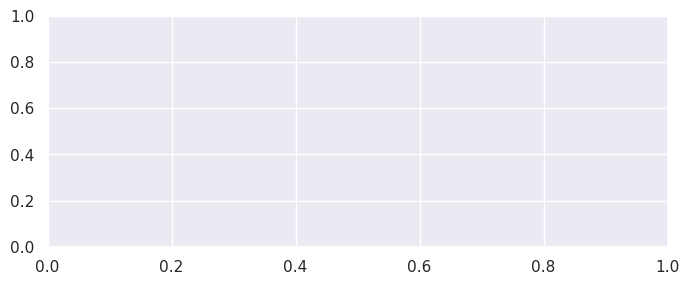

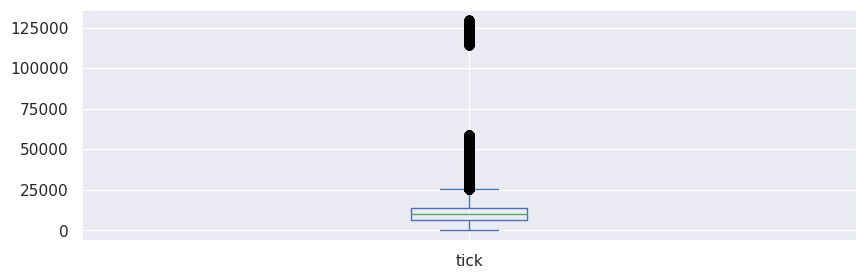

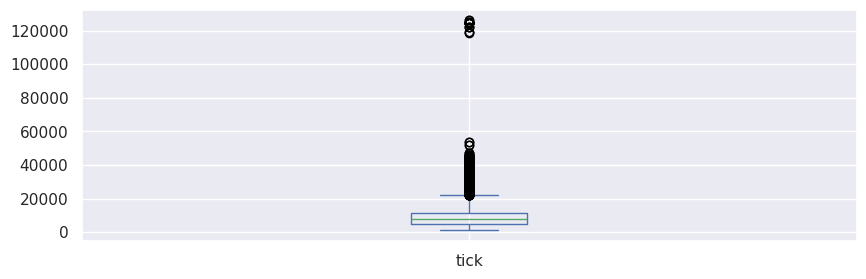

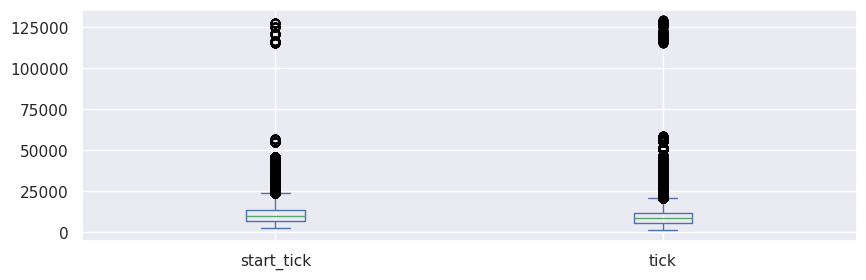

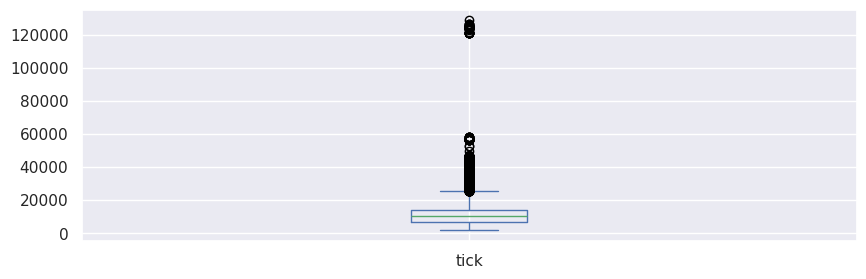

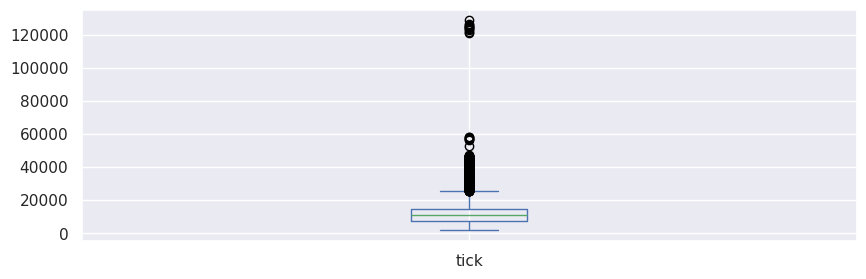

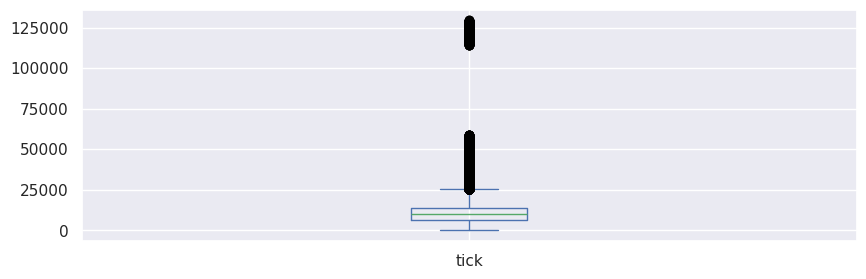

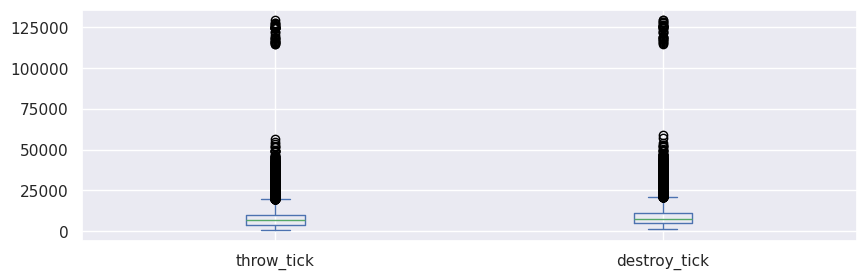

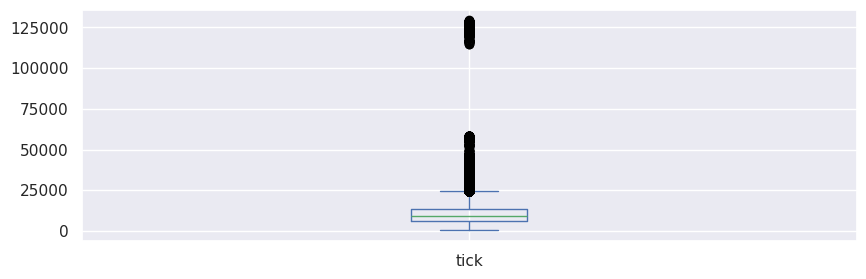

In [7]:
fig,ax = plt.subplots(figsize=(8,3))
for df in all_idx_df:
    tick_cols = [col for col in df.columns if "tick" in col]
    if tick_cols:
        df.loc[:,tick_cols].plot.box(title="")
        plt.show()

In [8]:
# Loop through each unique match+round combination
for idx in idx_wf_df.index.unique():
    round_wf = idx_wf_df.loc[idx].copy()  # Make a copy to avoid SettingWithCopyWarning
    
    round_d = idx_d_df.loc[idx].copy()
        
        
    round_wf['combo_key'] = round_wf['tick'].astype(str) + '_' + round_wf['player_steam_id'].astype('float64')\
    .astype(str)
    round_d['combo_key'] = round_d['tick'].astype(str) + '_' + round_d['attacker_steam_id'].astype("float64")\
    .astype(str)
    
    round_wf['shot_connected'] = round_wf['combo_key'].isin(round_d['combo_key'].values)

    round_wf.drop('combo_key', axis=1, inplace=True)
    
    if len(round_wf) > 0:
        if isinstance(idx_wf_df.loc[idx], pd.Series):
            idx_wf_df.loc[idx, 'shot_connected'] = round_wf['shot_connected'].iloc[0]
        else:
            idx_wf_df.loc[idx, 'shot_connected'] = round_wf['shot_connected'].values

In [9]:
# Loop through each unique match+round combination
count = 0
for idx in idx_g_df.index.unique():
    round_g = idx_g_df.loc[idx].copy()
    
    round_d = idx_d_df.loc[idx].copy()
    round_d = round_d[round_d.weapon_class=="Grenade"]

    round_g["grenade_connected"] = round_g.thrower_steam_id.isin(round_d.attacker_steam_id.values)

    idx_g_df.loc[idx,"grenade_connected"]=round_g.grenade_connected.values

# analysis over single round

In [10]:
selected_map = 'de_mirage'

In [11]:
map_data = all_map_data[selected_map]
selected_matches = matches_df[matches_df.map_name == selected_map]
display(selected_matches.head())
selected_match = selected_matches.iloc[0]
selected_round = 5
sel_idx = (selected_match.match_id,selected_round)

client_name   map_name  tick_rate  playback_ticks  playback_frames_count  \
0   GOTV Demo  de_mirage        127          343251                 342767   
0   GOTV Demo  de_mirage        127          471790                 471564   
0   GOTV Demo  de_mirage        127          426251                 425998   
0   GOTV Demo  de_mirage        127          441259                 440692   
0   GOTV Demo  de_mirage        127          493224                 492014   

   parsed_to_frame_idx                              match_id  \
0               342784  0839a031-0e2c-4c03-b4bc-b5ba05fe669a   
0               471581  0a075b4d-576e-46f2-b944-fe9542faee54   
0               426016  a98ffca7-e968-4a54-9e8f-22f101c2502b   
0               440707  a56115fd-a0ba-4eea-a618-91fd6c57177c   
0               492029  f218743d-5e8b-436e-91bd-b7b3664c56c3   

                                demo_id                  competition_name  \
0  01746483-b3bd-4e4b-a2f2-0de97b17600d            PGL Major Antwerp 2022   
0  04f0fb8f-a4d7-497c-857e-316300fadee3                 IEM Katowice 2022   
0  022866a3-090e-42eb-ab8e-aa553a575ada                 IEM Katowice 2021   
0  015f7c8d-2bc0-4d83-88e7-60648d2b221c  BLAST Premier Fall Showdown 2021   
0  0418eb19-853e-4b56-955c-d3eedf2b7e12   BLAST Premier Spring Final 2021   

                                            hltv_url     match_date  \
0  https://www.hltv.org/matches/2356160/heroic-vs...  1652781600000   
0  https://www.hltv.org/matches/2354381/furia-vs-...  1645124400000   
0  https://www.hltv.org/matches/2346573/faze-vs-f...  1613905200000   
0  https://www.hltv.org/matches/2351973/heroic-vs...  1634034600000   
0  https://www.hltv.org/matches/2349173/natus-vin...  1623853200000   

                                          match_name  
0          heroic-vs-vitality-pgl-major-antwerp-2022  
0                furia-vs-astralis-iem-katowice-2022  
0                    faze-vs-furia-iem-katowice-2021  
0  heroic-vs-poggerz-blast-premier-fall-showdown-...  
0  natus-vincere-vs-faze-blast-premier-spring-fin...

## location based analysis over single round

### transform functions
so data fit the plotting format

In [12]:
def transform_coord(map_data,player_loc,x_col="x",y_col="y"):
    result = player_loc.copy()
        
    pos_x = map_data["pos_x"]
    pos_y = map_data["pos_y"]
    scale = map_data["scale"]

    result[x_col] = (result[x_col] - pos_x) / scale
    result[y_col] = image_dim - (pos_y - result[y_col]) / scale

    return result

#### transform coordinates
to transform for plotting in the map

In [13]:
def transform_coords(map_data,player_loc,status):
    tf = player_loc.copy()
    for st in status:
        tf = transform_coord(map_data,tf,x_col=f"{st}_x",y_col=f"{st}_y")
    return tf

In [14]:
def transform_flash(flashes):
    flashers_cols = [col for col in flashes.columns
                     if not (col.startswith('player_') or col == 'flash_duration')]
    flashers = flashes.loc[:, flashers_cols]
    
    flasheds_cols = [col for col in flashes.columns if not col.startswith('attacker_')]
    flasheds = flashes.loc[:, flasheds_cols]
    
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=pd.errors.SettingWithCopyWarning)
        flashers.loc[:, "status"] = "flasher"
        flasheds.loc[:, "status"] = "flashed"
    
    flashers.columns = [col.replace("attacker_", "") if col != "attacker_side" else col 
                        for col in flashers.columns]
    flasheds.columns = [col.replace("player_", "") if col != "player_side" else col 
                        for col in flasheds.columns]
    
    result = pd.concat([flashers.drop_duplicates(), flasheds.drop_duplicates()])
    result["side"] = result["attacker_side"].fillna(result["player_side"])
    result.sort_values(["tick"],inplace=True)
    
    subset_col = [col for col in result.columns if col not in ["status","flash_duration"]]
    print(subset_col)
    dup_idx = result.duplicated(subset=subset_col)
    keep_idx = result.duplicated(subset=subset_col,keep="last")
    result.loc[dup_idx,"status"] = "both"
    return result.loc[~keep_idx,:]

#### transform action
again, to fit the plotting function and cleaner look, (dim reduce)

In [15]:
def transform_actions(actions: pd.DataFrame, 
                      status: List[str], 
                      status_extra_cols: Dict[str, List[str]] = {},
                      status_code: Dict[str, str] = {},
                      common_extra_cols: List[str] = [],
                      rename_col:Dict[str,str] = {},
                      check_dup_without_cols: List[str] = [],
                      keep: str = "first",
                      assign_dup: dict = {},
                     drop_na_cols: List[str] = []) -> pd.DataFrame:
    """Transforms action data.

    This function processes action data, potentially enriching it with status
    information, handling duplicates, and adding common extra columns.

    Args:
        actions (pd.DataFrame): The action data to transform.
        status (List[str]): Status information to merge with the action data.
        status_extra_cols (Dict[str, List[str]], optional): Extra columns from the
            status data to include in the transformed output. Defaults to {}.
        status_code (Dict[str, str], optional): A mapping to use when
            processing status codes. Defaults to {}.
        common_extra_cols (List[str], optional): A list of extra columns to add
            to the output. Defaults to [].
        check_dup_cols (List[str], optional): Columns to check for duplicates.
            Defaults to [].
        keep (str, optional): How to handle duplicates. See the pandas
            'DataFrame.drop_duplicates' keep parameter. Defaults to "first".
        assign_dup (dict, optional): How to assign values to duplicates.
            Defaults to {}.

    Returns:
        pd.DataFrame: The transformed action data.
    """
    keep_opts = {"first" : "last","last":"first"}
    result = pd.DataFrame()
    for st in status:
        st_cols = []
        extra_cols = status_extra_cols.get(st,[])
        for col in actions.columns:
            if col.startswith(st):
                st_cols.append(col)

            if col in extra_cols:
                st_cols.append(col)

            if col in common_extra_cols:
                st_cols.append(col)
        st_df = actions.loc[:,st_cols]

        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", category=pd.errors.SettingWithCopyWarning)
            code = status_code.get(st,None)
            st_df.loc[:, "status"] = code if code is not None else st

        new_cols = []
        for col in st_df.columns:
            if col == f"{st}_side":
                new_cols.append(col)
                continue
            replaced_col = col.replace(f"{st}_","")
            new_cols.append(rename_col.get(replaced_col,replaced_col))
        st_df.columns = new_cols
        # st_df.columns = [col.replace(f"{st}_","") if col != f"{st}_side" else col
        #                 for col in st_df.columns]

        result = pd.concat([result.drop_duplicates(),
                            st_df.drop_duplicates()
                           ])

    side = result[f"{status[0]}_side"]
    for st in status[1:]:
        side = side.fillna(result[f"{st}_side"])
    result["side"] = side
    if check_dup_without_cols is not None and check_dup_without_cols:
        check_dup_cols = [col for col in result.columns if col not in check_dup_without_cols]
        dup_idx = result.duplicated(subset=check_dup_cols,keep=keep_opts[keep])
        keep_idx = result.duplicated(subset=check_dup_cols,keep=keep)
        for key,value in assign_dup.items():
            result.loc[dup_idx,key] = value

        result = result.loc[~keep_idx,:]
        
    return result

### plotting functions

In [16]:
def plot_map(map_name,fig_size,fig=None,ax=None):
    fig,ax = plt.subplots(figsize=fig_size)
    map_img = plt.imread(f".awpy/maps/{map_name}.png")
    ax.imshow(map_img,extent=[0,image_dim,0,image_dim])
    ax.set_xlim(0, image_dim)
    ax.set_ylim(0, image_dim)
    ax.set_title(map_name.title())
    return fig,ax

In [17]:
def count_colorbar(fig):
    result = 0
    for ax in fig.axes:
        if "colorbar" in ax.get_label():
            result += 1
    return result

In [18]:
import matplotlib.pyplot as plt
import numpy as np

def plot_loc_unicode(player_loc, 
                     gradient_by, 
                     size,
                     color_by=None,
                     color_dict=None,
                     default_color="viridis",  # Default colormap when color_by is None
                     alpha=0.5,
                     marker_by=None,
                     marker_dict=None,
                     default_marker="o",       # Default marker when marker_by is None
                     fig=None, ax=None):

    if fig is None and ax is None:
        fig, ax = plt.subplots(figsize=(10, 8))

    selected_col = ["x", "y", gradient_by]
    if color_by is not None:
        selected_col.append(color_by)
    if marker_by is not None:
        selected_col.append(marker_by)

    transformed = player_loc.reset_index()[selected_col]

    # Normalize gradient
    vmin = transformed[gradient_by].min()
    vmax = transformed[gradient_by].max()
    norm = plt.Normalize(vmin=vmin, vmax=vmax)

    if color_by is not None:
        transformed[color_by] = transformed[color_by].str.lower()

    side = ['left', 'right']
    n_colorbar = count_colorbar(fig)

    previous_cmap = plt.get_cmap(default_color)  # Initial cmap

    for idx, row in transformed.iterrows():
        # Determine colormap
        if color_by is not None and pd.notna(row[color_by]):
            color_key = row[color_by]
            if color_key in color_dict:
                cmap = plt.get_cmap(color_dict[color_key])
                previous_cmap = cmap
            else:
                cmap = previous_cmap
        else:
            cmap = previous_cmap

        # Normalize and get color
        color_value = norm(row[gradient_by])
        color = cmap(color_value)

        # Determine marker
        if marker_by is None:
            marker_char = default_marker
        else:
            marker_key = row[marker_by]
            marker_char = marker_dict.get(marker_key, default_marker)

        ax.text(row["x"], row["y"], marker_char,
                fontsize=size, color=color, ha='center', va='center',
                alpha=alpha)

    ax.set_xlabel("X Coordinate (pixels)")
    ax.set_ylabel("Y Coordinate (pixels)")

    # Add colorbars if color_by is provided
    if color_by is not None:
        for idx, (color_cat, cmap_name) in enumerate(list(color_dict.items())[:2-n_colorbar]):
            positions = transformed[transformed[color_by] == color_cat]
            dummy_scatter = ax.scatter(positions['x'], positions['y'],
                                       c=positions[gradient_by],
                                       cmap=cmap_name, s=0, alpha=.5,
                                       norm=norm)
            cbar = fig.colorbar(dummy_scatter, ax=ax, location=side[idx], pad=0.02,
                                fraction=0.046, shrink=0.6)
            cbar.set_label(f"{color_cat.upper()} {gradient_by.title()}", fontsize=8)
            cbar.ax.tick_params(labelsize=7)

    return fig, ax


In [19]:
def plot_line(actions,status1,status2,
              gradient_by,
              color_by=None,color_dict={},default_color="Greys",
              linewidth=1,alpha=1,
             fig=None,ax=None):
    if fig is None and ax is None:
        fig,ax = plt.subplots(figsize=(10,8))
        
    vmin = actions[gradient_by].min()
    vmax = actions[gradient_by].max()
    norm = plt.Normalize(vmin=vmin, vmax=vmax)
    
    for idx,row in actions.iterrows():
        cmap = plt.get_cmap(
            color_dict.get(row[color_by],default_color) if color_by is not None else default_color
        )
        
        color_value = norm(row[gradient_by])
        color = cmap(color_value)
        
        ax.plot([row[f"{status1}_x"],row[f"{status2}_x"]],
                [row[f"{status1}_y"],row[f"{status2}_y"]],
               alpha=alpha,linewidth=linewidth,
               color=color)

    return fig,ax

### test plotting functions with players' location and flashes' location

51799 70859


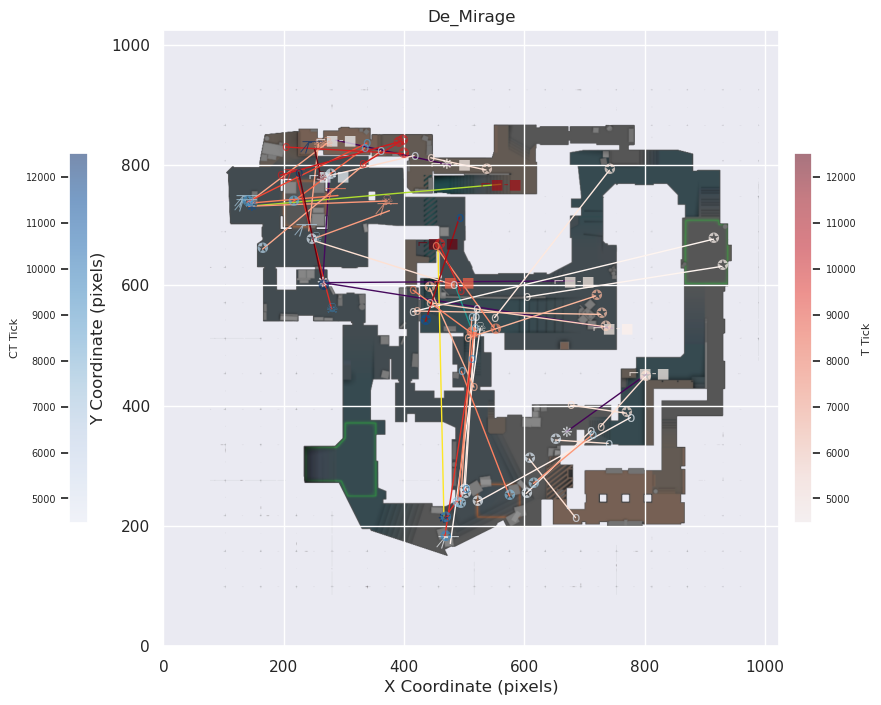

In [20]:
min_tick,max_tick = idx_r_df.loc[sel_idx][["start_tick","end_tick"]].values
print(min_tick,max_tick)

tf_f_co = transform_coords(map_data,
                          idx_f_df.loc[sel_idx],
                         ["attacker","player"])
transformed_flash = transform_actions(tf_f_co,
                 ["attacker","player"],
                 {"player" : ["flash_duration",]},
                 {"attacker" : "flasher","player" : "flashee"},
                  check_dup_without_cols=["status","flash_duration","attacker_side","player_side"],
                  assign_dup={"status":"both"},
                 common_extra_cols = ["tick"],
                 )

tf_k_co = transform_coords(map_data,idx_k_df.loc[sel_idx],["attacker","victim"])
transformed_kills = transform_actions(tf_k_co,
                 ["attacker","victim"],
                  check_dup_without_cols=["attacker_side","victim_side"],
                  assign_dup={"status":"suicide"},
                 common_extra_cols = ["tick"],
                )
                                      
tf_g_co = transform_coords(map_data,idx_g_df.loc[sel_idx],["thrower","grenade"])
transformed_grenades = transform_actions(tf_g_co,
                 ["thrower","grenade"],
                 common_extra_cols = ["throw_tick"],
                                     )
side_color = {
    "ct" : "Blues",
    "t" : "Reds"
}

flash_marker = {
    "flasher" : "$\u274B$",
    "flashee" : "⌐■-■",
    "both" : "⌐$\u274B$-■"
}

kill_marker = {
    "attacker" : "/̸̅̅ ̆̅ ̅̅ ̅̅",
    "victim" : "$\u2620$",
    "suicide" : "$\u2622$"
}

grenade_marker = {
    "thrower" : "✪",
    "victim" : "☄",
}
img_fig, img_ax = plot_map(selected_map, (10, 8))

flash_fig, flash_ax = plot_loc_unicode(transformed_flash, 
                                      gradient_by="tick", 
                                      size=10,
                                      color_by="side",
                                      color_dict=side_color,
                                      marker_by="status",
                                      marker_dict=flash_marker,
                                      alpha=0.7,
                                      fig=img_fig, 
                                      ax=img_ax)

cf_fig,cf_ax = plot_line(tf_f_co,"attacker","player","tick",default_color="viridis",fig=flash_fig,ax=flash_ax)      

kill_fig, kill_ax = plot_loc_unicode(transformed_kills, 
                                      gradient_by="tick", 
                                      size=10,
                                      color_by="side",
                                      color_dict=side_color,
                                      marker_by="status",
                                      marker_dict=kill_marker,
                                      alpha=0.7,
                                      fig=cf_fig, 
                                      ax=cf_ax)

ck_fig,ck_ax = plot_line(tf_k_co,"attacker","victim","tick",default_color="Reds",fig=kill_fig,ax=kill_ax)      
grenade_fig, grenade_ax = plot_loc_unicode(transformed_grenades, 
                                      gradient_by="throw_tick", 
                                      size=10,
                                      color_by="side",
                                      color_dict=side_color,
                                      marker_by="status",
                                      marker_dict=grenade_marker,
                                      alpha=0.7,
                                      fig=ck_fig, 
                                      ax=ck_ax)

cg_fig,cg_ax = plot_line(tf_g_co,"thrower","grenade","throw_tick",default_color="Reds",fig=grenade_fig,ax=grenade_ax)      
plt.show()

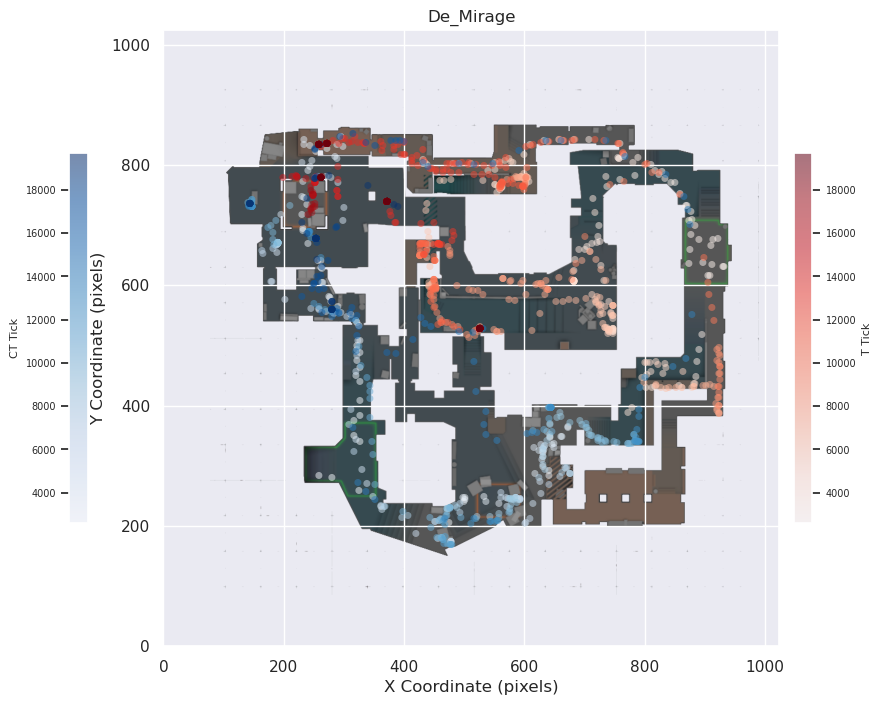

In [21]:
transformed_loc = transform_coord(map_data,
                                  idx_pf_df.loc[sel_idx].iloc[::2])
img_loc_fig,img_loc_ax =  plot_map(selected_map, (10, 8))

loc_fig, loc_ax = plot_loc_unicode(transformed_loc, 
                                  gradient_by="tick",
                                  size=5,
                                  color_by="side",
                                  color_dict=side_color,
                                  default_marker="$\u2B24$",
                                  fig=img_loc_fig, 
                                  ax=img_loc_ax)

### interactive plotting

In [22]:
from ipywidgets import interact, IntSlider, Layout, HBox, VBox, FloatSlider, Checkbox
import ipywidgets as widgets
from IPython.display import display

# This function definition assumes plot_map, plot_loc_unicode, plot_line, and transform_coords 
# functions are already defined elsewhere in your code

def plot_actions_by_max_tick(max_tick=100, 
                            show_flash=True, 
                            show_kills=True, 
                            show_grenades=True,
                            flash_alpha=0.7,
                            kill_alpha=0.7,
                            grenade_alpha=0.7,
                            flash_size=10,
                            kill_size=10,
                            grenade_size=10,
                            show_lines=True):
    """
    Interactive plot of game actions filtered by maximum tick
    Everything from tick 0 up to max_tick will be shown
    """
    # Set min_tick to the minimum value or 0
    min_tick = global_min_tick
    
    # Clear previous plots
    plt.figure(figsize=(12, 10))
    
    # Start with map
    img_fig, img_ax = plot_map(selected_map, (12, 10))
    current_fig, current_ax = img_fig, img_ax
    
    # Filter actions by tick range
    flash_mask = (transformed_flash['tick'] >= min_tick) & (transformed_flash['tick'] <= max_tick)
    kill_mask = (transformed_kills['tick'] >= min_tick) & (transformed_kills['tick'] <= max_tick)
    grenade_mask = (transformed_grenades['throw_tick'] >= min_tick) & (transformed_grenades['throw_tick'] <= max_tick)
    
    filtered_flash = transformed_flash[flash_mask] if isinstance(transformed_flash, pd.DataFrame) else transformed_flash
    filtered_kills = transformed_kills[kill_mask] if isinstance(transformed_kills, pd.DataFrame) else transformed_kills
    filtered_grenades = transformed_grenades[grenade_mask] if isinstance(transformed_grenades, pd.DataFrame) else transformed_grenades

    flash_count = filtered_flash.attacker_side.notnull().sum()
    kill_count = filtered_kills.attacker_side.notnull().sum()
    grenade_count = filtered_grenades.thrower_side.notnull().sum()
    
    # Plot flashes if requested
    if show_flash and len(filtered_flash) > 0:
        flash_fig, flash_ax = plot_loc_unicode(filtered_flash, 
                                          gradient_by="tick", 
                                          size=flash_size,
                                          color_by="side",
                                          color_dict=side_color,
                                          marker_by="status",
                                          marker_dict=flash_marker,
                                          alpha=flash_alpha,
                                          fig=current_fig, 
                                          ax=current_ax)
        current_fig, current_ax = flash_fig, flash_ax
        
        # Plot flash lines if requested
        if show_lines:
            flash_co_mask = (tf_f_co["tick"] >= min_tick) & (tf_f_co["tick"] <= max_tick)
            filtered_f_co = tf_f_co[flash_co_mask] if isinstance(tf_f_co, pd.DataFrame) else tf_f_co
            if len(filtered_f_co) > 0:
                cf_fig, cf_ax = plot_line(filtered_f_co, "attacker", "player", "tick", 
                                         default_color="viridis", fig=current_fig, ax=current_ax)
                current_fig, current_ax = cf_fig, cf_ax
    
    # Plot kills if requested
    if show_kills and len(filtered_kills) > 0:
        kill_fig, kill_ax = plot_loc_unicode(filtered_kills, 
                                          gradient_by="tick", 
                                          size=kill_size,
                                          color_by="side",
                                          color_dict=side_color,
                                          marker_by="status",
                                          marker_dict=kill_marker,
                                          alpha=kill_alpha,
                                          fig=current_fig, 
                                          ax=current_ax)
        current_fig, current_ax = kill_fig, kill_ax
        
        # Plot kill lines if requested
        if show_lines:
            kill_co_mask = (tf_k_co["tick"] >= min_tick) & (tf_k_co["tick"] <= max_tick)
            filtered_k_co = tf_k_co[kill_co_mask] if isinstance(tf_k_co, pd.DataFrame) else tf_k_co
            if len(filtered_k_co) > 0:
                ck_fig, ck_ax = plot_line(filtered_k_co, "attacker", "victim", "tick", 
                                         default_color="Reds", fig=current_fig, ax=current_ax)
                current_fig, current_ax = ck_fig, ck_ax
    
    # Plot grenades if requested
    if show_grenades and len(filtered_grenades) > 0:
        grenade_fig, grenade_ax = plot_loc_unicode(filtered_grenades, 
                                              gradient_by="throw_tick", 
                                              size=grenade_size,
                                              color_by="side",
                                              color_dict=side_color,
                                              marker_by="status",
                                              marker_dict=grenade_marker,
                                              alpha=grenade_alpha,
                                              fig=current_fig, 
                                              ax=current_ax)
        current_fig, current_ax = grenade_fig, grenade_ax
        
        # Plot grenade lines if requested
        if show_lines:
            grenade_co_mask = (tf_g_co["throw_tick"] >= min_tick) & (tf_g_co["throw_tick"] <= max_tick)
            filtered_g_co = tf_g_co[grenade_co_mask] if isinstance(tf_g_co, pd.DataFrame) else tf_g_co
            if len(filtered_g_co) > 0:
                cg_fig, cg_ax = plot_line(filtered_g_co, "thrower", "grenade", "throw_tick", 
                                         default_color="Greens", fig=current_fig, ax=current_ax)
    
    # Add title with tick range info
    plt.title(f'Game Actions (Tick range: {min_tick} - {max_tick})', fontsize=14)

    # Show number of events in the filtered range
    
    # Add a text box with event counts
    info_text = f"Events in range: {flash_count} flashes, {kill_count} kills, {grenade_count} grenades"
    plt.figtext(0.5, 0.01, info_text, ha='center', fontsize=12, bbox=dict(facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    plt.show()


global_min_tick = idx_pf_df.loc[sel_idx].tick.min()
global_max_tick = idx_pf_df.loc[sel_idx].tick.max()


# Create the interactive widgets
max_tick_slider = IntSlider(
    value=global_max_tick,
    min=global_min_tick,
    max=global_max_tick,
    step=1,
    description='Max Tick:',
    style={'description_width': 'initial'},
    layout=Layout(width='600px')
)

flash_checkbox = Checkbox(
    value=True,
    description='Show Flashes',
    style={'description_width': 'initial'}
)

kill_checkbox = Checkbox(
    value=True,
    description='Show Kills',
    style={'description_width': 'initial'}
)

grenade_checkbox = Checkbox(
    value=True,
    description='Show Grenades',
    style={'description_width': 'initial'}
)

lines_checkbox = Checkbox(
    value=True,
    description='Show Lines',
    style={'description_width': 'initial'}
)

flash_alpha_slider = FloatSlider(
    value=0.7,
    min=0.1,
    max=1.0,
    step=0.1,
    description='Flash Opacity:',
    style={'description_width': 'initial'}
)

kill_alpha_slider = FloatSlider(
    value=0.7,
    min=0.1,
    max=1.0,
    step=0.1,
    description='Kill Opacity:',
    style={'description_width': 'initial'}
)

grenade_alpha_slider = FloatSlider(
    value=0.7,
    min=0.1,
    max=1.0,
    step=0.1,
    description='Grenade Opacity:',
    style={'description_width': 'initial'}
)

flash_size_slider = IntSlider(
    value=10,
    min=5,
    max=30,
    step=1,
    description='Flash Size:',
    style={'description_width': 'initial'}
)

kill_size_slider = IntSlider(
    value=10,
    min=5,
    max=30,
    step=1,
    description='Kill Size:',
    style={'description_width': 'initial'}
)

grenade_size_slider = IntSlider(
    value=10,
    min=5,
    max=30,
    step=1,
    description='Grenade Size:',
    style={'description_width': 'initial'}
)

# Organize the widgets into a more user-friendly layout
tick_controls = VBox([max_tick_slider])
event_controls = HBox([flash_checkbox, kill_checkbox, grenade_checkbox, lines_checkbox])

flash_controls = VBox([flash_alpha_slider, flash_size_slider])
kill_controls = VBox([kill_alpha_slider, kill_size_slider])
grenade_controls = VBox([grenade_alpha_slider, grenade_size_slider])

appearance_controls = HBox([flash_controls, kill_controls, grenade_controls])

all_controls = VBox([tick_controls, event_controls, appearance_controls])

# Create the interactive output
interactive_output = widgets.interactive_output(
    plot_actions_by_max_tick,
    {
        'max_tick': max_tick_slider,
        'show_flash': flash_checkbox,
        'show_kills': kill_checkbox,
        'show_grenades': grenade_checkbox,
        'flash_alpha': flash_alpha_slider,
        'kill_alpha': kill_alpha_slider,
        'grenade_alpha': grenade_alpha_slider,
        'flash_size': flash_size_slider,
        'kill_size': kill_size_slider,
        'grenade_size': grenade_size_slider,
        'show_lines': lines_checkbox
    }
)

display(all_controls)
display(interactive_output)



Output()

# player stats

In [23]:
# import sys
# print(idx_pf_df.index)
# for idx in idx_pf_df.index.unique():
#     sel_pf = idx_pf_df.loc[idx]
#     print(f"working on {idx}",end="\r")
#     p_count = len(sel_pf.steam_id.unique())
#     if p_count != 10:
#         print(f"at {idx} player missing, only {p_count} player")
#     sys.stdout.flush()

In [24]:
def get_players_stat(idx):
    
    all_players = idx_pf_df.loc[idx][["steam_id","name","team",]]\
    .drop_duplicates().set_index(["name"])
    max_round = idx_pf_df.loc[idx].index.max()
    
    sel_k = idx_k_df.loc[idx]
    sel_d = idx_d_df.loc[idx]
    
    
    for name in all_players.index:
        sel_player_kill_mask = sel_k.attacker_name == name
        sel_player_death_mask = sel_k.victim_name == name
        sel_player_assist_mask = sel_k.assister_name == name
        sel_player_flash_assist_mask = sel_k.flash_thrower_name == name
        sel_player_traded_mask = sel_k.player_traded_name == name
    
        
        k = sel_player_kill_mask.groupby("round_num").any()
        a = sel_player_assist_mask.groupby("round_num").any() | sel_player_flash_assist_mask.groupby("round_num").any()
        s = ~(sel_player_death_mask.groupby("round_num").any())
        t = sel_player_traded_mask.groupby("round_num").any()
    
        sel_player_kill = sel_k[sel_player_kill_mask]
        sel_player_death = sel_k[sel_player_death_mask]
        sel_player_assist = sel_k[sel_player_assist_mask]
        sel_player_flash_assist = sel_k[sel_player_flash_assist_mask]
        
        # display(sel_player_death)
        
        all_players.loc[name,"kills"] = len(sel_player_kill)
        all_players.loc[name,"deaths"] = len(sel_player_death)
        all_players.loc[name,"assist"] = len(sel_player_assist)
        all_players.loc[name,"flash_assist"] = len(sel_player_flash_assist)
        all_players.loc[name,"first_kill"] = sel_player_kill.is_first_kill.sum()
        all_players.loc[name,"first_death"] = sel_player_death.is_first_kill.sum()
        all_players.loc[name,"kast"] = (k|a|s|t).sum() / max_round
        
    
        sel_player_damage = sel_d[sel_d.attacker_name == name]
        sel_player_dmg_round = sel_player_damage.groupby("round_num").agg(
            rtd=("total_damage","sum")
        )
        all_players.loc[name,"ADR"] =sel_player_dmg_round.rtd.sum() / max_round
    return all_players
get_players_stat(selected_match.match_id)
    

steam_id      team  kills  deaths  assist  flash_assist  \
name                                                                         
misutaaa  76561198081528911  Vitality   17.0    18.0     0.0           1.0   
Magisk    76561197983956651  Vitality   14.0    18.0     2.0           4.0   
dupreeh   76561198004854956  Vitality   12.0    18.0     6.0           0.0   
ZywOo     76561198113666193  Vitality   14.0    17.0     5.0           4.0   
apEX      76561197989744167  Vitality   17.0    18.0     6.0           0.0   
TeSeS     76561197996678278    Heroic   10.0    15.0     5.0           2.0   
cadiaN    76561198004115516    Heroic   19.0    15.0     3.0           4.0   
sjuush    76561198160709585    Heroic   12.0    14.0     8.0           1.0   
stavn     76561198022365638    Heroic   26.0    16.0     3.0           1.0   
refrezh   76561198064864198    Heroic   22.0    15.0     2.0           6.0   

          first_kill  first_death      kast         ADR  
name                                                     
misutaaa         2.0          5.0  0.521739   95.565217  
Magisk           1.0          2.0  0.652174   84.608696  
dupreeh          0.0          3.0  0.608696   91.956522  
ZywOo            3.0          1.0  0.782609  131.173913  
apEX             2.0          4.0  0.652174  140.956522  
TeSeS            1.0          3.0  0.739130   79.217391  
cadiaN           4.0          1.0  0.782609  102.869565  
sjuush           3.0          0.0  0.826087   95.652174  
stavn            4.0          1.0  0.695652  181.521739  
refrezh          3.0          3.0  0.826087  121.391304

# loc change over action

/tmp/nix-shell.3ouUTV/ipykernel_18666/2267384705.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sel_team_loc = sel_loc.groupby(["side", "tick"]).agg(avg_loc_change=("loc_change", "mean"))


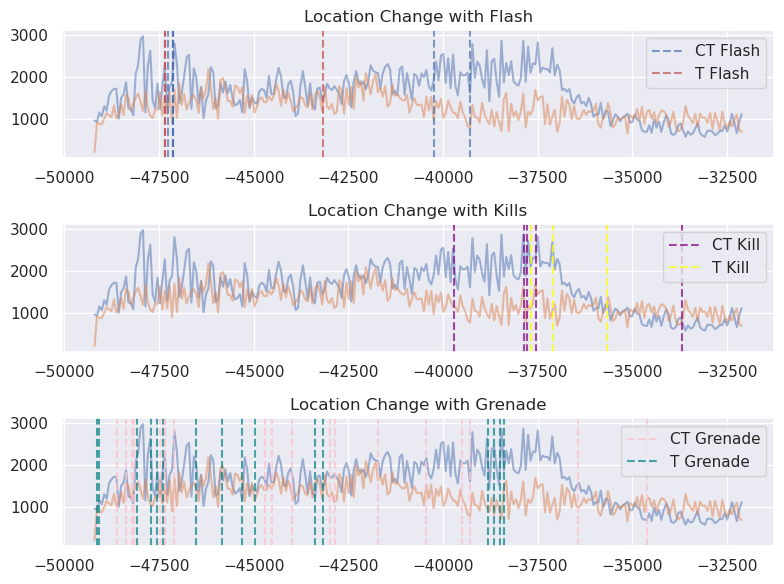

In [25]:
import matplotlib.pyplot as plt

# Create a figure with 3 subplots vertically
fig, axes = plt.subplots(3, 1, figsize=(8, 6))  # 3 rows, 1 column, adjust figsize as needed

# Location Change Data (Calculate only once)
sel_loc = idx_pf_df.loc[sel_idx][["tick", "side", "x", "y"]]
first_tick = idx_r_df.loc[sel_idx]["start_tick"]
sel_loc["tick"] = sel_loc["tick"] - first_tick
curr_x = sel_loc.iloc[1:]["x"]
prev_x = sel_loc.iloc[:-1]["x"]
curr_y = sel_loc.iloc[1:]["y"]
prev_y = sel_loc.iloc[:-1]["y"]
loc_change = [0] + list(np.sqrt((curr_x - prev_x) ** 2 + (curr_y - prev_y) ** 2))
sel_loc["loc_change"] = loc_change
sel_team_loc = sel_loc.groupby(["side", "tick"]).agg(avg_loc_change=("loc_change", "mean"))

ct_loc_df = sel_team_loc.loc["CT"].reset_index()
t_loc_df = sel_team_loc.loc["T"].reset_index()

# 1st Subplot: Location Change with Flash
axes[0].plot(ct_loc_df["tick"], ct_loc_df["avg_loc_change"], label="CT Avg. Loc. Change", alpha=0.5)
axes[0].plot(t_loc_df["tick"], t_loc_df["avg_loc_change"], label="T Avg. Loc. Change", alpha=0.5)

sel_f = idx_f_df.loc[sel_idx].reset_index()
sel_f["tick"] = sel_f["tick"] - first_tick
for attacker_side in ["CT", "T"]:
    flash_ticks = sel_f[sel_f.attacker_side == attacker_side]["tick"]
    for tick_value in flash_ticks:
        if attacker_side == "CT":
            ct_f = axes[0].axvline(x=tick_value, color='b', linestyle='--', alpha=0.7, label="CT Flash")
        else:
            t_f = axes[0].axvline(x=tick_value, color='r', linestyle='--', alpha=0.7, label="T Flash")
axes[0].set_title("Location Change with Flash")
axes[0].legend(handles = [ct_f,t_f])

# 2nd Subplot: Location Change with Kills
axes[1].plot(ct_loc_df["tick"], ct_loc_df["avg_loc_change"], label="CT Avg. Loc. Change", alpha=0.5)  # Use pre-calculated location change
axes[1].plot(t_loc_df["tick"], t_loc_df["avg_loc_change"], label="T Avg. Loc. Change", alpha=0.5)  # Use pre-calculated location change

sel_k = idx_k_df.loc[sel_idx].reset_index()
sel_k["tick"] = sel_k["tick"] - first_tick
for attacker_side in ["CT", "T"]:
    kill_ticks = sel_k[sel_k.attacker_side == attacker_side]["tick"]
    for tick_value in kill_ticks:
        if attacker_side == "CT":
            ct_k = axes[1].axvline(x=tick_value, color="purple", linestyle='--', alpha=0.7, label="CT Kill")
        else:
            t_k = axes[1].axvline(x=tick_value, color='yellow', linestyle='--', alpha=0.7, label="T Kill")
axes[1].set_title("Location Change with Kills")
axes[1].legend(handles=[ct_k,t_k])

# 3rd Subplot: Location Change with Grenade
axes[2].plot(ct_loc_df["tick"], ct_loc_df["avg_loc_change"], label="CT Avg. Loc. Change", alpha=0.5)  # Use pre-calculated location change
axes[2].plot(t_loc_df["tick"], t_loc_df["avg_loc_change"], label="T Avg. Loc. Change", alpha=0.5)  # Use pre-calculated location change

sel_g = idx_g_df.loc[sel_idx].reset_index()
sel_g["throw_tick"] = sel_g["throw_tick"] - first_tick
for thrower_side in ["CT", "T"]:
    grenade_ticks = sel_g[sel_g.thrower_side == thrower_side]["throw_tick"]
    for tick_value in grenade_ticks:
        if thrower_side == "CT":
            ct_g = axes[2].axvline(x=tick_value, color="pink", linestyle='--', alpha=0.7, label="CT Grenade")
        else:
            t_g = axes[2].axvline(x=tick_value, color='teal', linestyle='--', alpha=0.7, label="T Grenade")
axes[2].set_title("Location Change with Grenade")
axes[2].legend(handles=[ct_g,t_g])

# Adjust layout to prevent overlapping titles/labels
plt.tight_layout()

# Show the plot
plt.show()


# statistical analysis over rounds

## extracting data for each round

In [26]:
import re

def convert_to_snake_case(df,prefix):
    # Function to convert a string to snake_case
    def to_snake_case(text,prefix):
        # Convert to lowercase first
        s = text.lower()
        s = re.sub(r'\s+', '_', s)
        s = re.sub(r'[^\w_]', '', s)
        return f"{prefix}{s}"
    
    new_df = df.copy()
    new_df.index = [to_snake_case(idx,prefix) for idx in df.index]
    
    return new_df

In [27]:
warnings.filterwarnings("ignore")

rounds_sum_df = idx_r_df[["n_ticks","bomb_plant_tick","winning_side","round_end_reason",
                     "ct_round_spend_money","ct_buy_type","ct_round_start_eq_val","ct_freeze_time_end_eq_val",
                     "t_round_spend_money","t_buy_type","t_round_start_eq_val","t_freeze_time_end_eq_val"]]

def check_nan(val,default = 0,show=False):
    result =  val if not pd.isna(val) else default
    if show and pd.isna(val):
        print(f"{val} => {result}")
    return result
for idx,row in list(rounds_sum_df.iterrows()):
    if idx in idx_f_df.index:
        sel_f_df = idx_f_df.loc[idx]
        ct_flasher_idx = sel_f_df["attacker_side"] == "CT"
        t_flasher_idx = sel_f_df["attacker_side"] == "T"
        ct_flashed_idx = sel_f_df["player_side"] == "CT"
        t_flashed_idx = sel_f_df["player_side"] == "T"
        
        rounds_sum_df.loc[idx,"ct_flash_opp"] = check_nan(ct_flasher_idx.sum().astype(int),0)
        rounds_sum_df.loc[idx,"t_flash_opp"] = check_nan(t_flasher_idx.sum().astype(int),0)
        rounds_sum_df.loc[idx,"ct_flashed"] = check_nan(ct_flashed_idx.sum().astype(int),0)
        rounds_sum_df.loc[idx,"t_flashed"] = check_nan(t_flashed_idx.sum().astype(int),0)
        
        rounds_sum_df.loc[idx,"ct_avg_flash_duration"] = check_nan(sel_f_df.loc[ct_flashed_idx,"flash_duration"].mean(),0)
        rounds_sum_df.loc[idx,"t_avg_flash_duration"] = check_nan(sel_f_df.loc[t_flashed_idx,"flash_duration"].mean(),0)
    else:
        flash_columns = ["ct_flash_opp", "t_flash_opp", "ct_flashed", "t_flashed", "ct_avg_flash_duration", "t_avg_flash_duration"]
        for col in flash_columns:
            rounds_sum_df.loc[idx, col] = 0

    if idx in idx_k_df.index:
        sel_k_df = idx_k_df.loc[idx]
        ct_atk_idx = sel_k_df["attacker_side"]=="CT"
        t_atk_idx = sel_k_df["attacker_side"]=="T"
        ct_vic_idx = sel_k_df["victim_side"]=="CT"
        t_vic_idx = sel_k_df["victim_side"]=="T"

        ct_n_k = sel_k_df.loc[ct_atk_idx].attacker_steam_id.nunique()
        t_n_k = sel_k_df.loc[t_atk_idx].attacker_steam_id.nunique()

        ct_n_a = sel_k_df.loc[ct_atk_idx].assister_steam_id.nunique(dropna=True)
        t_n_a = sel_k_df.loc[t_atk_idx].assister_steam_id.nunique(dropna=True)

        ct_n_s = 5-ct_vic_idx.sum()
        t_n_s = 5-t_vic_idx.sum()
        
        ct_n_t = sel_k_df.loc[ct_atk_idx].player_traded_steam_id.nunique(dropna=True)
        t_n_t = sel_k_df.loc[t_atk_idx].player_traded_steam_id.nunique(dropna=True)

        ct_kast = max(ct_n_k,ct_n_a,ct_n_s,ct_n_t)
        t_kast = max(t_n_k,t_n_a,t_n_s,t_n_t)
        
        rounds_sum_df.loc[idx,"ct_kills"] = ct_atk_idx.sum().astype(int)
        rounds_sum_df.loc[idx,"t_kills"] = t_atk_idx.sum().astype(int)
        rounds_sum_df.loc[idx,"ct_deaths"] = ct_vic_idx.sum().astype(int)
        rounds_sum_df.loc[idx,"t_deaths"] = t_vic_idx.sum().astype(int)

        # print(sel_k_df.loc[ct_atk_idx,"is_first_kill"].any(),sel_k_df.loc[t_atk_idx,"is_first_kill"].any())

        rounds_sum_df.loc[idx,"ct_first_kill"] = sel_k_df.loc[ct_atk_idx]["is_first_kill"].any().astype(int)
        rounds_sum_df.loc[idx,"t_first_kill"] = sel_k_df.loc[t_atk_idx]["is_first_kill"].any().astype(int)

        rounds_sum_df.loc[idx,"ct_hs_prob"] = check_nan(sel_k_df.loc[ct_atk_idx]["is_headshot"].mean(),0)
        rounds_sum_df.loc[idx,"t_hs_prob"] = check_nan(sel_k_df.loc[t_atk_idx]["is_headshot"].mean(),0)
        
        rounds_sum_df.loc[idx,"ct_trade_prob"] = check_nan(sel_k_df.loc[ct_atk_idx]["is_trade"].mean(),0)
        rounds_sum_df.loc[idx,"t_trade_prob"] = check_nan(sel_k_df.loc[t_atk_idx]["is_trade"].mean(),0)
        
        rounds_sum_df.loc[idx,"ct_flash_kill_prob"] = check_nan(sel_k_df.loc[ct_atk_idx]["victim_blinded"].mean(),0)
        rounds_sum_df.loc[idx,"t_flash_kill_prob"] = check_nan(sel_k_df.loc[t_atk_idx]["victim_blinded"].mean(),0)
        
        rounds_sum_df.loc[idx,"ct_assist_prob"] = check_nan(sel_k_df.loc[ct_atk_idx]["assister_steam_id"].notnull().mean(),0)
        rounds_sum_df.loc[idx,"t_assist_prob"] = check_nan(sel_k_df.loc[t_atk_idx]["assister_steam_id"].notnull().mean(),0)

        rounds_sum_df.loc[idx,"ct_kast_prob"] = ct_kast / 5
        rounds_sum_df.loc[idx,"t_kast_prob"] = t_kast / 5
    if idx in idx_d_df.index:
        sel_d_df = idx_d_df.loc[idx]
        
        ct_atk_idx = sel_d_df["attacker_side"]=="CT"
        t_atk_idx = sel_d_df["attacker_side"]=="T"
        ct_vic_idx = sel_d_df["victim_side"]=="CT"
        t_vic_idx = sel_d_df["victim_side"]=="T"

        rounds_sum_df.loc[idx,"ct_damage_done"] = sel_d_df.loc[ct_atk_idx,"total_damage"].sum().astype(int)
        rounds_sum_df.loc[idx,"t_damage_done"] = sel_d_df.loc[t_atk_idx,"total_damage"].sum().astype(int)
        
        rounds_sum_df.loc[idx,"ct_damage_taken"] = sel_d_df.loc[ct_vic_idx,"total_damage_taken"].sum().astype(int)
        rounds_sum_df.loc[idx,"t_damage_taken"] = sel_d_df.loc[t_vic_idx,"total_damage_taken"].sum().astype(int)

    if idx in idx_wf_df.index:
        sel_wf_df = idx_wf_df.loc[idx]
        
        ct_ply_idx = sel_wf_df["player_side"]=="CT"
        t_ply_idx = sel_wf_df["player_side"]=="T"

        rounds_sum_df.loc[idx,"ct_shot_fires"] = ct_ply_idx.sum().astype(int)
        rounds_sum_df.loc[idx,"t_shot_fires"] = t_ply_idx.sum().astype(int)

        rounds_sum_df.loc[idx,"ct_shot_connected_prob"] = sel_wf_df.loc[ct_ply_idx]["shot_connected"].mean()
        rounds_sum_df.loc[idx,"t_shot_connected_prob"] = sel_wf_df.loc[t_ply_idx]["shot_connected"].mean()
    if idx in idx_g_df.index:
        sel_g_df = idx_g_df.loc[idx]
        ct_g_idx = sel_g_df["thrower_side"]=="CT"
        t_g_idx = sel_g_df["thrower_side"]=="T"

        rounds_sum_df.loc[idx,"ct_grenades_thrown"] = check_nan(ct_g_idx.sum(),0).astype(int)
        rounds_sum_df.loc[idx,"t_grenades_thrown"] = check_nan(t_g_idx.sum(),0).astype(int)

        ct_g_type_counts = convert_to_snake_case(sel_g_df.loc[ct_g_idx].value_counts("grenade_type"),"ct_").fillna(0)
        t_g_type_counts = convert_to_snake_case(sel_g_df.loc[t_g_idx].value_counts("grenade_type"),"t_").fillna(0)

        for col in ct_g_type_counts.index:
            rounds_sum_df.loc[idx,col] = ct_g_type_counts[col]
        for col in t_g_type_counts.index:
            rounds_sum_df.loc[idx,col] = t_g_type_counts[col]
        rounds_sum_df.loc[idx,"ct_grenade_connected_prob"]=check_nan(sel_g_df[ct_g_idx].grenade_connected.mean(),0)
        rounds_sum_df.loc[idx,"t_grenade_connected_prob"]=check_nan(sel_g_df[t_g_idx].grenade_connected.mean(),0)

rounds_sum_df["bomb_plant_tick"].fillna(-1,inplace=True)

In [28]:
# After your existing code, add this section to convert float columns to int
# Get columns that are supposed to be integer counts
count_columns = [
    # Kills, deaths, flash counts, etc.
    'ct_flash_opp', 't_flash_opp', 'ct_flashed', 't_flashed',
    'ct_kills', 't_kills', 'ct_deaths', 't_deaths', 
    'ct_first_kill', 't_first_kill',
    'ct_shot_fires', 't_shot_fires',
    'ct_grenades_thrown', 't_grenades_thrown',
    'ct_he_grenade', 't_he_grenade', 'ct_smoke_grenade', 't_smoke_grenade',
    'ct_flashbang', 't_flashbang', 'ct_molotov', 't_molotov',
    'ct_decoy_grenade', 't_decoy_grenade', 'ct_incendiary_grenade', 't_incendiary_grenade',
    # Add any other count columns here
]

# Convert damage columns which should be integers
damage_columns = [
    'ct_damage_done', 't_damage_done', 
    'ct_damage_taken', 't_damage_taken'
]

# Convert all count columns to int
for col in count_columns + damage_columns:
    if col in rounds_sum_df.columns:
        # Replace any remaining NaN with 0 before converting to int
        rounds_sum_df[col] = rounds_sum_df[col].fillna(0).astype(int)

# Convert bomb_plant_tick to int (already has -1 for NaN)
rounds_sum_df['bomb_plant_tick'] = rounds_sum_df['bomb_plant_tick'].astype(int)

In [29]:
rounds_sum_df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1312 entries, ('bfa9bbbe-bd16-4713-bd99-745378db05cb', 1) to ('816e1612-9d2e-4893-af23-bda90c479598', 17)
Data columns (total 58 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   n_ticks                    1312 non-null   int32   
 1   bomb_plant_tick            1312 non-null   int64   
 2   winning_side               1312 non-null   category
 3   round_end_reason           1312 non-null   category
 4   ct_round_spend_money       1312 non-null   int32   
 5   ct_buy_type                1312 non-null   category
 6   ct_round_start_eq_val      1312 non-null   int16   
 7   ct_freeze_time_end_eq_val  1312 non-null   int32   
 8   t_round_spend_money        1312 non-null   int16   
 9   t_buy_type                 1312 non-null   category
 10  t_round_start_eq_val       1312 non-null   int16   
 11  t_freeze_time_end_eq_val   1312 non-null   int16   
 12  ct_flash

In [30]:
rounds_sum_df[["ct_grenade_connected_prob","t_grenade_connected_prob"]] = rounds_sum_df[["ct_grenade_connected_prob","t_grenade_connected_prob"]].fillna(0)

In [31]:
rounds_sum_df.isnull().sum()

n_ticks                      0
bomb_plant_tick              0
winning_side                 0
round_end_reason             0
ct_round_spend_money         0
ct_buy_type                  0
ct_round_start_eq_val        0
ct_freeze_time_end_eq_val    0
t_round_spend_money          0
t_buy_type                   0
t_round_start_eq_val         0
t_freeze_time_end_eq_val     0
ct_flash_opp                 0
t_flash_opp                  0
ct_flashed                   0
t_flashed                    0
ct_avg_flash_duration        0
t_avg_flash_duration         0
ct_kills                     0
t_kills                      0
ct_deaths                    0
t_deaths                     0
ct_first_kill                0
t_first_kill                 0
ct_hs_prob                   0
t_hs_prob                    0
ct_trade_prob                0
t_trade_prob                 0
ct_flash_kill_prob           0
t_flash_kill_prob            0
ct_assist_prob               0
t_assist_prob                0
ct_kast_

In [32]:
start_round_cols = ["ct_freeze_time_end_eq_val","t_freeze_time_end_eq_val"]

## feature extraction

In [33]:
rounds_sum_df.columns

Index(['n_ticks', 'bomb_plant_tick', 'winning_side', 'round_end_reason',
       'ct_round_spend_money', 'ct_buy_type', 'ct_round_start_eq_val',
       'ct_freeze_time_end_eq_val', 't_round_spend_money', 't_buy_type',
       't_round_start_eq_val', 't_freeze_time_end_eq_val', 'ct_flash_opp',
       't_flash_opp', 'ct_flashed', 't_flashed', 'ct_avg_flash_duration',
       't_avg_flash_duration', 'ct_kills', 't_kills', 'ct_deaths', 't_deaths',
       'ct_first_kill', 't_first_kill', 'ct_hs_prob', 't_hs_prob',
       'ct_trade_prob', 't_trade_prob', 'ct_flash_kill_prob',
       't_flash_kill_prob', 'ct_assist_prob', 't_assist_prob', 'ct_kast_prob',
       't_kast_prob', 'ct_damage_done', 't_damage_done', 'ct_damage_taken',
       't_damage_taken', 'ct_shot_fires', 't_shot_fires',
       'ct_shot_connected_prob', 't_shot_connected_prob', 'ct_grenades_thrown',
       't_grenades_thrown', 'ct_he_grenade', 'ct_decoy_grenade',
       'ct_flashbang', 'ct_incendiary_grenade', 'ct_molotov',
      

### money cols

In [34]:
rounds_sum_df.ct_buy_type

match_id                              round_num
bfa9bbbe-bd16-4713-bd99-745378db05cb  1            Full Eco
                                      2            Semi Buy
                                      3            Semi Eco
                                      4            Full Buy
                                      5            Semi Buy
                                                     ...   
816e1612-9d2e-4893-af23-bda90c479598  13           Full Buy
                                      14           Full Buy
                                      15           Full Buy
                                      16           Full Eco
                                      17           Semi Buy
Name: ct_buy_type, Length: 1312, dtype: category
Categories (4, object): ['Full Buy', 'Full Eco', 'Semi Buy', 'Semi Eco']

<Axes: xlabel='t_freeze_time_end_eq_val', ylabel='t_buy_type'>

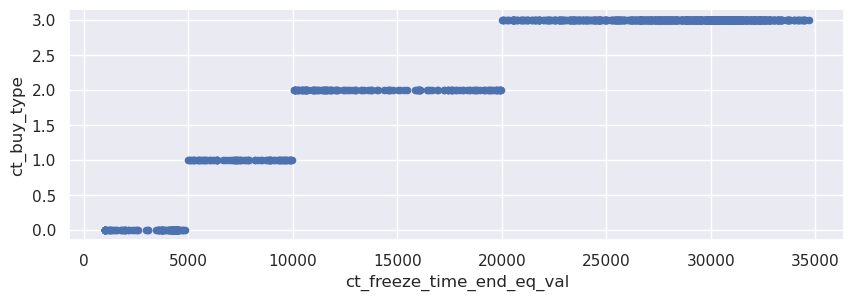

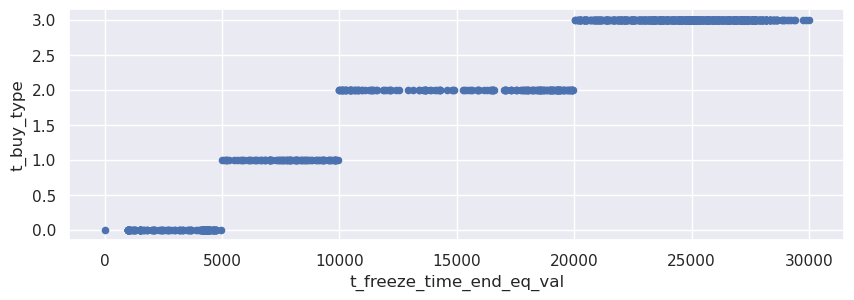

In [35]:
money_cols = ["ct_round_spend_money","ct_buy_type","ct_round_start_eq_val","ct_freeze_time_end_eq_val","t_round_spend_money","t_buy_type","t_round_start_eq_val","t_freeze_time_end_eq_val"]
money_df = rounds_sum_df[money_cols]

buy_type_mapping = {
    'Full Eco': 0,
    'Semi Eco': 1,
    'Semi Buy': 2,
    'Full Buy': 3
}

# Use the .map() function to convert the column
money_df['ct_buy_type'] = money_df['ct_buy_type'].map(buy_type_mapping).astype(int)
money_df['t_buy_type'] = money_df['t_buy_type'].map(buy_type_mapping).astype(int)

money_df["ct_total"] = money_df["ct_round_start_eq_val"] + money_df["ct_round_spend_money"]
money_df["t_total"] = money_df["t_round_start_eq_val"] + money_df["t_round_spend_money"]

money_df.plot.scatter(x="ct_freeze_time_end_eq_val",y="ct_buy_type")
money_df.plot.scatter(x="t_freeze_time_end_eq_val",y="t_buy_type")

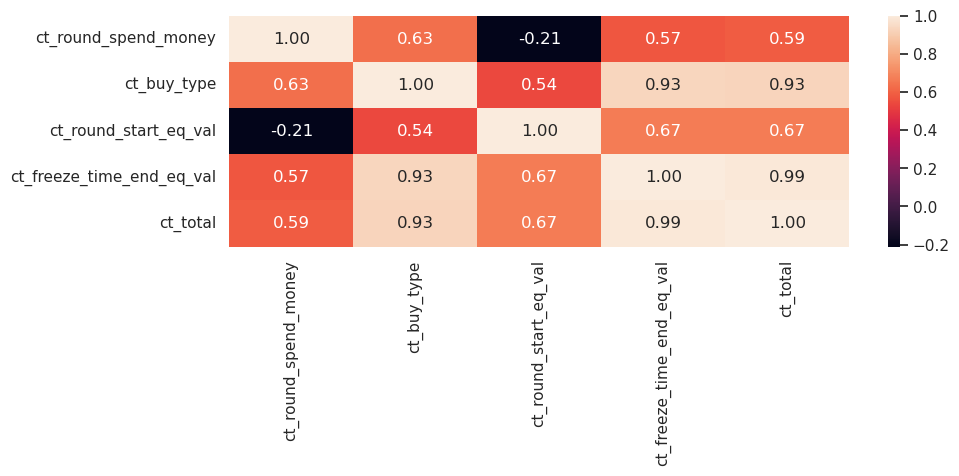

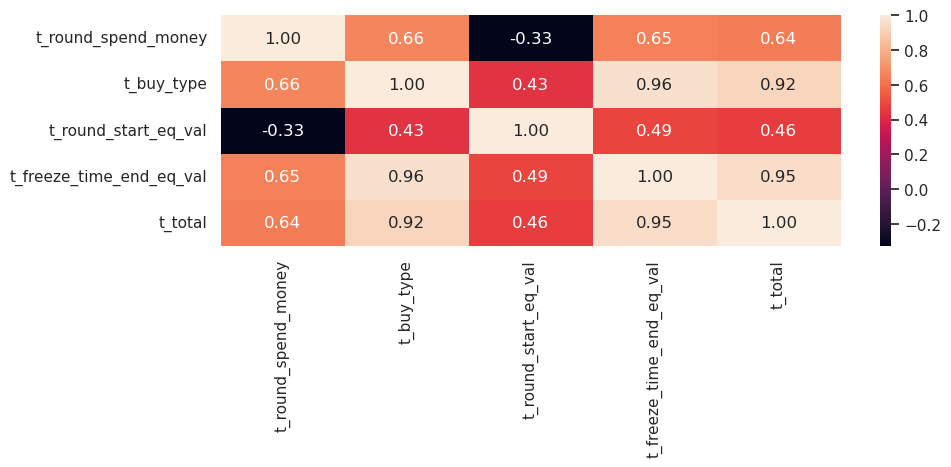

In [36]:
ct_money_corr = money_df.loc[:,money_df.columns.str.startswith("ct")].corr()
sns.heatmap(ct_money_corr,annot=True,fmt='.2f')
plt.show()

t_money_corr = money_df.loc[:,money_df.columns.str.startswith("t")].corr()
sns.heatmap(t_money_corr,annot=True,fmt='.2f')
plt.show()

as we can see that `freeze_time_end_eq_val` could be the representative of `round_spend_money`, `buy_type`, `round_start_eq_val` with pretty high correlation, and if we sum up the `round_start_eq_val` and `round_spend_money`, it would nearly be similar to `freeze_time_end_eq_val`

### dmg col

<Axes: >

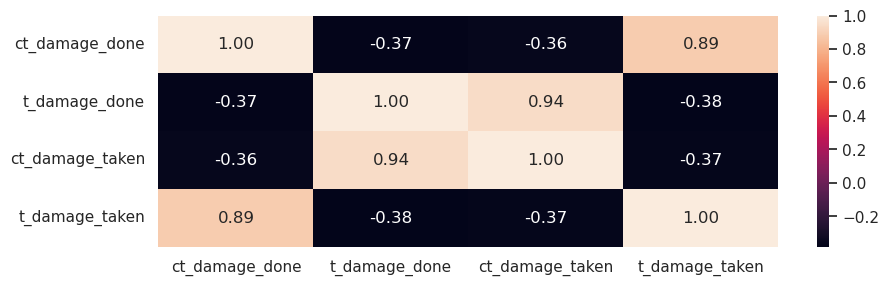

In [37]:
dmg_cols = [col for col in rounds_sum_df.columns if 'damage' in col]
sns.heatmap(rounds_sum_df[dmg_cols].corr(),annot=True,fmt=".2f")

as we can see that `ct_damage_done` to `t_damage_taken` is pretty much the same

### kill and death

<Axes: >

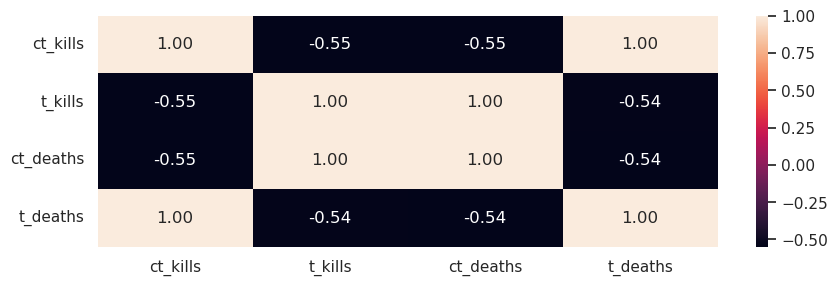

In [38]:
kd_cols = ["ct_kills","t_kills","ct_deaths","t_deaths"]
sns.heatmap(rounds_sum_df[kd_cols].corr(),annot=True,fmt=".2f")

`ct_kills` is always equal to `t_deaths` and vice versa

### grenade cols

In [39]:
print((rounds_sum_df["t_incendiary_grenade"]!=0).mean())
print((rounds_sum_df["ct_molotov"]!=0).mean())

0.036585365853658534
0.08384146341463415


only 3 and 8 percent of each side to have another side fire grenade, I think we could sum it up as `fire_grenades`

## reduced df

In [40]:
reduced_rounds_sum_df = rounds_sum_df.copy()

buy_type_mapping = {
    'Full Eco': 0,
    'Semi Eco': 1,
    'Semi Buy': 2,
    'Full Buy': 3
}

# Use the .map() function to convert the column
reduced_rounds_sum_df['ct_buy_type'] = reduced_rounds_sum_df['ct_buy_type'].map(buy_type_mapping).astype(int)
reduced_rounds_sum_df['t_buy_type'] = reduced_rounds_sum_df['t_buy_type'].map(buy_type_mapping).astype(int)

reduced_rounds_sum_df.drop(["ct_round_spend_money","ct_buy_type","ct_round_start_eq_val","t_round_spend_money","t_buy_type","t_round_start_eq_val"],axis=1,inplace=True)

reduced_rounds_sum_df.drop(["ct_deaths","t_deaths"],axis=1,inplace=True)

reduced_rounds_sum_df.drop(["ct_damage_taken","t_damage_taken"],axis=1,inplace=True)

reduced_rounds_sum_df["ct_fire_grenade"]=reduced_rounds_sum_df["ct_incendiary_grenade"]+reduced_rounds_sum_df["ct_molotov"]
reduced_rounds_sum_df["t_fire_grenade"]=reduced_rounds_sum_df["t_incendiary_grenade"]+reduced_rounds_sum_df["t_molotov"]

reduced_rounds_sum_df.drop(["ct_incendiary_grenade","t_incendiary_grenade","ct_molotov","t_molotov"],axis=1,inplace=True)

reduced_rounds_sum_df.info()



<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1312 entries, ('bfa9bbbe-bd16-4713-bd99-745378db05cb', 1) to ('816e1612-9d2e-4893-af23-bda90c479598', 17)
Data columns (total 46 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   n_ticks                    1312 non-null   int32   
 1   bomb_plant_tick            1312 non-null   int64   
 2   winning_side               1312 non-null   category
 3   round_end_reason           1312 non-null   category
 4   ct_freeze_time_end_eq_val  1312 non-null   int32   
 5   t_freeze_time_end_eq_val   1312 non-null   int16   
 6   ct_flash_opp               1312 non-null   int64   
 7   t_flash_opp                1312 non-null   int64   
 8   ct_flashed                 1312 non-null   int64   
 9   t_flashed                  1312 non-null   int64   
 10  ct_avg_flash_duration      1312 non-null   float64 
 11  t_avg_flash_duration       1312 non-null   float64 
 12  ct_kills

In [41]:
reduced_rounds_sum_df.round_end_reason

match_id                              round_num
bfa9bbbe-bd16-4713-bd99-745378db05cb  1            TerroristsWin
                                      2             TargetBombed
                                      3             TargetBombed
                                      4              TargetSaved
                                      5                    CTWin
                                                       ...      
816e1612-9d2e-4893-af23-bda90c479598  13                   CTWin
                                      14                   CTWin
                                      15                   CTWin
                                      16             BombDefused
                                      17           TerroristsWin
Name: round_end_reason, Length: 1312, dtype: category
Categories (5, object): ['BombDefused', 'CTWin', 'TargetBombed', 'TargetSaved', 'TerroristsWin']

In [42]:
reduced_rounds_sum_df = pd.concat([
    reduced_rounds_sum_df.drop("round_end_reason",axis=1),
    pd.get_dummies(reduced_rounds_sum_df["round_end_reason"], prefix='round_end_reason', columns=['BombDefused', 'CTWin', 'TargetBombed', 'TargetSaved', 'TerroristsWin']).astype(int)],
                                  axis=1)
reduced_rounds_sum_df

n_ticks  bomb_plant_tick  \
match_id                             round_num                             
bfa9bbbe-bd16-4713-bd99-745378db05cb 1            13026             9411   
                                     2            29455            24206   
                                     3            51519            46270   
                                     4            98753               -1   
                                     5           113164               -1   
...                                                 ...              ...   
816e1612-9d2e-4893-af23-bda90c479598 13          183596               -1   
                                     14          197648               -1   
                                     15          208908               -1   
                                     16          254837           250353   
                                     17          270761               -1   

                                               winning_side  \
match_id                             round_num                
bfa9bbbe-bd16-4713-bd99-745378db05cb 1                    T   
                                     2                    T   
                                     3                    T   
                                     4                   CT   
                                     5                   CT   
...                                                     ...   
816e1612-9d2e-4893-af23-bda90c479598 13                  CT   
                                     14                  CT   
                                     15                  CT   
                                     16                  CT   
                                     17                   T   

                                                ct_freeze_time_end_eq_val  \
match_id                             round_num                              
bfa9bbbe-bd16-4713-bd99-745378db05cb 1                               4300   
                                     2                              10600   
                                     3                               5300   
                                     4                              27450   
                                     5                              18350   
...                                                                   ...   
816e1612-9d2e-4893-af23-bda90c479598 13                             34000   
                                     14                             34000   
                                     15                             34200   
                                     16                              4350   
                                     17                             18000   

                                                t_freeze_time_end_eq_val  \
match_id                             round_num                             
bfa9bbbe-bd16-4713-bd99-745378db05cb 1                              4350   
                                     2                             18000   
                                     3                             22000   
                                     4                             27550   
                                     5                             26650   
...                                                                  ...   
816e1612-9d2e-4893-af23-bda90c479598 13                            17000   
                                     14                             8150   
                                     15                            26100   
                                     16                             4200   
                                     17                            15900   

                                                ct_flash_opp  t_flash_opp  \
match_id                             round_num                              
bfa9bbbe-bd16-4713-bd99-745378db05cb 1                     0            0   
                 

In [43]:
reduced_rounds_sum_df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1312 entries, ('bfa9bbbe-bd16-4713-bd99-745378db05cb', 1) to ('816e1612-9d2e-4893-af23-bda90c479598', 17)
Data columns (total 50 columns):
 #   Column                          Non-Null Count  Dtype   
---  ------                          --------------  -----   
 0   n_ticks                         1312 non-null   int32   
 1   bomb_plant_tick                 1312 non-null   int64   
 2   winning_side                    1312 non-null   category
 3   ct_freeze_time_end_eq_val       1312 non-null   int32   
 4   t_freeze_time_end_eq_val        1312 non-null   int16   
 5   ct_flash_opp                    1312 non-null   int64   
 6   t_flash_opp                     1312 non-null   int64   
 7   ct_flashed                      1312 non-null   int64   
 8   t_flashed                       1312 non-null   int64   
 9   ct_avg_flash_duration           1312 non-null   float64 
 10  t_avg_flash_duration            1312 non-null   float64 
 11  

In [44]:
# as winning_side ct is 1
reduced_rounds_sum_df["winning_side"] = (reduced_rounds_sum_df["winning_side"].str.lower()=="ct").astype(int)

In [45]:
reduced_rounds_sum_df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1312 entries, ('bfa9bbbe-bd16-4713-bd99-745378db05cb', 1) to ('816e1612-9d2e-4893-af23-bda90c479598', 17)
Data columns (total 50 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   n_ticks                         1312 non-null   int32  
 1   bomb_plant_tick                 1312 non-null   int64  
 2   winning_side                    1312 non-null   int64  
 3   ct_freeze_time_end_eq_val       1312 non-null   int32  
 4   t_freeze_time_end_eq_val        1312 non-null   int16  
 5   ct_flash_opp                    1312 non-null   int64  
 6   t_flash_opp                     1312 non-null   int64  
 7   ct_flashed                      1312 non-null   int64  
 8   t_flashed                       1312 non-null   int64  
 9   ct_avg_flash_duration           1312 non-null   float64
 10  t_avg_flash_duration            1312 non-null   float64
 11  ct_kills     

## feature selection

<Axes: xlabel='winning_side'>

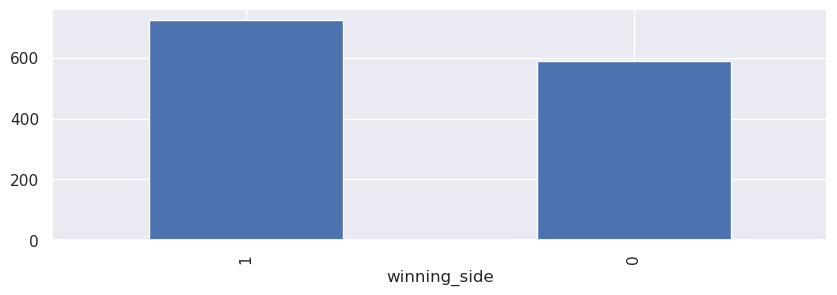

In [46]:
reduced_rounds_sum_df.winning_side.value_counts().plot.bar()

In [47]:
reduced_rounds_sum_df[["ct_flash_opp","ct_flashed","t_flash_opp","t_flashed"]]

ct_flash_opp  ct_flashed  \
match_id                             round_num                             
bfa9bbbe-bd16-4713-bd99-745378db05cb 1                     0           0   
                                     2                     0           9   
                                     3                     0           6   
                                     4                     0           6   
                                     5                     0          14   
...                                                      ...         ...   
816e1612-9d2e-4893-af23-bda90c479598 13                   10          19   
                                     14                    4           6   
                                     15                    6           5   
                                     16                    4           4   
                                     17                    0           2   

                                                t_flash_opp  t_flashed  
match_id                             round_num                          
bfa9bbbe-bd16-4713-bd99-745378db05cb 1                    0          0  
                                     2                   12          3  
                                     3                    7          1  
                                     4                    7          1  
                                     5                   20          6  
...                                                     ...        ...  
816e1612-9d2e-4893-af23-bda90c479598 13                  31         22  
                                     14                   4          2  
                                     15                   7          8  
                                     16                   2          2  
                                     17                   3          1  

[1312 rows x 4 columns]

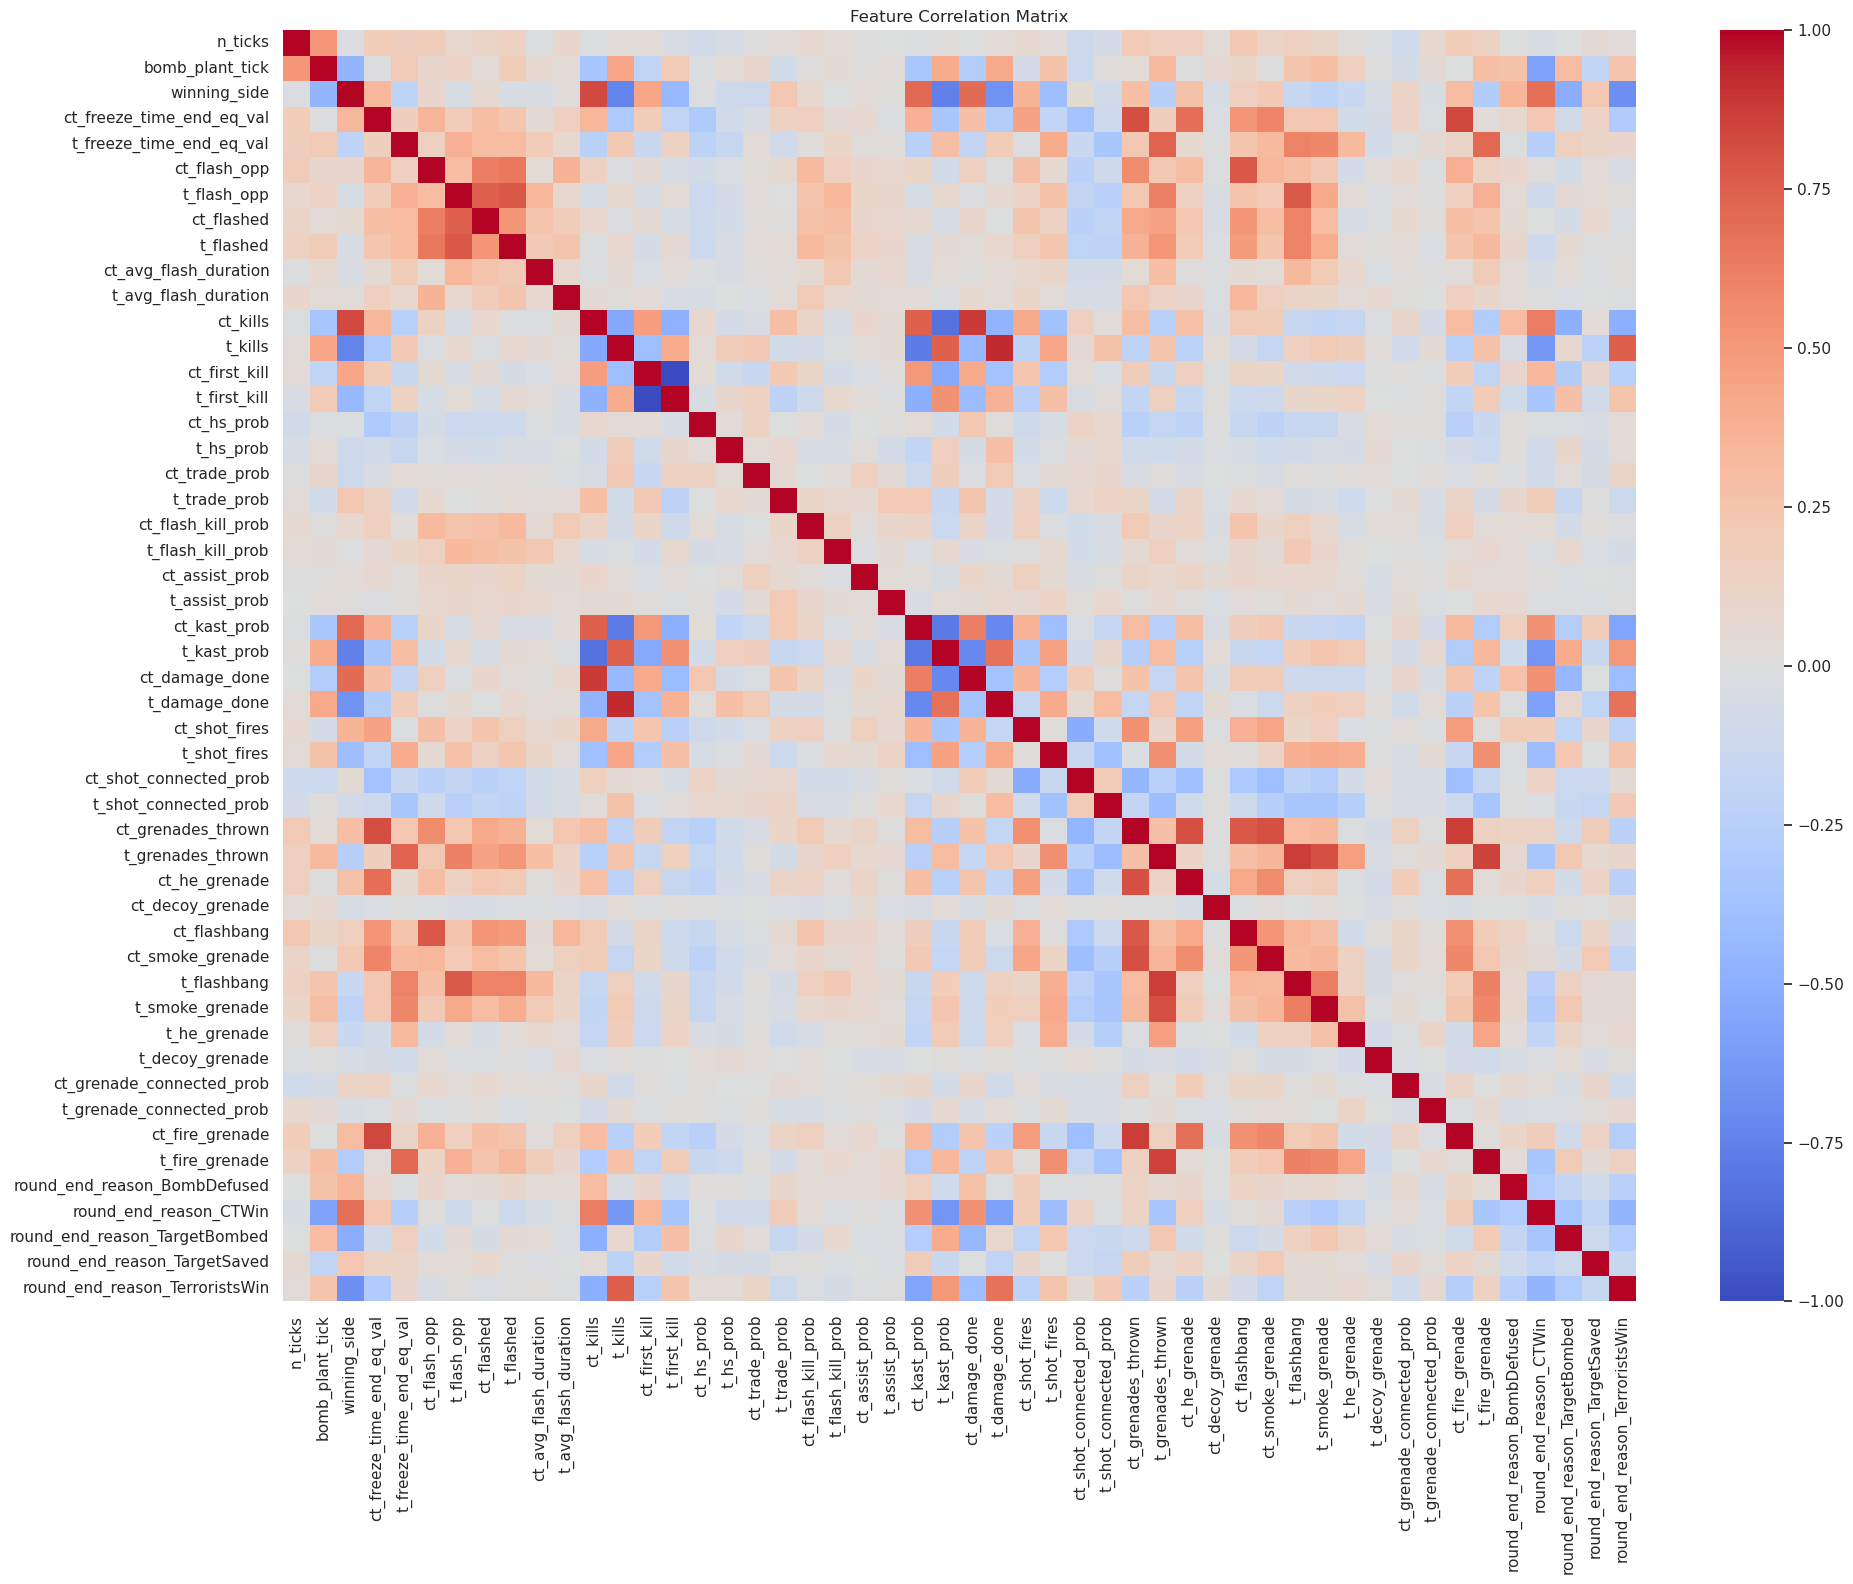

Highly correlated features:
winning_side & ct_kills: 0.83
ct_freeze_time_end_eq_val & ct_grenades_thrown: 0.81
ct_freeze_time_end_eq_val & ct_fire_grenade: 0.84
ct_kills & winning_side: 0.83
ct_kills & t_kast_prob: -0.82
ct_kills & ct_damage_done: 0.88
t_kills & t_damage_done: 0.93
ct_first_kill & t_first_kill: -1.00
t_first_kill & ct_first_kill: -1.00
t_kast_prob & ct_kills: -0.82
ct_damage_done & ct_kills: 0.88
t_damage_done & t_kills: 0.93
ct_grenades_thrown & ct_freeze_time_end_eq_val: 0.81
ct_grenades_thrown & ct_he_grenade: 0.81
ct_grenades_thrown & ct_smoke_grenade: 0.80
ct_grenades_thrown & ct_fire_grenade: 0.87
t_grenades_thrown & t_flashbang: 0.87
t_grenades_thrown & t_smoke_grenade: 0.81
t_grenades_thrown & t_fire_grenade: 0.85
ct_he_grenade & ct_grenades_thrown: 0.81
ct_smoke_grenade & ct_grenades_thrown: 0.80
t_flashbang & t_grenades_thrown: 0.87
t_smoke_grenade & t_grenades_thrown: 0.81
ct_fire_grenade & ct_freeze_time_end_eq_val: 0.84
ct_fire_grenade & ct_grenades_thrown

In [48]:
from sklearn.feature_selection import SelectKBest, f_classif

# Correlation analysis
plt.figure(figsize=(20, 16))
correlation_matrix = reduced_rounds_sum_df.corr()
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

# Identify highly correlated features (threshold > 0.8)
high_corr = np.where(np.abs(correlation_matrix) > 0.8)
high_corr_list = [(correlation_matrix.index[x], correlation_matrix.columns[y], correlation_matrix.iloc[x, y]) 
                 for x, y in zip(*high_corr) if x != y]
print("Highly correlated features:")
for item in high_corr_list:
    print(f"{item[0]} & {item[1]}: {item[2]:.2f}")

# # Feature importance based on statistical tests
# # Assuming winning side is binary (1/0) - adjust as needed
# X = df.drop(['winning_side'], axis=1)  # Adjust column name to your actual target
# y = df['winning_side']  # Adjust column name

# # Apply SelectKBest
# selector = SelectKBest(f_classif, k=15)
# X_new = selector.fit_transform(X, y)

# # Get selected feature names
# selected_features = X.columns[selector.get_support()]
# feature_scores = pd.DataFrame({
#     'Feature': X.columns,
#     'Score': selector.scores_
# })
# print("Top 15 features by importance:")
# print(feature_scores.sort_values('Score', ascending=False).head(15))

In [49]:
def high_corr_cols(df,target,threshold=0.8):
    hc_cols = set()
    corr = df.corr()
    for i in range(corr.columns.size):
        for j in range(i):
            if abs(corr.iloc[i,j])>threshold:
                print(corr.columns[i],corr.columns[j],corr.iloc[i,j])
                if df.iloc[:,i].var() >= df.iloc[:,j].var() or corr.columns[j] == target:
                    col_idx = i
                else:
                    col_idx = j
                hc_cols.add(corr.columns[col_idx])
    return list(hc_cols)

high_corr_cols(reduced_rounds_sum_df,"winning_side",threshold=0.85)

t_first_kill ct_first_kill -1.0
ct_damage_done ct_kills 0.8827166645077876
t_damage_done t_kills 0.9252201941738435
t_flashbang t_grenades_thrown 0.8692433225052344
ct_fire_grenade ct_grenades_thrown 0.8682395486596396
t_fire_grenade t_grenades_thrown 0.8519917134992763


['ct_damage_done',
 't_damage_done',
 'ct_grenades_thrown',
 't_grenades_thrown',
 't_first_kill']

In [50]:
reduced_rounds_sum_df.drop(high_corr_cols(reduced_rounds_sum_df,"winning_side",threshold=0.85),axis=1,inplace=True)

t_first_kill ct_first_kill -1.0
ct_damage_done ct_kills 0.8827166645077876
t_damage_done t_kills 0.9252201941738435
t_flashbang t_grenades_thrown 0.8692433225052344
ct_fire_grenade ct_grenades_thrown 0.8682395486596396
t_fire_grenade t_grenades_thrown 0.8519917134992763


Feature comparison between CT wins and T wins (scaled):


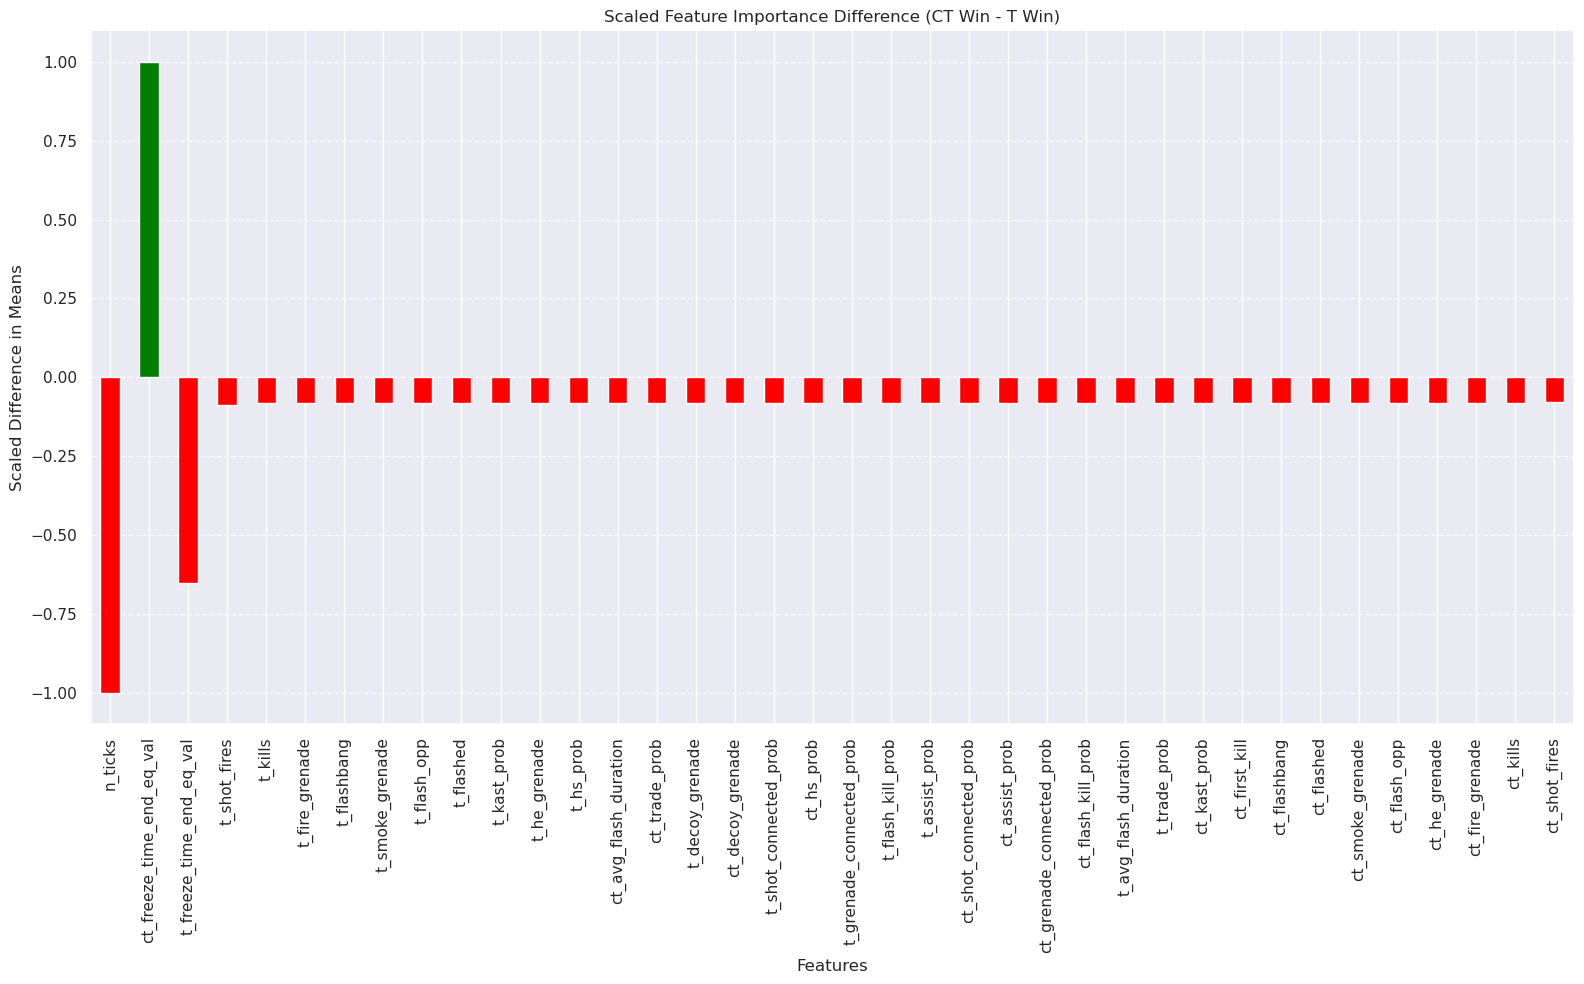

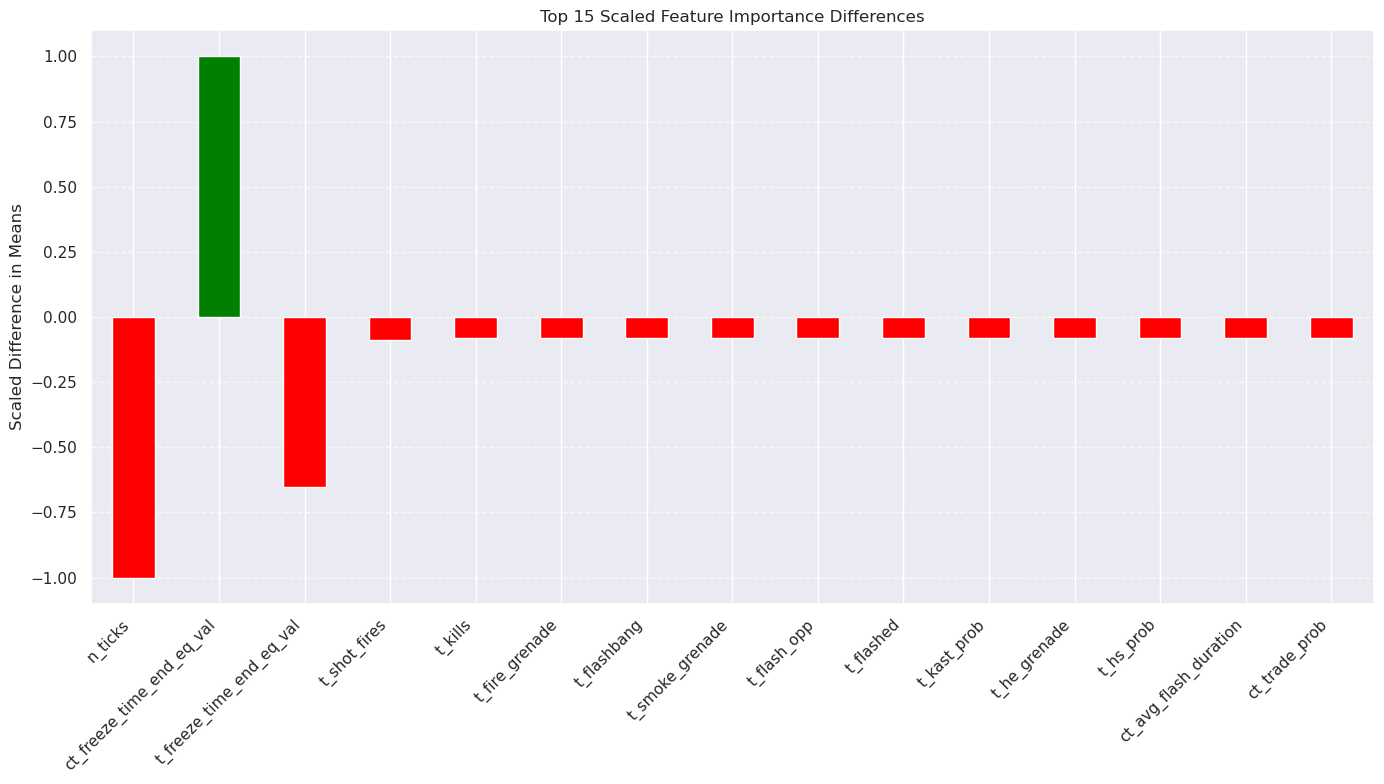


Percentage difference for top features (CT vs T):


%diff
ct_grenade_connected_prob  137.703699
ct_kills                   137.417467
ct_first_kill              123.733765
t_trade_prob                97.058600
ct_kast_prob                91.931044
ct_fire_grenade             55.943366
ct_shot_fires               45.952084
ct_he_grenade               44.417201
ct_flash_kill_prob          38.402283
ct_freeze_time_end_eq_val   35.664122
ct_flashbang                26.594824
ct_smoke_grenade            26.151704
ct_flash_opp                20.621176
ct_flashed                  11.617183
ct_assist_prob               8.168153
ct_shot_connected_prob       5.042785
t_assist_prob                3.877244
t_avg_flash_duration         3.260786
n_ticks                     -2.397537
t_flash_kill_prob           -2.846943
ct_hs_prob                  -2.992747
ct_avg_flash_duration       -3.492703
t_flashed                   -7.035284
t_flash_opp                 -8.084634
t_shot_connected_prob       -9.484207
t_hs_prob                  -13.715998
t_freeze_time_end_eq_val   -16.821169
t_flashbang                -17.369659
t_smoke_grenade            -18.812064
t_he_grenade               -28.223127
ct_trade_prob              -32.267579
t_fire_grenade             -32.617377
t_grenade_connected_prob   -34.084937
t_shot_fires               -36.746471
t_decoy_grenade            -43.220588
ct_decoy_grenade           -45.689258
t_kast_prob                -57.797497
t_kills                    -58.657071

In [51]:
win_condition = reduced_rounds_sum_df['winning_side'] == 1  # Adjust based on your data
ct_win_df = reduced_rounds_sum_df[win_condition]
t_win_df = reduced_rounds_sum_df[~win_condition]

features_to_compare = reduced_rounds_sum_df.columns.to_list()
features_to_compare.remove("bomb_plant_tick")
features_to_compare.remove("winning_side")  # Also remove target variable from comparison
features_to_compare = [col for col in features_to_compare if not col.startswith("round_end_reason_")]

comparison_df = pd.DataFrame()

for feature in features_to_compare:
    comparison_df.loc['CT Win Mean', feature] = ct_win_df[feature].mean()
    comparison_df.loc['T Win Mean', feature] = t_win_df[feature].mean()
    comparison_df.loc['Difference', feature] = ct_win_df[feature].mean() - t_win_df[feature].mean()
    
from sklearn.preprocessing import MinMaxScaler

differences = comparison_df.loc['Difference'].values.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(-1, 1))
scaled_differences = scaler.fit_transform(differences).flatten()

scaled_comparison_df = pd.DataFrame(
    scaled_differences, 
    index=features_to_compare,
    columns=['Scaled Difference']
)

# Sort by absolute value to show most significant differences first
scaled_comparison_df = scaled_comparison_df.reindex(
    scaled_comparison_df['Scaled Difference'].abs().sort_values(ascending=False).index
)

print("Feature comparison between CT wins and T wins (scaled):")

plt.figure(figsize=(16, 10))
scaled_comparison_df['Scaled Difference'].plot(kind='bar', color=scaled_comparison_df['Scaled Difference'].map(
    lambda x: 'green' if x > 0 else 'red'))
plt.title('Scaled Feature Importance Difference (CT Win - T Win)')
plt.ylabel('Scaled Difference in Means')
plt.xlabel('Features')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

plt.figure(figsize=(14, 8))
scaled_comparison_df['Scaled Difference'].head(15).plot(kind='bar', color=scaled_comparison_df['Scaled Difference'].head(15).map(
    lambda x: 'green' if x > 0 else 'red'))
plt.title('Top 15 Scaled Feature Importance Differences')
plt.ylabel('Scaled Difference in Means')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

top_features_scaled = scaled_comparison_df.index

percentage_df = pd.DataFrame()
for feature in top_features_scaled:
    if t_win_df[feature].mean() != 0:
        pct_change = ((ct_win_df[feature].mean() / t_win_df[feature].mean())-1) * 100
    else:
        pct_change = float('inf') if ct_win_df[feature].mean() > 0 else float('-inf')
    
    percentage_df.loc[feature,"%diff"] = pct_change

print("\nPercentage difference for top features (CT vs T):")
percentage_df.sort_values('%diff',ascending=False,inplace=True)
display(percentage_df)

## create df w/ lag

In [52]:
def create_lag(df, lag=1, subset=None):
    result = df.copy()
    
    if subset is None:
        subset = df.columns.tolist()
    
    lag_cols_all = []
    for l in range(1, lag + 1):
        lag_cols = [f"{col}_lag{l}" for col in subset]
        lag_cols_all.extend(lag_cols)
        
    for col in lag_cols_all:
        result[col] = float('nan')
    
    unique_matches = df.index.get_level_values('match_id').unique()
    
    for match_id in unique_matches:
        match_rows = result.loc[match_id]
        
        for l in range(1, lag + 1):
            for col in subset:
                lag_col = f"{col}_lag{l}"
                result.loc[match_id, lag_col] = match_rows[col].shift(l).values
    
    return result

In [53]:
lag_df = create_lag(reduced_rounds_sum_df,3)
lag_df = lag_df[["winning_side"]+\
[col for col in lag_df.columns if "_lag" in col]]
lag_df.fillna(-1,inplace=True)
lag_df

winning_side  n_ticks_lag1  \
match_id                             round_num                               
bfa9bbbe-bd16-4713-bd99-745378db05cb 1                     0          -1.0   
                                     2                     0       13026.0   
                                     3                     0       29455.0   
                                     4                     1       51519.0   
                                     5                     1       98753.0   
...                                                      ...           ...   
816e1612-9d2e-4893-af23-bda90c479598 13                    1      174128.0   
                                     14                    1      183596.0   
                                     15                    1      197648.0   
                                     16                    1      208908.0   
                                     17                    0      254837.0   

                                                bomb_plant_tick_lag1  \
match_id                             round_num                         
bfa9bbbe-bd16-4713-bd99-745378db05cb 1                          -1.0   
                                     2                        9411.0   
                                     3                       24206.0   
                                     4                       46270.0   
                                     5                          -1.0   
...                                                              ...   
816e1612-9d2e-4893-af23-bda90c479598 13                         -1.0   
                                     14                         -1.0   
                                     15                         -1.0   
                                     16                         -1.0   
                                     17                     250353.0   

                                                winning_side_lag1  \
match_id                             round_num                      
bfa9bbbe-bd16-4713-bd99-745378db05cb 1                       -1.0   
                                     2                        0.0   
                                     3                        0.0   
                                     4                        0.0   
                                     5                        1.0   
...                                                           ...   
816e1612-9d2e-4893-af23-bda90c479598 13                       1.0   
                                     14                       1.0   
                                     15                       1.0   
                                     16                       1.0   
                                     17                       1.0   

                                                ct_freeze_time_end_eq_val_lag1  \
match_id                             round_num                                   
bfa9bbbe-bd16-4713-bd99-745378db05cb 1                                    -1.0   
                                     2                                  4300.0   
                                     3                                 10600.0   
                                     4                                  5300.0   
                                     5                                 27450.0   
...                                                                        ...   
816e1612-9d2e-4893-af23-bda90c479598 13                                34400.0   
                                     14                                34000.0   
                                     15                                34000.0   
                                     16                                34200.0   
                                     17                                 4350.0   

                                                t_freeze_time_end_eq_val_lag1  \
match_id                             round_num    

## df w/ cumulative vals

In [54]:
non_cumu_cols = ['n_ticks', 'bomb_plant_tick', 'winning_side', 'round_end_reason',"ct_buy_type","t_buy_type"]
cumulative_cols = [col for col in reduced_rounds_sum_df if col not in non_cumu_cols]

cumu_r_df = reduced_rounds_sum_df.copy()
for idx in cumu_r_df.index:
    curr_round = idx[1]
    if curr_round <= 15:
        start_round = 0
    else:
        start_round = 15
    target_cols = [f"cumu_{col}" for col in cumulative_cols]
    cumu_val =  cumu_r_df.loc[idx[0],cumulative_cols].iloc[start_round:curr_round-1].mean().fillna(0).values
    cumu_r_df.loc[idx,target_cols] = cumu_val

with pd.option_context('display.max_rows',20,'display.max_columns', None):
    display(cumu_r_df)
    

n_ticks  bomb_plant_tick  \
match_id                             round_num                             
bfa9bbbe-bd16-4713-bd99-745378db05cb 1            13026             9411   
                                     2            29455            24206   
                                     3            51519            46270   
                                     4            98753               -1   
                                     5           113164               -1   
...                                                 ...              ...   
816e1612-9d2e-4893-af23-bda90c479598 13          183596               -1   
                                     14          197648               -1   
                                     15          208908               -1   
                                     16          254837           250353   
                                     17          270761               -1   

                                                winning_side  \
match_id                             round_num                 
bfa9bbbe-bd16-4713-bd99-745378db05cb 1                     0   
                                     2                     0   
                                     3                     0   
                                     4                     1   
                                     5                     1   
...                                                      ...   
816e1612-9d2e-4893-af23-bda90c479598 13                    1   
                                     14                    1   
                                     15                    1   
                                     16                    1   
                                     17                    0   

                                                ct_freeze_time_end_eq_val  \
match_id                             round_num                              
bfa9bbbe-bd16-4713-bd99-745378db05cb 1                               4300   
                                     2                              10600   
                                     3                               5300   
                                     4                              27450   
                                     5                              18350   
...                                                                   ...   
816e1612-9d2e-4893-af23-bda90c479598 13                             34000   
                                     14                             34000   
                                     15                             34200   
                                     16                              4350   
                                     17                             18000   

                                                t_freeze_time_end_eq_val  \
match_id                             round_num                             
bfa9bbbe-bd16-4713-bd99-745378db05cb 1                              4350   
                                     2                             18000   
                                     3                             22000   
                                     4                             27550   
                                     5                             26650   
...                                                                  ...   
816e1612-9d2e-4893-af23-bda90c479598 13                            17000   
                                     14                             8150   
                                     15                            26100   
                                     16                             4200   
                                     17                            15900   

                                                ct_flash_opp  t_flash_opp  \
match_id                             round_num                              
bfa9bbbe-bd16-4713-bd99-745378db05cb 1                     0            0   
    

In [55]:
cumu_df = cumu_r_df[["winning_side"]+\
[col for col in cumu_r_df.columns if col.startswith("cumu_")]]
cumu_df

winning_side  \
match_id                             round_num                 
bfa9bbbe-bd16-4713-bd99-745378db05cb 1                     0   
                                     2                     0   
                                     3                     0   
                                     4                     1   
                                     5                     1   
...                                                      ...   
816e1612-9d2e-4893-af23-bda90c479598 13                    1   
                                     14                    1   
                                     15                    1   
                                     16                    1   
                                     17                    0   

                                                cumu_ct_freeze_time_end_eq_val  \
match_id                             round_num                                   
bfa9bbbe-bd16-4713-bd99-745378db05cb 1                                0.000000   
                                     2                             4300.000000   
                                     3                             7450.000000   
                                     4                             6733.333333   
                                     5                            11912.500000   
...                                                                        ...   
816e1612-9d2e-4893-af23-bda90c479598 13                           27379.166667   
                                     14                           27888.461538   
                                     15                           28325.000000   
                                     16                               0.000000   
                                     17                            4350.000000   

                                                cumu_t_freeze_time_end_eq_val  \
match_id                             round_num                                  
bfa9bbbe-bd16-4713-bd99-745378db05cb 1                               0.000000   
                                     2                            4350.000000   
                                     3                           11175.000000   
                                     4                           14783.333333   
                                     5                           17975.000000   
...                                                                       ...   
816e1612-9d2e-4893-af23-bda90c479598 13                          15441.666667   
                                     14                          15561.538462   
                                     15                          15032.142857   
                                     16                              0.000000   
                                     17                           4200.000000   

                                                cumu_ct_flash_opp  \
match_id                             round_num                      
bfa9bbbe-bd16-4713-bd99-745378db05cb 1                   0.000000   
                                     2                   0.000000   
                                     3                   0.000000   
                                     4                   0.000000   
                                     5                   0.000000   
...                                                           ...   
816e1612-9d2e-4893-af23-bda90c479598 13                  7.250000   
                                     14                  7.461538   
                                     15                  7.214286   
                                     16                  0.000000   
                                     17                  4.000000   

                                                cumu_t_flash_opp  \
match_id                             round_num                     
bfa9bbbe-bd16-4713-bd99-745378db05cb 1                  0.00

In [56]:
# r_df = rounds_sum_df[["winning_side"]+start_round_cols]
r_df = reduced_rounds_sum_df[["ct_freeze_time_end_eq_val","t_freeze_time_end_eq_val","winning_side"]]
r_df["freeze_time_end_eq_val_diff"] = r_df["ct_freeze_time_end_eq_val"]-r_df["t_freeze_time_end_eq_val"]
r_df.drop(["ct_freeze_time_end_eq_val","t_freeze_time_end_eq_val"],axis=1,inplace=True)
r_df.head(5)

winning_side  \
match_id                             round_num                 
bfa9bbbe-bd16-4713-bd99-745378db05cb 1                     0   
                                     2                     0   
                                     3                     0   
                                     4                     1   
                                     5                     1   

                                                freeze_time_end_eq_val_diff  
match_id                             round_num                               
bfa9bbbe-bd16-4713-bd99-745378db05cb 1                                  -50  
                                     2                                -7400  
                                     3                               -16700  
                                     4                                 -100  
                                     5                                -8300

<Axes: xlabel='freeze_time_end_eq_val_diff', ylabel='winning_side'>

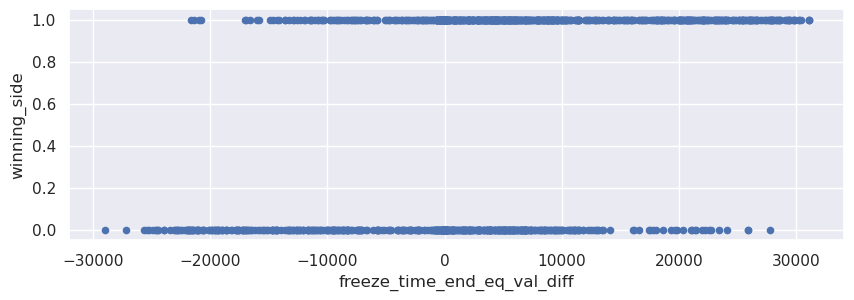

In [57]:
r_df.plot.scatter(x="freeze_time_end_eq_val_diff",y="winning_side")

In [58]:
all_df = pd.concat([lag_df,cumu_df],axis=1).dropna(how="any")
all_df = all_df.loc[:,~all_df.columns.duplicated()]
all_df

winning_side  n_ticks_lag1  \
match_id                             round_num                               
bfa9bbbe-bd16-4713-bd99-745378db05cb 1                     0          -1.0   
                                     2                     0       13026.0   
                                     3                     0       29455.0   
                                     4                     1       51519.0   
                                     5                     1       98753.0   
...                                                      ...           ...   
816e1612-9d2e-4893-af23-bda90c479598 13                    1      174128.0   
                                     14                    1      183596.0   
                                     15                    1      197648.0   
                                     16                    1      208908.0   
                                     17                    0      254837.0   

                                                bomb_plant_tick_lag1  \
match_id                             round_num                         
bfa9bbbe-bd16-4713-bd99-745378db05cb 1                          -1.0   
                                     2                        9411.0   
                                     3                       24206.0   
                                     4                       46270.0   
                                     5                          -1.0   
...                                                              ...   
816e1612-9d2e-4893-af23-bda90c479598 13                         -1.0   
                                     14                         -1.0   
                                     15                         -1.0   
                                     16                         -1.0   
                                     17                     250353.0   

                                                winning_side_lag1  \
match_id                             round_num                      
bfa9bbbe-bd16-4713-bd99-745378db05cb 1                       -1.0   
                                     2                        0.0   
                                     3                        0.0   
                                     4                        0.0   
                                     5                        1.0   
...                                                           ...   
816e1612-9d2e-4893-af23-bda90c479598 13                       1.0   
                                     14                       1.0   
                                     15                       1.0   
                                     16                       1.0   
                                     17                       1.0   

                                                ct_freeze_time_end_eq_val_lag1  \
match_id                             round_num                                   
bfa9bbbe-bd16-4713-bd99-745378db05cb 1                                    -1.0   
                                     2                                  4300.0   
                                     3                                 10600.0   
                                     4                                  5300.0   
                                     5                                 27450.0   
...                                                                        ...   
816e1612-9d2e-4893-af23-bda90c479598 13                                34400.0   
                                     14                                34000.0   
                                     15                                34000.0   
                                     16                                34200.0   
                                     17                                 4350.0   

                                                t_freeze_time_end_eq_val_lag1  \
match_id                             round_num    

## feature importance w/ classification

In [59]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler  # Import scalers
import pandas as pd

# Use the lag_r_df that was created earlier
target_df = r_df
add_feature = "lag"
add_feature_prefix = add_feature + "_"
target_df_reset = target_df.reset_index()

# Filter to keep only the columns we need
features_to_keep = [col for col in target_df_reset.columns 
                    if col not in ["match_id", "round_num", "round_end_reason"]]

# Create the model DataFrame
model_df = target_df_reset[features_to_keep]

model_df.drop(high_corr_cols(model_df,"winning_side",threshold=0.85),axis=1,inplace=True)
# Convert winning_side to binary (1 for CT win, 0 otherwise)

# Identify categorical columns
cat_cols = model_df.select_dtypes(include=["object", "category"]).columns

# One-hot encode categorical columns
model_df = pd.get_dummies(model_df, columns=cat_cols, drop_first=True)

# Separate target variable before normalization
y = model_df["winning_side"]
X = model_df.drop("winning_side", axis=1)

# Normalize all numeric features using StandardScaler
# (You can replace this with MinMaxScaler if you prefer values between 0 and 1)
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# Recombine with target variable for display purposes
model_df= pd.concat([X_scaled, y.reset_index(drop=True)], axis=1)

# Display the normalized DataFrame
display(model_df.head(5))

# Now you can use X_scaled and y for your modeling
# X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

freeze_time_end_eq_val_diff  winning_side
0                    -0.291399             0
1                    -0.897413             0
2                    -1.664205             0
3                    -0.295522             1
4                    -0.971619             1

<Axes: xlabel='winning_side', ylabel='count'>

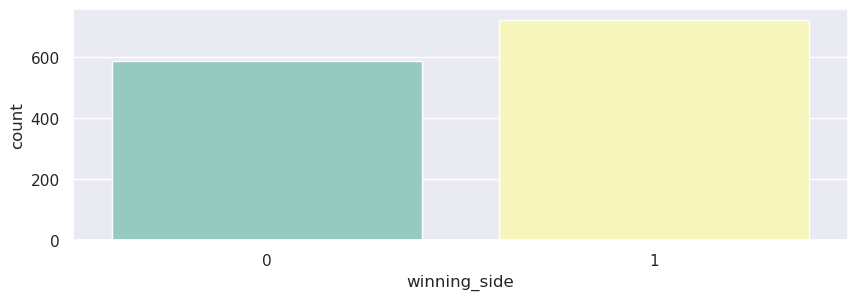

In [60]:
sns.countplot(data=model_df,x="winning_side",palette="Set3")

In [61]:
# for col in model_df.columns:
#     if model_df[col].nunique()<20:
#         plt.xticks(rotation=45, ha='right')
#         sns.countplot(x=col,data=model_df,hue="winning_side",palette="Set3")
#     else:
#         sns.scatterplot(data=model_df,x=col,y="winning_side")
#     plt.show()

In [62]:
from sklearn.feature_selection import mutual_info_classif
from scipy.stats import entropy

def calculate_gain_ratio(df, target_column='winning_side'):
    X = df.drop(columns=[target_column])
    y = df[target_column]
    
    information_gains = mutual_info_classif(X, y, discrete_features='auto', random_state=42)
    
    gain_ratios = {}
    feature_names = X.columns
    
    for i, feature_name in enumerate(feature_names):
        # Calculate split information
        feature_values = X[feature_name].value_counts(normalize=True).values
        split_info = entropy(feature_values, base=2)
        
        # Avoid division by zero
        if split_info > 0:
            gain_ratio = information_gains[i] / split_info
        else:
            gain_ratio = 0
            
        yield feature_name,gain_ratio
    

gain_ratios = sorted(filter(lambda p : p[1] > 0, calculate_gain_ratio(model_df)),key = lambda p : p[1],reverse=True)
print("Gain Ratios:")
for feature, ratio in gain_ratios[:20]:
    print(f"{feature}: {ratio:.4f}")

Gain Ratios:
freeze_time_end_eq_val_diff: 0.0116


In [63]:
features = [col for col in model_df.columns if col != 'winning_side']
X = model_df[features]
y = model_df['winning_side']


# # Print info about the data
print(f"Shape of feature matrix: {X.shape}")
print(f"Number of features: {len(features)}")
print(f"Number of {add_feature} features: {sum(1 for col in features if col.startswith(add_feature_prefix))}")

# # 2. Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Shape of feature matrix: (1312, 1)
Number of features: 1
Number of lag features: 0


In [64]:
from sklearn.compose import ColumnTransformer
num_cols = X_train.columns

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
    ],
    remainder="passthrough"
    
).set_output(transform="pandas")

X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

### decision tree clf

In [65]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Create and train the Decision Tree model
model = DecisionTreeClassifier(random_state=42, criterion="gini")
model.fit(X_train, y_train)

# When evaluating the model performance:
y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Feature Importance
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model.feature_importances_
})
feature_importances = feature_importances.sort_values('Importance', ascending=False)
feature_importances = feature_importances[feature_importances.Importance > 0]
print("\nTop Feature Importances:")
display(feature_importances.head(15))

# # Analyze additional vs normal feature importance
# additional_importances = feature_importances[feature_importances['Feature'].str.startswith(add_feature_prefix)]
# normal_importances = feature_importances[~feature_importances['Feature'].str.startswith(add_feature_prefix)]

# print("\nTop 5 Additional Feature Importances:")
# print(additional_importances.head(5))
# print("\nTop 5 Normal Feature Importances:")
# print(normal_importances.head(5))

# # Calculate overall importance of additional vs normal features
# total_additional_importance = additional_importances['Importance'].sum()
# total_normal_importance = normal_importances['Importance'].sum()

# print(f"\nTotal Additional Features Importance: {total_additional_importance:.4f}")
# print(f"Total Normal Features Importance: {total_normal_importance:.4f}")
# print(f"Ratio of Additional to Normal Feature Importance: {total_additional_importance/total_normal_importance:.4f}")


Confusion Matrix:
[[70 42]
 [65 86]]

Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.62      0.57       112
           1       0.67      0.57      0.62       151

    accuracy                           0.59       263
   macro avg       0.60      0.60      0.59       263
weighted avg       0.61      0.59      0.60       263


Top Feature Importances:


Feature  Importance
0  freeze_time_end_eq_val_diff         1.0

### random forest clf

In [66]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# When evaluating the model performance:
y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Feature Importance
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model.feature_importances_
})
feature_importances = feature_importances.sort_values('Importance', ascending=False)
feature_importances = feature_importances[feature_importances.Importance > 0]
print("\nTop Feature Importances:")
display(feature_importances.head(15))

# Analyze additional vs normal feature importance
# additional_importances = feature_importances[feature_importances['Feature'].str.startswith(add_feature_prefix)]
# normal_importances = feature_importances[~feature_importances['Feature'].str.startswith(add_feature_prefix)]

# print("\nTop 5 Additional Feature Importances:")
# print(additional_importances.head(5))
# print("\nTop 5 Normal Feature Importances:")
# print(normal_importances.head(5))

# # Calculate overall importance of additional vs normal features
# total_additional_importance = additional_importances['Importance'].sum()
# total_normal_importance = normal_importances['Importance'].sum()

# print(f"\nTotal Additional Features Importance: {total_additional_importance:.4f}")
# print(f"Total Normal Features Importance: {total_normal_importance:.4f}")
# print(f"Ratio of Additional to Normal Feature Importance: {total_additional_importance/total_normal_importance:.4f}")


Confusion Matrix:
[[ 70  42]
 [ 51 100]]

Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.62      0.60       112
           1       0.70      0.66      0.68       151

    accuracy                           0.65       263
   macro avg       0.64      0.64      0.64       263
weighted avg       0.65      0.65      0.65       263


Top Feature Importances:


Feature  Importance
0  freeze_time_end_eq_val_diff         1.0

### grad boost clf

In [67]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import pandas as pd

# Assuming you have your data in X_train, y_train, X_test, y_test
# 1. Create and train the Gradient Boosting model
model = GradientBoostingClassifier(random_state=42)  # You can adjust parameters here
model.fit(X_train, y_train)

# 2. Make predictions
y_pred = model.predict(X_test)

# 3. Evaluate the model performance
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
accuracy = accuracy_score(y_test, y_pred)  # Calculate Accuracy
print(f"Accuracy: {accuracy:.2f}")

# 4. Feature Importance
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model.feature_importances_
})
feature_importances = feature_importances.sort_values('Importance', ascending=False)
feature_importances = feature_importances[feature_importances.Importance > 0]
print("\nTop Feature Importances:")
display(feature_importances.head(15))

# # 5. Analyze additional vs normal feature importance
# additional_importances = feature_importances[feature_importances['Feature'].str.startswith(add_feature_prefix)]
# normal_importances = feature_importances[~feature_importances['Feature'].str.startswith(add_feature_prefix)]
# print("\nTop 5 Additional Feature Importances:")
# print(additional_importances.head(5))
# print("\nTop 5 Normal Feature Importances:")
# print(normal_importances.head(5))

# # 6. Calculate overall importance of additional vs normal features
# total_additional_importance = additional_importances['Importance'].sum()
# total_normal_importance = normal_importances['Importance'].sum()
# print(f"\nTotal Additional Features Importance: {total_additional_importance:.4f}")
# print(f"Total Normal Features Importance: {total_normal_importance:.4f}")
# print(f"Ratio of Additional to Normal Feature Importance: {total_additional_importance/total_normal_importance:.4f}")


Confusion Matrix:
[[ 75  37]
 [ 47 104]]

Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.67      0.64       112
           1       0.74      0.69      0.71       151

    accuracy                           0.68       263
   macro avg       0.68      0.68      0.68       263
weighted avg       0.69      0.68      0.68       263

Accuracy: 0.68

Top Feature Importances:


Feature  Importance
0  freeze_time_end_eq_val_diff         1.0

### log reg

In [68]:
from sklearn.linear_model import LogisticRegression
log_model = LogisticRegression(random_state=42)

# Train the model
log_model.fit(X_train, y_train)
# print(accuracy_score(y_train,model.predict(X_train)))

# Make predictions and evaluate
y_pred= model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
accuracy = accuracy_score(y_test, y_pred)  # Calculate Accuracy
print(f"Accuracy: {accuracy:.2f}")

# Get feature coefficients. These are like "importance" in Logistic Regression.
coefficients = log_model.coef_[0]  # [0] because it is binary classification

# Create a DataFrame to display feature importances
feature_importances = pd.DataFrame({'Feature': X.columns, 'Importance': abs(coefficients)})  # absolute value
feature_importances = feature_importances.sort_values('Importance', ascending=False)  # Sort by importance

# Print the feature importances
print("\nFeature Coefficients (absolute values):")
display(feature_importances.head(15))

# # Analyze additional vs normal feature importance
# additional_importances = feature_importances[feature_importances['Feature'].str.startswith(add_feature_prefix)]
# normal_importances = feature_importances[~feature_importances['Feature'].str.startswith(add_feature_prefix)]
# print("\nTop 5 Additional Feature Importances:")
# print(additional_importances.head(5))
# print("\nTop 5 Normal Feature Importances:")
# print(normal_importances.head(5))

# # Calculate overall importance of additional vs normal features
# total_additional_importance = additional_importances['Importance'].sum()
# total_normal_importance = normal_importances['Importance'].sum()
# print(f"\nTotal Additional Features Importance: {total_additional_importance:.4f}")
# print(f"Total Normal Features Importance: {total_normal_importance:.4f}")
# print(f"Ratio of Additional to Normal Feature Importance: {total_additional_importance/total_normal_importance:.4f}")


Confusion Matrix:
[[ 75  37]
 [ 47 104]]

Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.67      0.64       112
           1       0.74      0.69      0.71       151

    accuracy                           0.68       263
   macro avg       0.68      0.68      0.68       263
weighted avg       0.69      0.68      0.68       263

Accuracy: 0.68

Feature Coefficients (absolute values):


Feature  Importance
0  freeze_time_end_eq_val_diff     0.96634

In [69]:
X_train.shape

(1049, 1)

In [70]:
# from sklearn.feature_selection import SequentialFeatureSelector as SFS
# fw_selection = SFS(model,direction="forward",scoring="accuracy",n_jobs=-1,cv=5)
# fw_selection.fit(X_train,y_train)

# X_train = X_train.loc[:,fw_selection.support_]
# X_test = X_test.loc[:,fw_selection.support_]
# display(X_train)

In [71]:
model = LogisticRegression(random_state=42)
model.fit(X_train,y_train)

y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
accuracy = accuracy_score(y_test, y_pred)  # Calculate Accuracy
print(f"Accuracy: {accuracy:.2f}")

# Get feature coefficients. These are like "importance" in Logistic Regression.
coefficients = model.coef_[0]  # [0] because it is binary classification

# Create a DataFrame to display feature importances
feature_importances = pd.DataFrame({'Feature': X_train.columns, 'Importance': abs(coefficients)})  # absolute value
feature_importances = feature_importances.sort_values('Importance', ascending=False)  # Sort by importance

# Print the feature importances
print("\nFeature Coefficients (absolute values):")
display(feature_importances.head(15))



Confusion Matrix:
[[ 78  34]
 [ 37 114]]

Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.70      0.69       112
           1       0.77      0.75      0.76       151

    accuracy                           0.73       263
   macro avg       0.72      0.73      0.72       263
weighted avg       0.73      0.73      0.73       263

Accuracy: 0.73

Feature Coefficients (absolute values):


Feature  Importance
0  num__freeze_time_end_eq_val_diff     0.96634

## feature importances

now we could see that the most important feature to determine `winning_side` of each round is the money related value. So if we could predict the money for the next round, we could predict the win for next round

# eda with money related columns

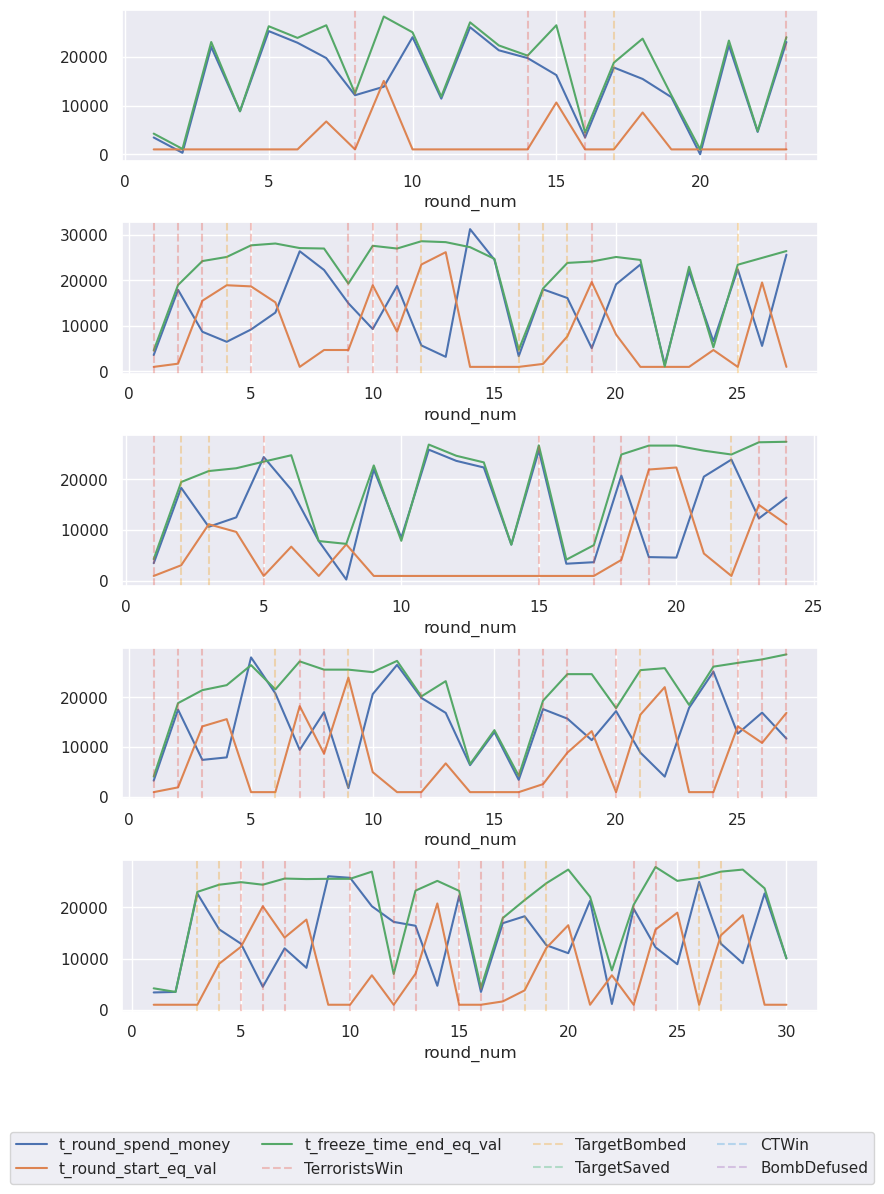

In [72]:
money_cols = ["ct_round_spend_money","ct_round_start_eq_val","ct_freeze_time_end_eq_val","t_round_spend_money","t_round_start_eq_val","t_freeze_time_end_eq_val"]
win_reason_colors = {
    'TerroristsWin': '#e74c3c',    # Bright red
    'TargetBombed': '#f39c12',     # Golden yellow
    'TargetSaved': '#27ae60',      # Emerald green
    'CTWin': '#3498db',            # Bright blue
    'BombDefused': '#9b59b6'       # Purple
}
winning_side = "t"
side_money_cols = [col for col in money_cols if col.startswith(f"{winning_side}_")]
fig,axes = plt.subplots(5,1,figsize=(8,12))
for i in range(5):
    m_r_df = rounds_sum_df.loc[selected_matches.iloc[i].match_id]
    side_money_df = m_r_df[side_money_cols+["winning_side","round_end_reason"]]
    side_money_df[side_money_cols].plot.line(ax=axes[i], legend=False)  # Don't show legend on each subplot
    
    for idx,row in side_money_df.iterrows():
        if row["winning_side"].lower()==winning_side:
            axes[i].axvline(x=idx,linestyle="--",alpha=0.3,color=win_reason_colors[row["round_end_reason"]])

# Add money lines to legend
handles, labels = axes[0].get_legend_handles_labels()

# Add win reasons to legend with simple lines
for reason, color in win_reason_colors.items():
    handles.append(plt.Line2D([0], [0], color=color, linestyle='--', alpha=0.3))
    labels.append(reason)

# Add a single legend at the bottom of the figure with all elements
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, 0), ncol=4)

# Adjust the layout to make room for the legend
plt.tight_layout()
plt.subplots_adjust(bottom=0.15)  # Adjust this value as needed

In [73]:
rounds_sum_df.round_end_reason.unique()

['TerroristsWin', 'TargetBombed', 'TargetSaved', 'CTWin', 'BombDefused']
Categories (5, object): ['BombDefused', 'CTWin', 'TargetBombed', 'TargetSaved', 'TerroristsWin']

In [74]:
e_d_r_df = rounds_sum_df[["round_end_reason","winning_side","ct_kills","t_kills","ct_deaths","t_deaths"]]
e_d_r_df

round_end_reason winning_side  \
match_id                             round_num                                 
bfa9bbbe-bd16-4713-bd99-745378db05cb 1            TerroristsWin            T   
                                     2             TargetBombed            T   
                                     3             TargetBombed            T   
                                     4              TargetSaved           CT   
                                     5                    CTWin           CT   
...                                                         ...          ...   
816e1612-9d2e-4893-af23-bda90c479598 13                   CTWin           CT   
                                     14                   CTWin           CT   
                                     15                   CTWin           CT   
                                     16             BombDefused           CT   
                                     17           TerroristsWin            T   

                                                ct_kills  t_kills  ct_deaths  \
match_id                             round_num                                 
bfa9bbbe-bd16-4713-bd99-745378db05cb 1                 3        5          5   
                                     2                 1        3          3   
                                     3                 1        3          4   
                                     4                 3        5          5   
                                     5                 5        1          1   
...                                                  ...      ...        ...   
816e1612-9d2e-4893-af23-bda90c479598 13                5        1          1   
                                     14                5        1          1   
                                     15                5        1          1   
                                     16                5        4          4   
                                     17                4        5          5   

                                                t_deaths  
match_id                             round_num            
bfa9bbbe-bd16-4713-bd99-745378db05cb 1                 3  
                                     2                 1  
                                     3                 1  
                                     4                 3  
                                     5                 5  
...                                                  ...  
816e1612-9d2e-4893-af23-bda90c479598 13                5  
                                     14                5  
                                     15                5  
                                     16                5  
                                     17                4  

[1312 rows x 6 columns]

In [75]:
e_d_r_df[(e_d_r_df.round_end_reason=="CTWin") & (e_d_r_df.t_deaths != 5)]

round_end_reason winning_side  \
match_id                             round_num                                 
d2dff070-d216-4b59-9edd-1e20e9518a8a 8                    CTWin           CT   
b9e6964c-9dc2-4d86-9a6b-be7cff8a039a 6                    CTWin           CT   
e2f49be0-bb4f-4968-b96b-a608a18bb7ba 9                    CTWin           CT   

                                                ct_kills  t_kills  ct_deaths  \
match_id                             round_num                                 
d2dff070-d216-4b59-9edd-1e20e9518a8a 8                 4        2          2   
b9e6964c-9dc2-4d86-9a6b-be7cff8a039a 6                 4        1          1   
e2f49be0-bb4f-4968-b96b-a608a18bb7ba 9                 4        1          1   

                                                t_deaths  
match_id                             round_num            
d2dff070-d216-4b59-9edd-1e20e9518a8a 8                 4  
b9e6964c-9dc2-4d86-9a6b-be7cff8a039a 6                 4  
e2f49be0-bb4f-4968-b96b-a608a18bb7ba 9                 4

In [76]:
matches = e_d_r_df[(e_d_r_df.round_end_reason=="CTWin") & (e_d_r_df.t_deaths != 5)].index.to_list()
print(matches)
matches = [p[0] for p in matches]
matches

[('d2dff070-d216-4b59-9edd-1e20e9518a8a', 8), ('b9e6964c-9dc2-4d86-9a6b-be7cff8a039a', 6), ('e2f49be0-bb4f-4968-b96b-a608a18bb7ba', 9)]


['d2dff070-d216-4b59-9edd-1e20e9518a8a',
 'b9e6964c-9dc2-4d86-9a6b-be7cff8a039a',
 'e2f49be0-bb4f-4968-b96b-a608a18bb7ba']

In [77]:
for _,match in matches_df.iterrows():
    for tm in matches:
        if match["match_id"] == tm:
            display(match)

client_name                                                      GOTV Demo
map_name                                                       de_overpass
tick_rate                                                              128
playback_ticks                                                      533569
playback_frames_count                                               532259
parsed_to_frame_idx                                                 532274
match_id                              d2dff070-d216-4b59-9edd-1e20e9518a8a
demo_id                               01be4691-e8c9-4c2a-a158-13e74e773e22
competition_name                            BLAST Premier Fall Groups 2021
hltv_url                 https://www.hltv.org/matches/2350998/astralis-...
match_date                                                   1631889000000
match_name               astralis-vs-vitality-blast-premier-fall-groups...
Name: 0, dtype: object

client_name                                                      GOTV Demo
map_name                                                        de_inferno
tick_rate                                                              128
playback_ticks                                                      494095
playback_frames_count                                               493292
parsed_to_frame_idx                                                 493312
match_id                              b9e6964c-9dc2-4d86-9a6b-be7cff8a039a
demo_id                               065d1b20-430b-41cf-9ad3-a4ccabf09d28
competition_name                            BLAST Premier World Final 2021
hltv_url                 https://www.hltv.org/matches/2353593/gambit-vs...
match_date                                                   1639510800000
match_name                 gambit-vs-heroic-blast-premier-world-final-2021
Name: 0, dtype: object

client_name                                                      GOTV Demo
map_name                                                        de_vertigo
tick_rate                                                              128
playback_ticks                                                      461326
playback_frames_count                                               459833
parsed_to_frame_idx                                                 459848
match_id                              e2f49be0-bb4f-4968-b96b-a608a18bb7ba
demo_id                               0479641c-b9fd-4dd9-9575-0d7c64700eff
competition_name                          BLAST Premier Spring Groups 2021
hltv_url                 https://www.hltv.org/matches/2346331/evil-geni...
match_date                                                   1612809000000
match_name               evil-geniuses-vs-g2-blast-premier-spring-group...
Name: 0, dtype: object

In [78]:
e_d_r_df[(e_d_r_df.round_end_reason=="TerroriWin") & (e_d_r_df.ct_deaths != 5)]

Empty DataFrame
Columns: [round_end_reason, winning_side, ct_kills, t_kills, ct_deaths, t_deaths]
Index: []

In [79]:
e_d_r_df[(e_d_r_df.round_end_reason=="BombDefused") & (e_d_r_df.winning_side != "CT")]

Empty DataFrame
Columns: [round_end_reason, winning_side, ct_kills, t_kills, ct_deaths, t_deaths]
Index: []

In [80]:
with pd.option_context('display.max_rows',20,'display.max_columns', None):
    display(idx_k_df.loc[('d2dff070-d216-4b59-9edd-1e20e9518a8a', 8)])

tick    seconds clock_time  \
match_id                             round_num                               
d2dff070-d216-4b59-9edd-1e20e9518a8a 8          5959  26.554688      01:29   
                                     8          5995  26.835938      01:29   
                                     8          6150  28.046875      01:27   
                                     8          6689  32.257812      01:23   
                                     8          6768  32.875000      01:23   
                                     8          7094  35.421875      01:20   

                                                attacker_steam_id  \
match_id                             round_num                      
d2dff070-d216-4b59-9edd-1e20e9518a8a 8               7.656120e+16   
                                     8               7.656120e+16   
                                     8               7.656120e+16   
                                     8               7.656120e+16   
                                     8               7.656120e+16   
                                     8               7.656120e+16   

                                               attacker_name attacker_team  \
match_id                             round_num                               
d2dff070-d216-4b59-9edd-1e20e9518a8a 8                 Xyp9x      Astralis   
                                     8              misutaaa  TeamVitality   
                                     8               Bubzkji      Astralis   
                                     8                Magisk      Astralis   
                                     8                Magisk      Astralis   
                                     8                 shox   TeamVitality   

                                               attacker_side   attacker_x  \
match_id                             round_num                              
d2dff070-d216-4b59-9edd-1e20e9518a8a 8                    CT  -483.284790   
                                     8                     T  -558.151367   
                                     8                    CT  -664.733337   
                                     8                    CT  -654.614685   
                                     8                    CT  -655.277039   
                                     8                     T -1017.250732   

                                                attacker_y  attacker_z  \
match_id                             round_num                           
d2dff070-d216-4b59-9edd-1e20e9518a8a 8         -139.707809    5.379532   
                                     8         -454.440430    7.832283   
                                     8          252.836273   23.889938   
                                     8          298.158112   25.474077   
                                     8          298.153137   25.459402   
                                     8         -626.854126   96.031250   

                                                attacker_view_x  \
match_id                             round_num                    
d2dff070-d216-4b59-9edd-1e20e9518a8a 8               269.170532   
                                     8                76.448364   
                                     8               279.190063   
                                     8               277.723389   
                                     8               280.343628   
                                     8                71.037598   

                                                attacker_view_y  \
match_id                             round_num                    
d2dff070-d216-4b59-9edd-1e20e9518a8a 8                 9.041748   
                                     8                 8.728638   
                                     8                 6.322632   
                                     8                 5.564575   
                                     8                 9.129639   
                             

<Axes: xlabel='round_end_reason'>

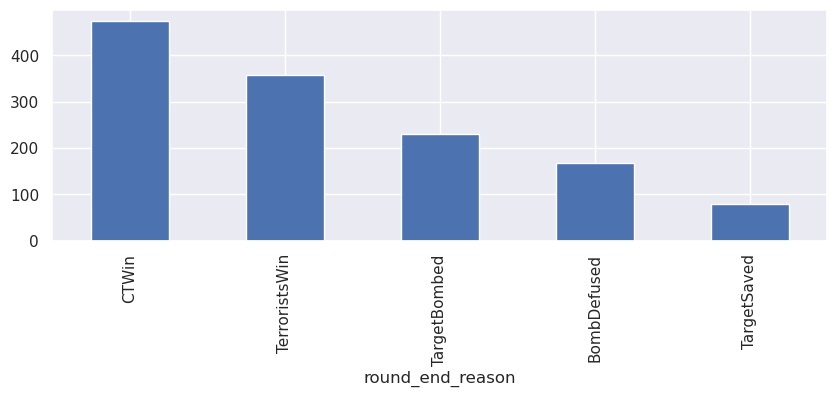

In [81]:
idx_r_df.value_counts("round_end_reason").plot.bar()

In [82]:
model_df.shape

(1312, 2)

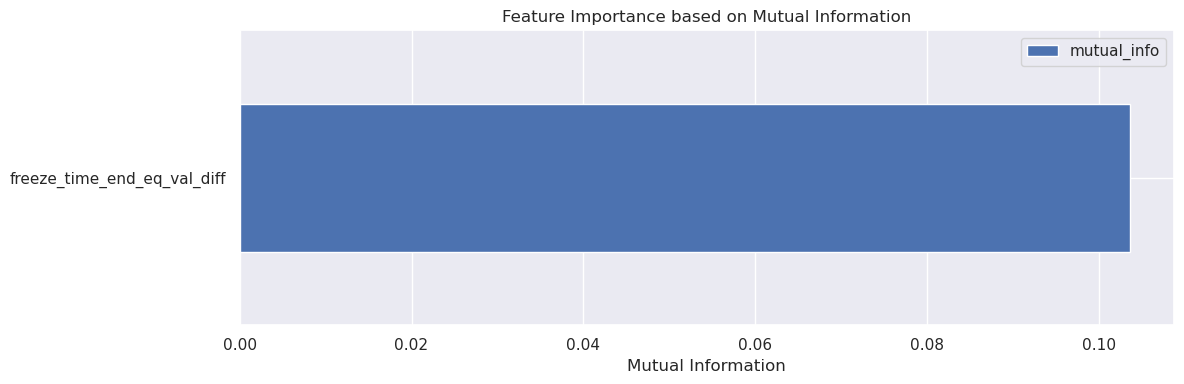

In [83]:
from sklearn.feature_selection import mutual_info_regression
import pandas as pd
import matplotlib.pyplot as plt

mutual_info_df = pd.DataFrame({
    "mutual_info": mutual_info_regression(X, y)
}, index=X.columns)
mutual_info_df.sort_values("mutual_info",inplace=True)
mutual_info_df = mutual_info_df[mutual_info_df.mutual_info > 0]

# Sort and plot
ax = mutual_info_df.plot.barh(figsize=(12, 4))

# Add labels
plt.xlabel('Mutual Information')
plt.title('Feature Importance based on Mutual Information')
plt.tight_layout()
plt.show()

In [84]:
mutual_info_df.reset_index()

index  mutual_info
0  freeze_time_end_eq_val_diff     0.103578

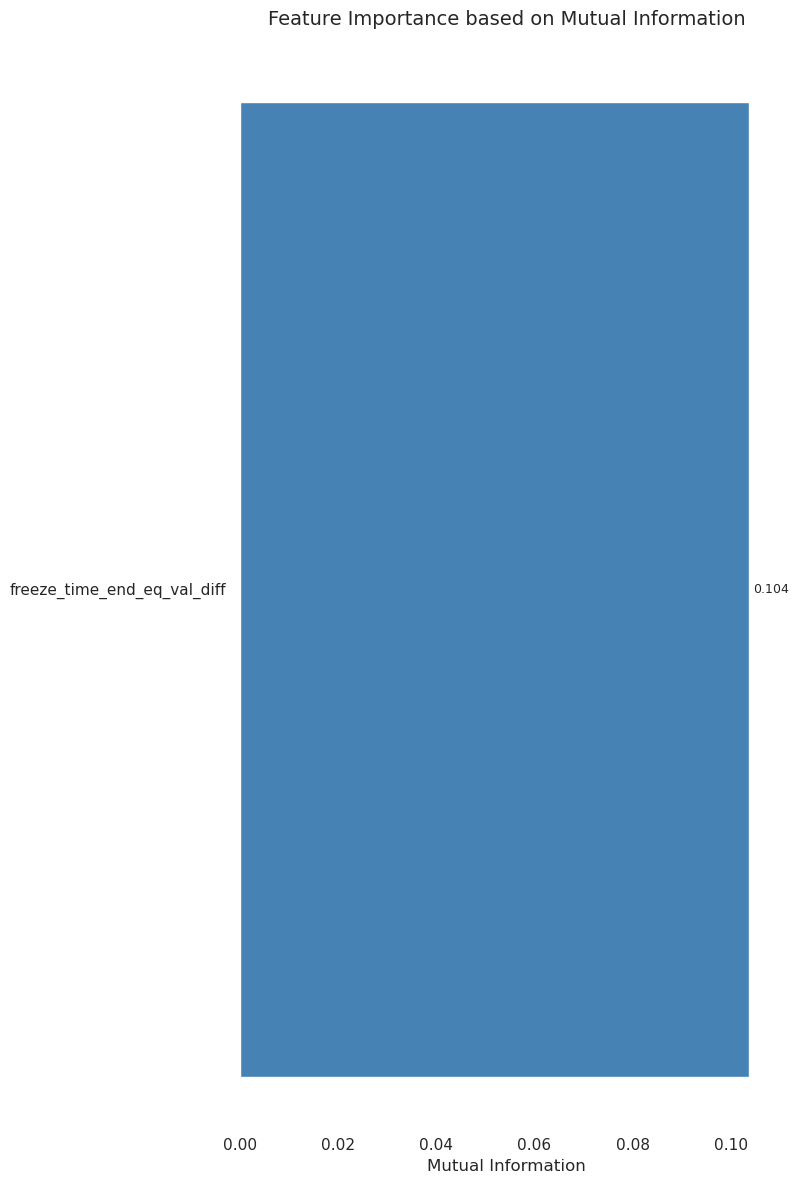

In [85]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Create horizontal bar chart with clear spacing
plt.figure(figsize=(8, 12))

# Create horizontal bars
bars = plt.barh(mutual_info_df.index,mutual_info_df['mutual_info'], color='steelblue')

# Remove the frame and add gridlines only for x-axis
plt.box(False)
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Clear formatting
plt.xlabel('Mutual Information', fontsize=12)
plt.title('Feature Importance based on Mutual Information', fontsize=14, pad=20)

# Ensure y-axis labels are readable
plt.tight_layout()

# Add value annotations
for i, bar in enumerate(bars):
    plt.text(
        bar.get_width() + 0.001,
        bar.get_y() + bar.get_height()/2,
        f'{mutual_info_df["mutual_info"].iloc[i]:.3f}',
        va='center',
        fontsize=9
    )

plt.show()

In [86]:
# from sklearn.feature_selection import mutual_info_regression
# import pandas as pd
# import matplotlib.pyplot as plt

# winning_side = "ct"  # Or it could be "t"

# # Select columns related to the winning side
# winning_side_df = model_df[[col for col in model_df.columns if col.startswith(f"{winning_side}_") or f"_{winning_side}_" in col]]

# # Calculate correlation with the winning side's economy
# winning_side_corr = winning_side_df.corr()[[f"{winning_side}_freeze_time_end_eq_val"]]
# winning_side_corr = winning_side_corr[(0.2 < abs(winning_side_corr[f"{winning_side}_freeze_time_end_eq_val"])) & (abs(winning_side_corr[f"{winning_side}_freeze_time_end_eq_val"]) < 0.95)]
# winning_side_corr.sort_values(f"{winning_side}_freeze_time_end_eq_val", ascending=True, inplace=True)

# # Create the horizontal bar plot

# if not winning_side_corr.empty:
#     # Create the horizontal bar plot
#     fig, ax = plt.subplots(figsize=(8, 12))
#     bars = winning_side_corr.plot.barh(ax=ax, legend=False)

#     # Add value labels to each bar
#     for i, bar in enumerate(bars.patches):
#         value = bar.get_width()
#         y_pos = bar.get_y() + bar.get_height() / 2
#         label = f'{value:.3f}'
#         ax.text(value + 0.01, y_pos, label, va='center', fontsize=9)

#     plt.tight_layout()
#     plt.show()
# else:
#     print("No features met the correlation threshold criteria.")


## money time series

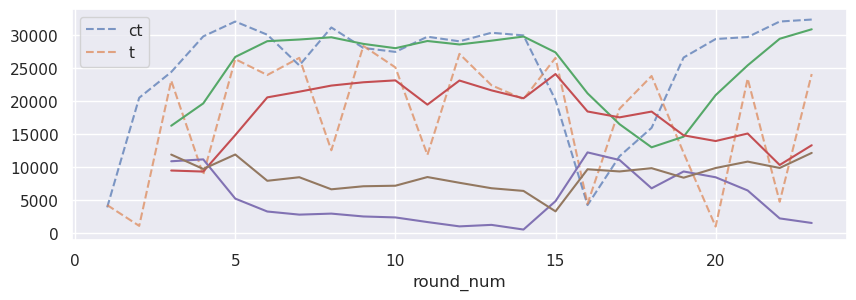

In [87]:
target_side = "ct"
round_sum_df = rounds_sum_df.loc[selected_match.match_id]
round_money_df = round_sum_df[["winning_side"]+money_cols]
fe_val_df = round_money_df[["ct_freeze_time_end_eq_val","t_freeze_time_end_eq_val"]]
fe_val_df.columns = ["ct","t"]
ax = fe_val_df.plot.line(alpha=.7,linestyle="--")

fe_val_df["ct_rolling_mean"] = fe_val_df['ct'].rolling(3,closed="both").mean()
fe_val_df["t_rolling_mean"] = fe_val_df['t'].rolling(3,closed="both").mean()
ax = fe_val_df[["ct_rolling_mean","t_rolling_mean"]].plot.line(ax=ax,legend=False)

fe_val_df["ct_rolling_std"] = fe_val_df['ct'].rolling(3,closed="both").std()
fe_val_df["t_rolling_std"] = fe_val_df['t'].rolling(3,closed="both").std()
ax = fe_val_df[["ct_rolling_std","t_rolling_std"]].plot.line(ax=ax,legend=False)

In [88]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
def adf_test_report(series, title):
    """
    Run Augmented Dickey-Fuller test and print detailed report.
    
    Parameters:
    series (pd.Series): Time series to test
    title (str): Title for the report
    
    Returns:
    dict: Results dictionary
    """
    # Run ADF test
    result = adfuller(series.dropna())
    
    # Format results in a detailed report
    print(f"\n{'='*50}")
    print(f" Augmented Dickey-Fuller Test: {title}")
    print(f"{'='*50}")
    
    # Test statistic and p-value
    print(f"ADF Test Statistic: {result[0]:.4f}")
    print(f"p-value: {result[1]:.4f}")
    
    # Critical values
    print("\nCritical Values:")
    for key, value in result[4].items():
        print(f"  {key}: {value:.4f}")
    
    # Interpretation
    if result[1] <= 0.05:
        print("\nResult: STATIONARY ✓")
        print("Interpretation: Reject the null hypothesis of non-stationarity.")
        print("The time series does not have a unit root and appears to be stationary.")
    else:
        print("\nResult: NON-STATIONARY ✗")
        print("Interpretation: Fail to reject the null hypothesis of non-stationarity.")
        print("The time series has a unit root and appears to be non-stationary.")
    
    # Additional details
    print(f"\nNumber of observations: {len(series.dropna())}")
    print(f"Number of lags used: {result[2]}")
    print(f"Number of observations used for ADF regression: {result[3]}")
    
    return result[1]<0.05

adf_test_report(fe_val_df["ct"],"ct")
adf_test_report(fe_val_df["t"],"t")


 Augmented Dickey-Fuller Test: ct
ADF Test Statistic: 0.2572
p-value: 0.9753

Critical Values:
  1%: -4.0689
  5%: -3.1271
  10%: -2.7017

Result: NON-STATIONARY ✗
Interpretation: Fail to reject the null hypothesis of non-stationarity.
The time series has a unit root and appears to be non-stationary.

Number of observations: 23
Number of lags used: 9
Number of observations used for ADF regression: 13

 Augmented Dickey-Fuller Test: t
ADF Test Statistic: -5.2619
p-value: 0.0000

Critical Values:
  1%: -3.7697
  5%: -3.0054
  10%: -2.6425

Result: STATIONARY ✓
Interpretation: Reject the null hypothesis of non-stationarity.
The time series does not have a unit root and appears to be stationary.

Number of observations: 23
Number of lags used: 0
Number of observations used for ADF regression: 22


True

now we could see that the money of this match is not stationary, so we need to make it stationary
even though we do the augmented dickey fuller test, and `t` columns is in fact stationary, we couldn't assume that since it could be cause by any random factor. In this situation, it just they just winning and losing alternatively. So we need to make all series stationary before doing the model

In [89]:
print((fe_val_df["ct"].pct_change()*100).round(2))
print((fe_val_df["t"].pct_change()*100).round(2))

round_num
1        NaN
2     425.64
3      19.02
4      22.13
5       7.55
6      -6.24
7     -15.47
8      22.64
9      -9.95
10     -2.14
11      8.38
12     -2.35
13      4.48
14     -1.32
15    -32.72
16    -78.91
17    174.12
18     36.91
19     66.77
20     10.53
21      1.02
22      7.91
23      0.94
Name: ct, dtype: float64
round_num
1         NaN
2      -74.12
3     2000.00
4      -61.69
5      197.74
6       -9.11
7       10.86
8      -52.73
9      125.90
10     -11.46
11     -52.79
12     129.11
13     -17.50
14      -9.38
15      30.79
16     -83.24
17     323.60
18      26.26
19     -48.95
20     -91.77
21    2240.00
22     -79.70
23     407.37
Name: t, dtype: float64


<Axes: title={'center': 'mu,sd'}, xlabel='round_num'>

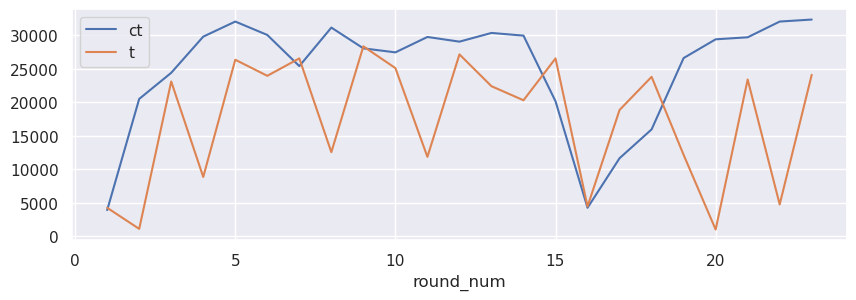

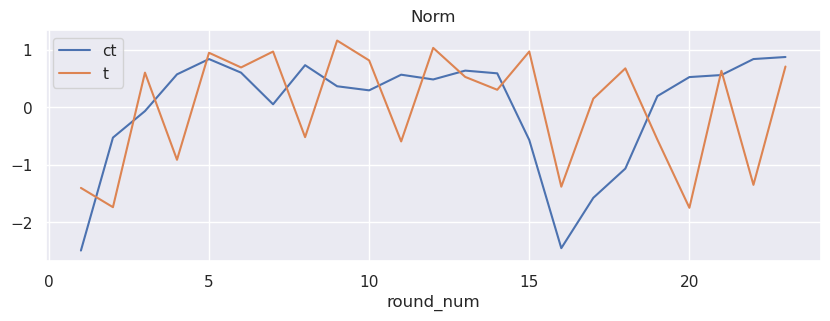

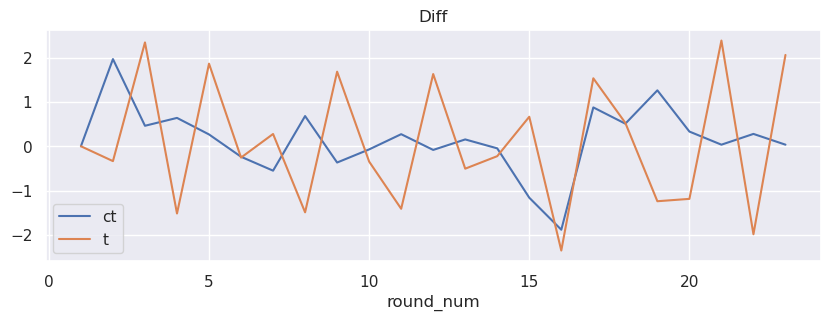

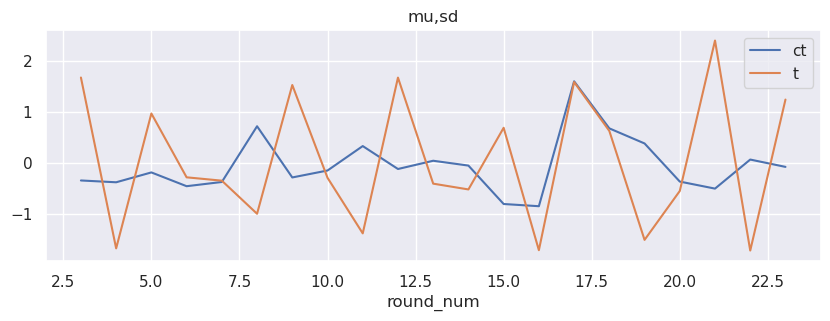

In [90]:
fe_val_df = fe_val_df[["ct","t"]]
fe_val_df.plot.line()
norm_fe_val_df = fe_val_df.copy()

for col in fe_val_df.columns:
    norm_fe_val_df[col] = (fe_val_df[col] - fe_val_df[col].mean())/fe_val_df[col].std()
    
norm_fe_val_df.plot.line(title="Norm")
    
diff_fe_val_df = norm_fe_val_df.diff().fillna(0)
diff_fe_val_df.plot.line(title="Diff")

c_fe_val_df = diff_fe_val_df.copy()
for col in ["ct","t"]:
#     c_fe_val_df[f"{col}_r_sd"] = c_fe_val_df[col].rolling(2).std()
#     c_fe_val_df[col] = c_fe_val_df[col] / c_fe_val_df[f"{col}_r_sd"]
    
    c_fe_val_df[f"{col}_r_m"] = c_fe_val_df[col].rolling(3).mean()
    c_fe_val_df[col] = c_fe_val_df[col] - c_fe_val_df[f"{col}_r_m"]
c_fe_val_df.dropna(inplace=True)
c_fe_val_df[["ct","t"]].plot.line(title="mu,sd")


In [91]:
adf_test_report(c_fe_val_df["ct"],"ct")
adf_test_report(c_fe_val_df["t"],"t")


 Augmented Dickey-Fuller Test: ct
ADF Test Statistic: -1.3487
p-value: 0.6066

Critical Values:
  1%: -4.1378
  5%: -3.1550
  10%: -2.7145

Result: NON-STATIONARY ✗
Interpretation: Fail to reject the null hypothesis of non-stationarity.
The time series has a unit root and appears to be non-stationary.

Number of observations: 21
Number of lags used: 8
Number of observations used for ADF regression: 12

 Augmented Dickey-Fuller Test: t
ADF Test Statistic: -3.2069
p-value: 0.0196

Critical Values:
  1%: -4.1378
  5%: -3.1550
  10%: -2.7145

Result: STATIONARY ✓
Interpretation: Reject the null hypothesis of non-stationarity.
The time series does not have a unit root and appears to be stationary.

Number of observations: 21
Number of lags used: 8
Number of observations used for ADF regression: 12


True


ADF Test for Original Data:

 Augmented Dickey-Fuller Test: CT - Original
ADF Test Statistic: 0.2572
p-value: 0.9753

Critical Values:
  1%: -4.0689
  5%: -3.1271
  10%: -2.7017

Result: NON-STATIONARY ✗
Interpretation: Fail to reject the null hypothesis of non-stationarity.
The time series has a unit root and appears to be non-stationary.

Number of observations: 23
Number of lags used: 9
Number of observations used for ADF regression: 13

 Augmented Dickey-Fuller Test: T - Original
ADF Test Statistic: -5.2619
p-value: 0.0000

Critical Values:
  1%: -3.7697
  5%: -3.0054
  10%: -2.6425

Result: STATIONARY ✓
Interpretation: Reject the null hypothesis of non-stationarity.
The time series does not have a unit root and appears to be stationary.

Number of observations: 23
Number of lags used: 0
Number of observations used for ADF regression: 22

ADF Test for Log-transformed Data:

 Augmented Dickey-Fuller Test: CT - Log
ADF Test Statistic: -4.2074
p-value: 0.0006

Critical Values:
  1%: 

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

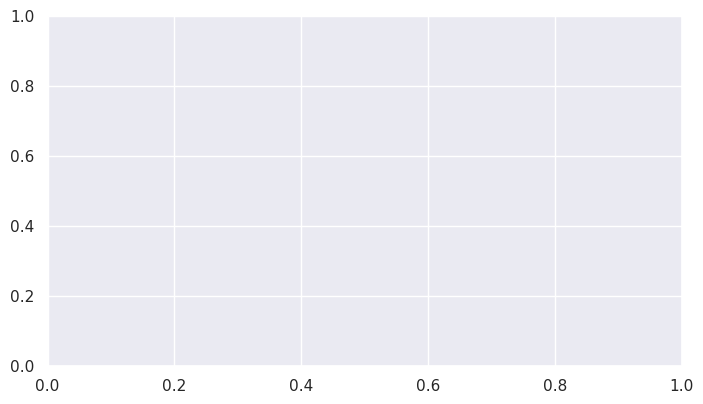

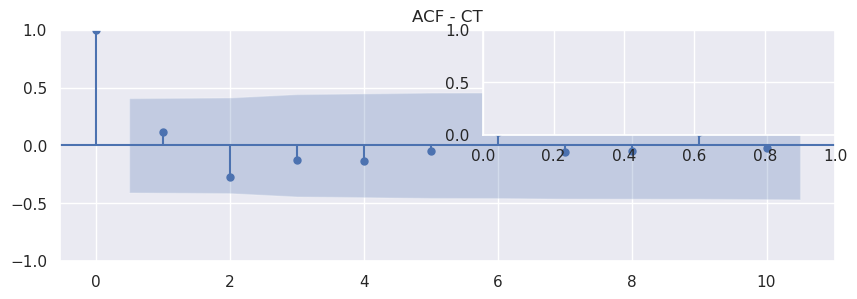

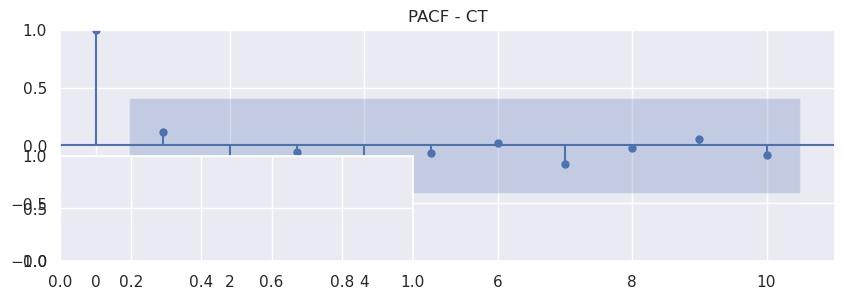

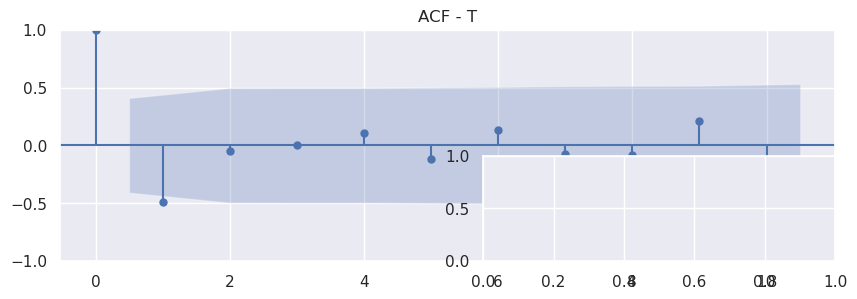

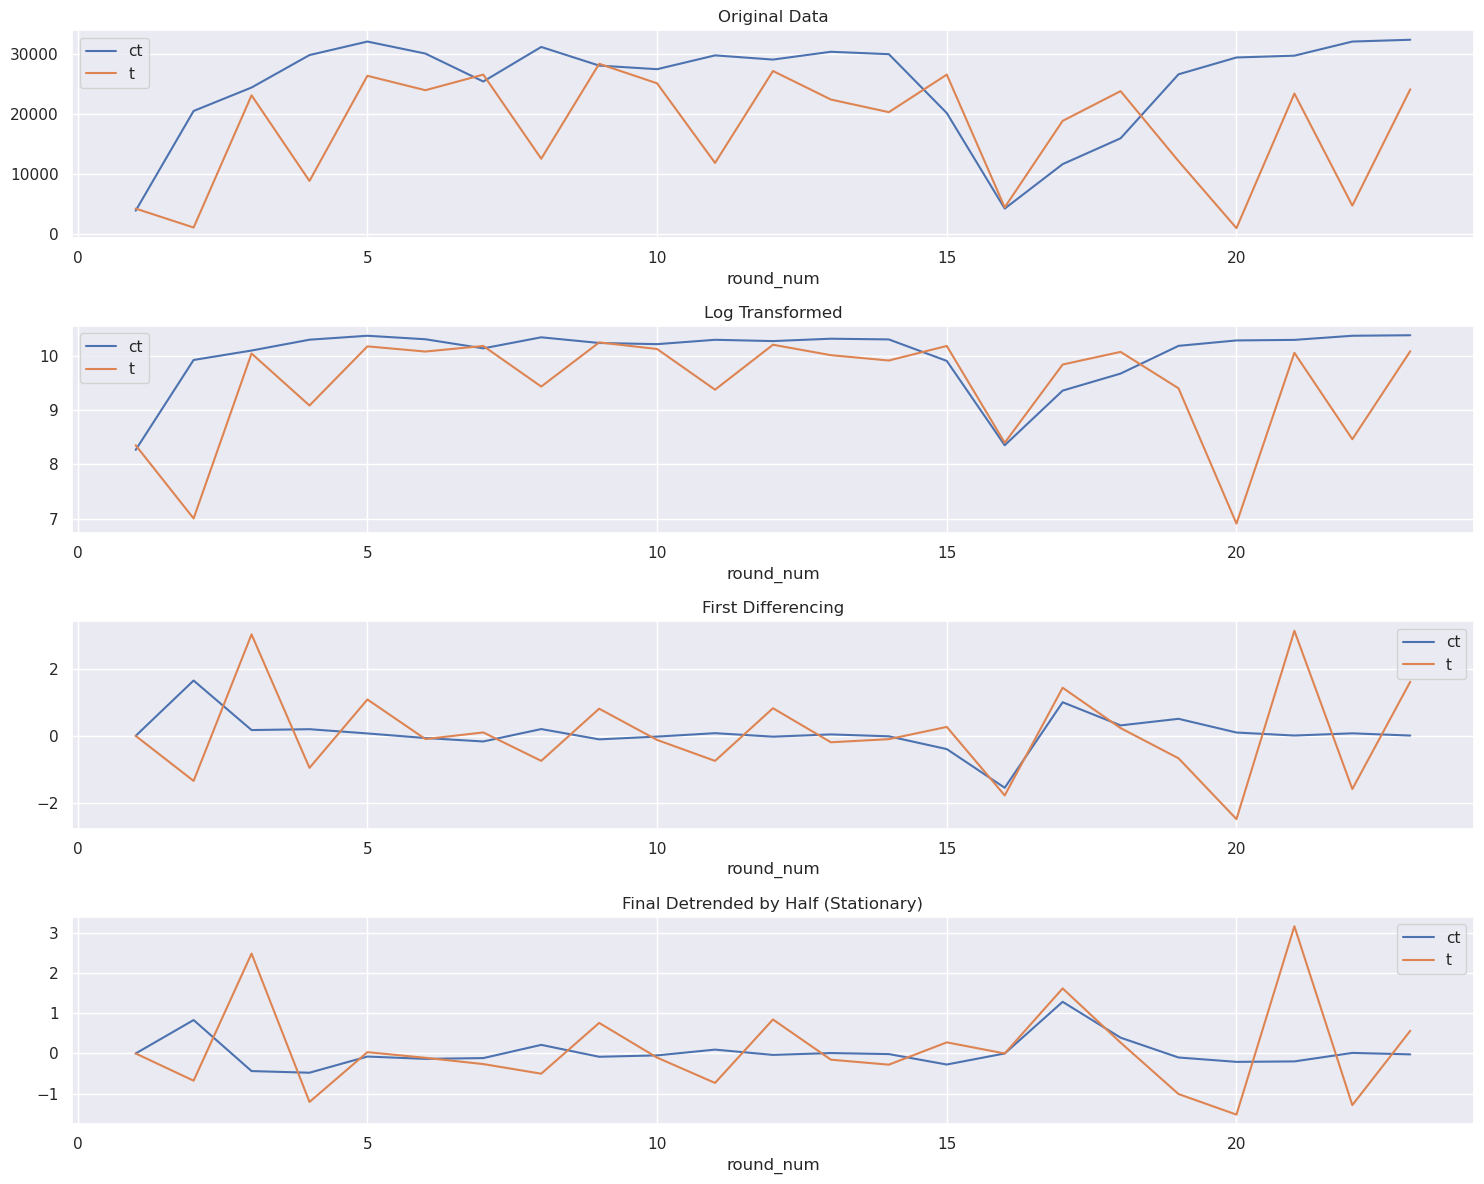


Final modeling data shape: (23, 10)
Final modeling dataframe columns: ['ct', 't', 'half', 'rounds_since_half_start', 'log_ct', 'log_t', 'diff_ct', 'diff_t', 'stationary_ct', 'stationary_t']
First few rows of modeling data:
              ct      t  half  rounds_since_half_start     log_ct      log_t  \
round_num                                                                      
1           3900   4250     0                        1   8.268988   8.354910   
2          20500   1100     0                        2   9.928229   7.003974   
3          24400  23100     0                        3  10.102379  10.047631   
4          29800   8850     0                        4  10.302297   9.088285   
5          32050  26350     0                        5  10.375084  10.179261   

            diff_ct    diff_t  stationary_ct  stationary_t  
round_num                                                   
1          0.000000  0.000000       0.000000      0.000000  
2          1.659241 -1.350936   

In [92]:
# Assuming your data is in fe_val_df with columns "ct" and "t"
# Let's make a copy to work with
df = fe_val_df.copy()

# Add CS:GO-specific context features
# 1. Add half indicator (first half vs second half)
df['half'] = (df.index >= 16).astype(int)  # 0 for first half, 1 for second half

# 2. Add rounds since half start - captures economic progression within a half
df['rounds_since_half_start'] = df.index % 15

# Plot original data with half indicator
plt.figure(figsize=(12, 6))
ax = df[['ct', 't']].plot(title="Original Data with Half Indicator")
for i in range(len(df)):
    if i > 0 and df['half'].iloc[i] == 1 and df['half'].iloc[i-1] == 0:
        ax.axvline(x=i, color='r', linestyle='--', alpha=0.7, label='Half Switch')
plt.legend()
plt.close()

# 1. Apply log transformation to stabilize variance
# Adding 1 to avoid log(0) issues
df_log = df.copy()
df_log['ct'] = np.log1p(df['ct'])
df_log['t'] = np.log1p(df['t'])

# Plot log-transformed data
plt.figure(figsize=(12, 6))
df_log[['ct', 't']].plot(title="Log-transformed Data")
plt.close()

# 2. Apply first-order differencing to remove trends
df_diff = df_log.copy()
df_diff['ct'] = df_log['ct'].diff().fillna(0)
df_diff['t'] = df_log['t'].diff().fillna(0)

# Plot first-differenced data
plt.figure(figsize=(12, 6))
df_diff[['ct', 't']].plot(title="First Differencing")
plt.close()

# 3. Detrend within each half separately
df_detrended = df_diff.copy()
for half in [0, 1]:
    half_mask = df['half'] == half
    if sum(half_mask) > 3:  # Need at least a few points to calculate rolling stats
        for col in ['ct', 't']:
            # Calculate rolling mean only within each half
            rolling_mean = df_diff.loc[half_mask, col].rolling(window=3, min_periods=1).mean()
            df_detrended.loc[half_mask, col] = df_diff.loc[half_mask, col] - rolling_mean

# Add reset indicators for half transitions to handle potential discontinuities
df_detrended['reset_indicator'] = ((df['half'].diff() == 1) | (df.index == 0)).astype(int)

# Plot detrended data
plt.figure(figsize=(12, 6))
df_detrended[['ct', 't']].plot(title="Detrended by Half")
plt.close()

# 4. Optional: Apply specific adjustments for round start/transition points
# Adjust the first round of each half to reduce the impact of resets
for i in range(len(df_detrended)):
    if df_detrended['reset_indicator'].iloc[i] == 1:
        # For rounds right after a reset, use a more conservative value
        for col in ['ct', 't']:
            df_detrended.loc[df_detrended.index[i], col] = 0

# 5. Check for stationarity using your existing adf_test_report function
print("\nADF Test for Original Data:")
adf_test_report(df['ct'], "CT - Original")
adf_test_report(df['t'], "T - Original")

print("\nADF Test for Log-transformed Data:")
adf_test_report(df_log['ct'], "CT - Log")
adf_test_report(df_log['t'], "T - Log")

print("\nADF Test for First Differenced Data:")
adf_test_report(df_diff['ct'].dropna(), "CT - Diff")
adf_test_report(df_diff['t'].dropna(), "T - Diff")

print("\nADF Test for Detrended Data:")
adf_test_report(df_detrended['ct'].dropna(), "CT - Detrended")
adf_test_report(df_detrended['t'].dropna(), "T - Detrended")

# 6. Visualize autocorrelation to confirm stationarity
plt.figure(figsize=(18, 10))
plt.subplot(221)
plot_acf(df_detrended['ct'].dropna(), lags=min(10, len(df_detrended)//2), title="ACF - CT")
plt.subplot(222)
plot_pacf(df_detrended['ct'].dropna(), lags=min(10, len(df_detrended)//2), title="PACF - CT")
plt.subplot(223)
plot_acf(df_detrended['t'].dropna(), lags=min(10, len(df_detrended)//2), title="ACF - T")
plt.subplot(224)
plot_pacf(df_detrended['t'].dropna(), lags=min(10, len(df_detrended)//2), title="PACF - T")
plt.tight_layout()
plt.close()

# 7. Create a dataframe with all transformations
modeling_df = df.copy()
modeling_df['log_ct'] = df_log['ct']
modeling_df['log_t'] = df_log['t'] 
modeling_df['diff_ct'] = df_diff['ct']
modeling_df['diff_t'] = df_diff['t']
modeling_df['stationary_ct'] = df_detrended['ct']
modeling_df['stationary_t'] = df_detrended['t']

# Create a comparison plot of all transformations
plt.figure(figsize=(15, 12))

plt.subplot(411)
df[['ct', 't']].plot(ax=plt.gca(), title="Original Data")

plt.subplot(412)
df_log[['ct', 't']].plot(ax=plt.gca(), title="Log Transformed")

plt.subplot(413)
df_diff[['ct', 't']].plot(ax=plt.gca(), title="First Differencing")

plt.subplot(414)
df_detrended[['ct', 't']].plot(ax=plt.gca(), title="Final Detrended by Half (Stationary)")

plt.tight_layout()
plt.show()  # This will display plots interactively but not save them

# Return the final modeling dataframe with all transformations
print("\nFinal modeling data shape:", modeling_df.shape)
print("Final modeling dataframe columns:", modeling_df.columns.tolist())
print("First few rows of modeling data:")
print(modeling_df.head())

# Return the stationary version of the data
stationary_df = df_detrended[['ct', 't']].copy()
print("\nStationary data shape:", stationary_df.shape)
print("First few rows of stationary data:")
print(stationary_df.head())

In [93]:
def transform_money_series(series, series_name, df_index, half_series=None):
    """
    Transform a money series (either 'ct' or 't') based on the preprocessing steps.
    
    Parameters:
    - series: pd.Series - The input series to transform
    - series_name: str - Name of the series ('ct' or 't')
    - df_index: pd.Index - The index of the parent dataframe (for position calculations)
    - half_series: pd.Series - Optional series indicating which half of the game each row belongs to
    
    Returns:
    - pd.Series - The transformed series
    """
    # Create a copy to avoid modifying the original
    result = series.copy()
    
    # Apply log transformation
    result = np.log1p(result)
    
    # Calculate difference
    result = result.diff().fillna(0)
    
    # If half_series is provided, apply half-specific rolling mean subtraction
    if half_series is not None:
        for half in [0, 1]:
            half_mask = half_series == half
            if sum(half_mask) > 3:
                rolling_mean = result[half_mask].rolling(window=3, min_periods=1).mean()
                result[half_mask] = result[half_mask] - rolling_mean
    
    # Handle reset points
    if half_series is not None:
        reset_indicator = ((half_series.diff() == 1) | (df_index == df_index[0])).astype(int)
        reset_indices = df_index[reset_indicator == 1]
        for idx in reset_indices:
            result.loc[idx] = 0
            
    return result

def clean_money_df(money_df):
    """
    Original function rewritten to use the transform_money_series function
    """
    df = money_df.copy()

    val_cols = df.columns
    
    # Create helper columns
    df['half'] = (df.index >= 16).astype(int)
    df['rounds_since_half_start'] = df.index % 15
    
    # Transform money columns
    for col in val_cols:
        df[col] = transform_money_series(df[col],col,df.index,df['half'])
    
    # Add reset indicator
    df['reset_indicator'] = ((df['half'].diff() == 1) | (df.index == 0)).astype(int)
    
    return df

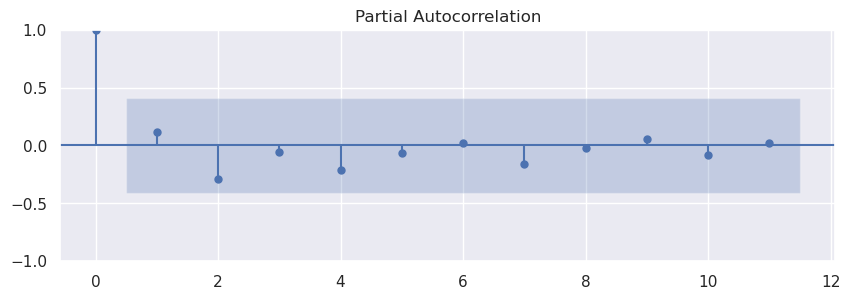

In [94]:
c_fe_df = clean_money_df(fe_val_df)
plot_pacf(c_fe_df["ct"])
plt.show()

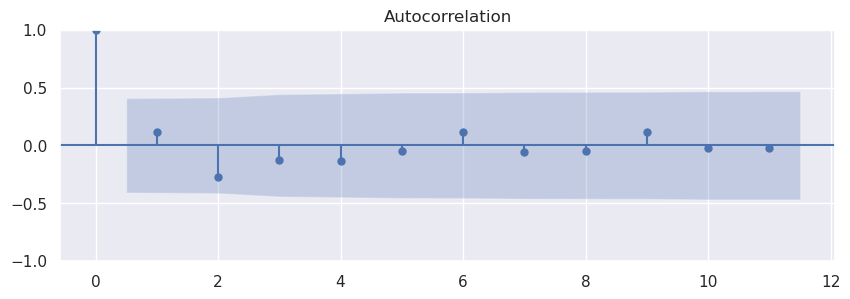

In [95]:
plot_acf(c_fe_df["ct"])
plt.show()

this might be the sign to give up on time series analysis since our setup of data is quite different and the `acf` and `pacf` doesn't show that lag value do a significant on correlation.

# grade boost with lag for win

In [96]:
rounds_sum_df

n_ticks  bomb_plant_tick  \
match_id                             round_num                             
bfa9bbbe-bd16-4713-bd99-745378db05cb 1            13026             9411   
                                     2            29455            24206   
                                     3            51519            46270   
                                     4            98753               -1   
                                     5           113164               -1   
...                                                 ...              ...   
816e1612-9d2e-4893-af23-bda90c479598 13          183596               -1   
                                     14          197648               -1   
                                     15          208908               -1   
                                     16          254837           250353   
                                     17          270761               -1   

                                               winning_side round_end_reason  \
match_id                             round_num                                 
bfa9bbbe-bd16-4713-bd99-745378db05cb 1                    T    TerroristsWin   
                                     2                    T     TargetBombed   
                                     3                    T     TargetBombed   
                                     4                   CT      TargetSaved   
                                     5                   CT            CTWin   
...                                                     ...              ...   
816e1612-9d2e-4893-af23-bda90c479598 13                  CT            CTWin   
                                     14                  CT            CTWin   
                                     15                  CT            CTWin   
                                     16                  CT      BombDefused   
                                     17                   T    TerroristsWin   

                                                ct_round_spend_money  \
match_id                             round_num                         
bfa9bbbe-bd16-4713-bd99-745378db05cb 1                          3300   
                                     2                         10200   
                                     3                          1300   
                                     4                         26050   
                                     5                         17350   
...                                                              ...   
816e1612-9d2e-4893-af23-bda90c479598 13                        22350   
                                     14                         9000   
                                     15                        12450   
                                     16                         3350   
                                     17                        19450   

                                               ct_buy_type  \
match_id                             round_num               
bfa9bbbe-bd16-4713-bd99-745378db05cb 1            Full Eco   
                                     2            Semi Buy   
                                     3            Semi Eco   
                                     4            Full Buy   
                                     5            Semi Buy   
...                                                    ...   
816e1612-9d2e-4893-af23-bda90c479598 13           Full Buy   
                                     14           Full Buy   
                                     15           Full Buy   
                                     16           Full Eco   
                                     17           Semi Buy   

                                                ct_round_start_eq_val  \
match_id                             round_num                          
bfa9bbbe-bd16-4713-bd99-745378db05cb 1                           1000   
                                     2                 

In [97]:
def create_lag(df, lag=1, subset=None):
    result = df.copy()
    
    if subset is None:
        subset = df.columns.tolist()
    
    lag_cols_all = []
    for l in range(1, lag + 1):
        lag_cols = [f"{col}_lag{l}" for col in subset]
        lag_cols_all.extend(lag_cols)
        
    for col in lag_cols_all:
        result[col] = float('nan')
    
    unique_matches = df.index.get_level_values('match_id').unique()
    
    for match_id in unique_matches:
        match_rows = result.loc[match_id]
        
        for l in range(1, lag + 1):
            for col in subset:
                lag_col = f"{col}_lag{l}"
                result.loc[match_id, lag_col] = match_rows[col].shift(l).values
    
    return result

In [98]:
lag_df = create_lag(reduced_rounds_sum_df,2)
lag_df = lag_df[[col for col in lag_df.columns if "_lag" in col or col in start_round_cols]+["winning_side"]]
display(lag_df.head(6))

ct_freeze_time_end_eq_val  \
match_id                             round_num                              
bfa9bbbe-bd16-4713-bd99-745378db05cb 1                               4300   
                                     2                              10600   
                                     3                               5300   
                                     4                              27450   
                                     5                              18350   
                                     6                              30550   

                                                t_freeze_time_end_eq_val  \
match_id                             round_num                             
bfa9bbbe-bd16-4713-bd99-745378db05cb 1                              4350   
                                     2                             18000   
                                     3                             22000   
                                     4                             27550   
                                     5                             26650   
                                     6                              2150   

                                                n_ticks_lag1  \
match_id                             round_num                 
bfa9bbbe-bd16-4713-bd99-745378db05cb 1                   NaN   
                                     2               13026.0   
                                     3               29455.0   
                                     4               51519.0   
                                     5               98753.0   
                                     6              113164.0   

                                                bomb_plant_tick_lag1  \
match_id                             round_num                         
bfa9bbbe-bd16-4713-bd99-745378db05cb 1                           NaN   
                                     2                        9411.0   
                                     3                       24206.0   
                                     4                       46270.0   
                                     5                          -1.0   
                                     6                          -1.0   

                                                winning_side_lag1  \
match_id                             round_num                      
bfa9bbbe-bd16-4713-bd99-745378db05cb 1                        NaN   
                                     2                        0.0   
                                     3                        0.0   
                                     4                        0.0   
                                     5                        1.0   
                                     6                        1.0   

                                                ct_freeze_time_end_eq_val_lag1  \
match_id                             round_num                                   
bfa9bbbe-bd16-4713-bd99-745378db05cb 1                                     NaN   
                                     2                                  4300.0   
                                     3                                 10600.0   
                                     4                                  5300.0   
                                     5                                 27450.0   
                                     6                                 18350.0   

                                                t_freeze_time_end_eq_val_lag1  \
match_id                             round_num                                  
bfa9bbbe-bd16-4713-bd99-745378db05cb 1                                    NaN   
                                     2                                 4350.0   
                                     3                                18000.0   
                                     4                                22000.0   
                                    

In [99]:
for col in lag_df.select_dtypes(include=["object","category"]):
    lag_df[col] = lag_df[col].astype('category')

In [100]:
num_cols = lag_df.select_dtypes(exclude=['object','category']).columns.to_list()
cat_cols = lag_df.select_dtypes(include=['object','category']).columns.to_list()
num_cols.remove("winning_side")
print(num_cols)
print(cat_cols)

['ct_freeze_time_end_eq_val', 't_freeze_time_end_eq_val', 'n_ticks_lag1', 'bomb_plant_tick_lag1', 'winning_side_lag1', 'ct_freeze_time_end_eq_val_lag1', 't_freeze_time_end_eq_val_lag1', 'ct_flash_opp_lag1', 't_flash_opp_lag1', 'ct_flashed_lag1', 't_flashed_lag1', 'ct_avg_flash_duration_lag1', 't_avg_flash_duration_lag1', 'ct_kills_lag1', 't_kills_lag1', 'ct_first_kill_lag1', 'ct_hs_prob_lag1', 't_hs_prob_lag1', 'ct_trade_prob_lag1', 't_trade_prob_lag1', 'ct_flash_kill_prob_lag1', 't_flash_kill_prob_lag1', 'ct_assist_prob_lag1', 't_assist_prob_lag1', 'ct_kast_prob_lag1', 't_kast_prob_lag1', 'ct_shot_fires_lag1', 't_shot_fires_lag1', 'ct_shot_connected_prob_lag1', 't_shot_connected_prob_lag1', 'ct_he_grenade_lag1', 'ct_decoy_grenade_lag1', 'ct_flashbang_lag1', 'ct_smoke_grenade_lag1', 't_flashbang_lag1', 't_smoke_grenade_lag1', 't_he_grenade_lag1', 't_decoy_grenade_lag1', 'ct_grenade_connected_prob_lag1', 't_grenade_connected_prob_lag1', 'ct_fire_grenade_lag1', 't_fire_grenade_lag1', 'ro

In [101]:
lag_df[num_cols] = lag_df[num_cols].fillna(-1)

In [102]:
X = lag_df.drop("winning_side",axis=1)
y = lag_df.winning_side
X_train, X_test, y_train, y_test_match = train_test_split(X, y, test_size=0.2, random_state=42)

In [103]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Create the column transformer with StandardScaler for numeric columns and OneHotEncoder for categorical columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), cat_cols),
    ],
    remainder="passthrough"
    
).set_output(transform="pandas")

# To use it:
# X_transformed = preprocessor.fit_transform(rounds_sum_df)

In [104]:
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

In [105]:
display(X_train.head(5))

num__ct_freeze_time_end_eq_val  \
match_id                             round_num                                   
9299c0e4-9d62-4c3a-ac5b-fca5b61431df 12                               0.790561   
e0bf3c83-af14-4f74-aa93-827dc28d9c11 9                                0.840643   
1625f047-b597-403d-b9c4-0660138852ca 20                              -0.065847   
d2dff070-d216-4b59-9edd-1e20e9518a8a 20                               0.540149   
                                     10                              -0.892205   

                                                num__t_freeze_time_end_eq_val  \
match_id                             round_num                                  
9299c0e4-9d62-4c3a-ac5b-fca5b61431df 12                             -1.374355   
e0bf3c83-af14-4f74-aa93-827dc28d9c11 9                              -0.918912   
1625f047-b597-403d-b9c4-0660138852ca 20                              0.412829   
d2dff070-d216-4b59-9edd-1e20e9518a8a 20                              0.009271   
                                     10                              0.666494   

                                                num__n_ticks_lag1  \
match_id                             round_num                      
9299c0e4-9d62-4c3a-ac5b-fca5b61431df 12                 -0.310175   
e0bf3c83-af14-4f74-aa93-827dc28d9c11 9                  -0.692416   
1625f047-b597-403d-b9c4-0660138852ca 20                  0.647258   
d2dff070-d216-4b59-9edd-1e20e9518a8a 20                  0.979167   
                                     10                 -0.308521   

                                                num__bomb_plant_tick_lag1  \
match_id                             round_num                              
9299c0e4-9d62-4c3a-ac5b-fca5b61431df 12                         -0.719017   
e0bf3c83-af14-4f74-aa93-827dc28d9c11 9                          -0.719017   
1625f047-b597-403d-b9c4-0660138852ca 20                         -0.719017   
d2dff070-d216-4b59-9edd-1e20e9518a8a 20                         -0.719017   
                                     10                          0.432906   

                                                num__winning_side_lag1  \
match_id                             round_num                           
9299c0e4-9d62-4c3a-ac5b-fca5b61431df 12                        0.87859   
e0bf3c83-af14-4f74-aa93-827dc28d9c11 9                         0.87859   
1625f047-b597-403d-b9c4-0660138852ca 20                       -0.85708   
d2dff070-d216-4b59-9edd-1e20e9518a8a 20                        0.87859   
                                     10                       -0.85708   

                                                num__ct_freeze_time_end_eq_val_lag1  \
match_id                             round_num                                        
9299c0e4-9d62-4c3a-ac5b-fca5b61431df 12                                    0.821233   
e0bf3c83-af14-4f74-aa93-827dc28d9c11 9                                     0.913594   
1625f047-b597-403d-b9c4-0660138852ca 20                                   -1.935728   
d2dff070-d216-4b59-9edd-1e20e9518a8a 20                                    0.160855   
                                     10                                    0.405611   

                                                num__t_freeze_time_end_eq_val_lag1  \
match_id                             round_num                                       
9299c0e4-9d62-4c3a-ac5b-fca5b61431df 12                                   0.886147   
e0bf3c83-af14-4f74-aa93-827dc28d9c11 9                                    0.022843   
1625f047-b597-403d-b9c4-0660138852ca 20                                   0.462538   
d2dff070-d216-4b59-9edd-1e20e9518a8a 20                                   0.462538   
                                     10                                   0.537608   

                                                num__ct_flash_opp_lag1  \
match_id                             round_num                           
9

In [106]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from xgboost import XGBClassifier
import numpy as np

# Step 1: Define your parameter grid
param_dist = {
    'learning_rate': np.linspace(0.01, 0.3, 30),
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [3, 4, 5, 6, 7, 8],
    'min_child_weight': [1, 3, 5, 7],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0]
}

# Step 2: Set up your model
xgb_model = XGBClassifier(
    enable_categorical=True,
    objective='binary:logistic',
    random_state=42,
    use_label_encoder=False,  # Optional depending on your XGBoost version
    eval_metric='logloss'     # Also optional, for warnings
)

# Step 3: Set up RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=10,              # Number of parameter settings sampled
    scoring='accuracy',     # You can change this to 'roc_auc' etc.
    cv=5,                   # 5-fold cross validation
    verbose=False,
    random_state=42,
    n_jobs=-1               # Use all cores
)

# Step 5: Fit RandomizedSearchCV
random_search.fit(X_train, y_train)

# Step 6: Best model
best_model = random_search.best_estimator_

# Step 7: Make predictions on test data
y_pred = best_model.predict(X_test)

# Step 8: Evaluate
accuracy = accuracy_score(y_test_match, y_pred)
print(f"Best Parameters: {random_search.best_params_}")
print(f"Accuracy: {accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(y_test_match, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test_match, y_pred))

# Step 9 (Optional): Cross-validation for more robust evaluation
cv_scores = cross_val_score(best_model, X, y, cv=5)
print(f"\nCross-validation scores: {cv_scores}")
print(f"Mean CV accuracy: {cv_scores.mean():.4f}")


Best Parameters: {'subsample': 0.8, 'n_estimators': 100, 'min_child_weight': 7, 'max_depth': 8, 'learning_rate': 0.05999999999999999, 'gamma': 0, 'colsample_bytree': 0.8}
Accuracy: 0.6654

Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.62      0.61       112
           1       0.71      0.70      0.71       151

    accuracy                           0.67       263
   macro avg       0.66      0.66      0.66       263
weighted avg       0.67      0.67      0.67       263


Confusion Matrix:
[[ 69  43]
 [ 45 106]]

Cross-validation scores: [0.6121673  0.68821293 0.61450382 0.63358779 0.67557252]
Mean CV accuracy: 0.6448


In [107]:
# Get feature importance dictionary
importance = best_model.get_booster().get_score(importance_type='weight')
print(importance)

{'num__ct_freeze_time_end_eq_val': 107.0, 'num__t_freeze_time_end_eq_val': 115.0, 'num__n_ticks_lag1': 37.0, 'num__bomb_plant_tick_lag1': 22.0, 'num__winning_side_lag1': 3.0, 'num__ct_freeze_time_end_eq_val_lag1': 21.0, 'num__t_freeze_time_end_eq_val_lag1': 29.0, 'num__ct_flash_opp_lag1': 20.0, 'num__t_flash_opp_lag1': 28.0, 'num__ct_flashed_lag1': 31.0, 'num__t_flashed_lag1': 41.0, 'num__ct_avg_flash_duration_lag1': 33.0, 'num__t_avg_flash_duration_lag1': 48.0, 'num__ct_kills_lag1': 8.0, 'num__t_kills_lag1': 16.0, 'num__ct_first_kill_lag1': 4.0, 'num__ct_hs_prob_lag1': 23.0, 'num__t_hs_prob_lag1': 32.0, 'num__ct_trade_prob_lag1': 6.0, 'num__t_trade_prob_lag1': 12.0, 'num__ct_flash_kill_prob_lag1': 3.0, 'num__t_flash_kill_prob_lag1': 7.0, 'num__ct_assist_prob_lag1': 17.0, 'num__t_assist_prob_lag1': 10.0, 'num__ct_kast_prob_lag1': 3.0, 'num__t_kast_prob_lag1': 12.0, 'num__ct_shot_fires_lag1': 34.0, 'num__t_shot_fires_lag1': 49.0, 'num__ct_shot_connected_prob_lag1': 45.0, 'num__t_shot_co

In [108]:
importance_df = pd.DataFrame({
    'Feature': list(importance.keys()),
    'Importance': list(importance.values())
}).sort_values(by='Importance', ascending=False)

display(importance_df)

Feature  Importance
1              num__t_freeze_time_end_eq_val       115.0
0             num__ct_freeze_time_end_eq_val       107.0
69           num__t_shot_connected_prob_lag2        62.0
51           num__ct_avg_flash_duration_lag2        54.0
27                    num__t_shot_fires_lag1        49.0
..                                       ...         ...
44                    num__winning_side_lag2         2.0
82  num__round_end_reason_TerroristsWin_lag2         2.0
39          num__round_end_reason_CTWin_lag1         1.0
72                num__ct_smoke_grenade_lag2         1.0
76                 num__t_decoy_grenade_lag2         1.0

[83 rows x 2 columns]

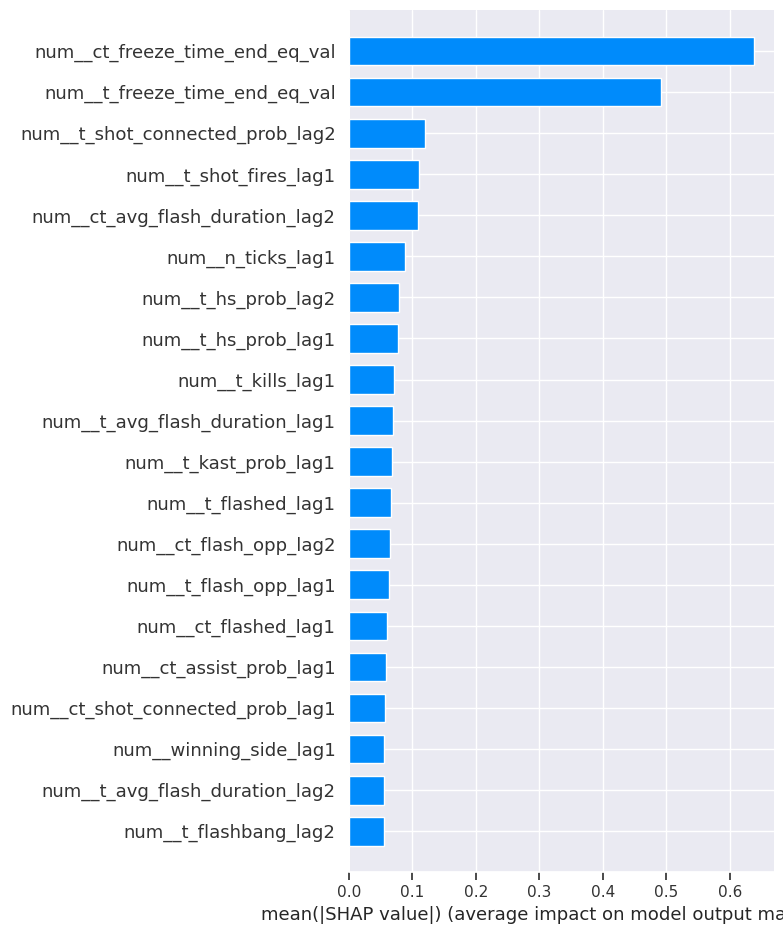

In [109]:
import shap

# Step 1: Create the SHAP explainer
explainer = shap.Explainer(best_model)

# Step 2: Calculate SHAP values
shap_values = explainer(X_test)

# Step 3: Summary plot (global feature importance)
shap.summary_plot(shap_values, X_test,plot_type="bar")


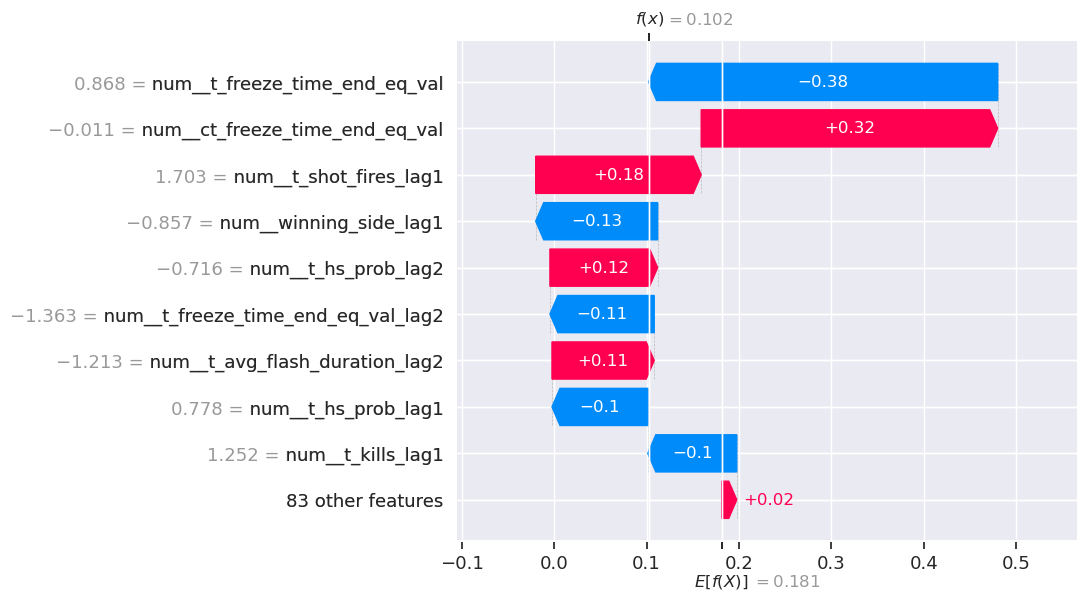

In [110]:
shap.plots.waterfall(shap_values[2])

In [111]:
model = LogisticRegression(random_state=42)

# Train the model
model.fit(X_train, y_train)

# Make predictions and evaluate
y_pred = model.predict(X_test)
cm = confusion_matrix(y_test_match, y_pred)
print("\nConfusion Matrix:")
print(cm)
print("\nClassification Report:")
print(classification_report(y_test_match, y_pred))
accuracy = accuracy_score(y_test_match, y_pred)  # Calculate Accuracy
print(f"Accuracy: {accuracy:.2f}")

# Get feature coefficients. These are like "importance" in Logistic Regression.
coefficients = model.coef_[0]  # [0] because it is binary classification

# Create a DataFrame to display feature importances
feature_importances = pd.DataFrame({'Feature': X_train.columns, 'Importance': abs(coefficients)})  # absolute value
feature_importances = feature_importances.sort_values('Importance', ascending=False)  # Sort by importance

# Print the feature importances
print("\nFeature Coefficients (absolute values):")
display(feature_importances)

# Analyze additional vs normal feature importance
additional_importances = feature_importances[feature_importances['Feature'].str.startswith(add_feature_prefix)]
normal_importances = feature_importances[~feature_importances['Feature'].str.startswith(add_feature_prefix)]
print("\nTop 5 Additional Feature Importances:")
print(additional_importances.head(5))
print("\nTop 5 Normal Feature Importances:")
print(normal_importances.head(5))

# Calculate overall importance of additional vs normal features
total_additional_importance = additional_importances['Importance'].sum()
total_normal_importance = normal_importances['Importance'].sum()
print(f"\nTotal Additional Features Importance: {total_additional_importance:.4f}")
print(f"Total Normal Features Importance: {total_normal_importance:.4f}")
print(f"Ratio of Additional to Normal Feature Importance: {total_additional_importance/total_normal_importance:.4f}")


Confusion Matrix:
[[ 74  38]
 [ 44 107]]

Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.66      0.64       112
           1       0.74      0.71      0.72       151

    accuracy                           0.69       263
   macro avg       0.68      0.68      0.68       263
weighted avg       0.69      0.69      0.69       263

Accuracy: 0.69

Feature Coefficients (absolute values):


Feature  Importance
0        num__ct_freeze_time_end_eq_val    0.915238
1         num__t_freeze_time_end_eq_val    0.699167
69               num__ct_kast_prob_lag2    0.553703
59                    num__t_kills_lag2    0.498380
74      num__t_shot_connected_prob_lag2    0.476090
..                                  ...         ...
31           num__ct_decoy_grenade_lag1    0.009824
28     num__ct_shot_connected_prob_lag1    0.009370
50  num__ct_freeze_time_end_eq_val_lag2    0.008651
86             num__t_fire_grenade_lag2    0.007447
32               num__ct_flashbang_lag1    0.006626

[92 rows x 2 columns]


Top 5 Additional Feature Importances:
Empty DataFrame
Columns: [Feature, Importance]
Index: []

Top 5 Normal Feature Importances:
                            Feature  Importance
0    num__ct_freeze_time_end_eq_val    0.915238
1     num__t_freeze_time_end_eq_val    0.699167
69           num__ct_kast_prob_lag2    0.553703
59                num__t_kills_lag2    0.498380
74  num__t_shot_connected_prob_lag2    0.476090

Total Additional Features Importance: 0.0000
Total Normal Features Importance: 14.4539
Ratio of Additional to Normal Feature Importance: 0.0000


# grad boost for regression freeze time end eq val

In [112]:
side="ct"
m_lag_df = lag_df.copy()
m_lag_df["freeze_time_end_eq_val_diff"]=m_lag_df["ct_freeze_time_end_eq_val"]-m_lag_df["t_freeze_time_end_eq_val"]
m_lag_df.drop(["ct_freeze_time_end_eq_val","t_freeze_time_end_eq_val"],axis=1,inplace=True)
m_lag_df

n_ticks_lag1  \
match_id                             round_num                 
bfa9bbbe-bd16-4713-bd99-745378db05cb 1                  -1.0   
                                     2               13026.0   
                                     3               29455.0   
                                     4               51519.0   
                                     5               98753.0   
...                                                      ...   
816e1612-9d2e-4893-af23-bda90c479598 13             174128.0   
                                     14             183596.0   
                                     15             197648.0   
                                     16             208908.0   
                                     17             254837.0   

                                                bomb_plant_tick_lag1  \
match_id                             round_num                         
bfa9bbbe-bd16-4713-bd99-745378db05cb 1                          -1.0   
                                     2                        9411.0   
                                     3                       24206.0   
                                     4                       46270.0   
                                     5                          -1.0   
...                                                              ...   
816e1612-9d2e-4893-af23-bda90c479598 13                         -1.0   
                                     14                         -1.0   
                                     15                         -1.0   
                                     16                         -1.0   
                                     17                     250353.0   

                                                winning_side_lag1  \
match_id                             round_num                      
bfa9bbbe-bd16-4713-bd99-745378db05cb 1                       -1.0   
                                     2                        0.0   
                                     3                        0.0   
                                     4                        0.0   
                                     5                        1.0   
...                                                           ...   
816e1612-9d2e-4893-af23-bda90c479598 13                       1.0   
                                     14                       1.0   
                                     15                       1.0   
                                     16                       1.0   
                                     17                       1.0   

                                                ct_freeze_time_end_eq_val_lag1  \
match_id                             round_num                                   
bfa9bbbe-bd16-4713-bd99-745378db05cb 1                                    -1.0   
                                     2                                  4300.0   
                                     3                                 10600.0   
                                     4                                  5300.0   
                                     5                                 27450.0   
...                                                                        ...   
816e1612-9d2e-4893-af23-bda90c479598 13                                34400.0   
                                     14                                34000.0   
                                     15                                34000.0   
                                     16                                34200.0   
                                     17                                 4350.0   

                                                t_freeze_time_end_eq_val_lag1  \
match_id                             round_num                                  
bfa9bbbe-bd16-4713-bd99-745378db05cb 1                                   -1.0   
                                     2                                

In [113]:
X = m_lag_df.drop(f"freeze_time_end_eq_val_diff",axis=1)
y = m_lag_df[f"freeze_time_end_eq_val_diff"].values.reshape(-1,1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

num_cols = X.select_dtypes(exclude=['object','category']).columns.to_list()
cat_cols = X.select_dtypes(include=['object','category']).columns.to_list()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), cat_cols),
    ],
    remainder="passthrough"
    
).set_output(transform="pandas")

X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)
ss = StandardScaler()
y_train = ss.fit_transform(y_train)
y_test = ss.transform(y_test)

In [114]:
print(X_train.shape,y_train.shape)

(1049, 91) (1049, 1)


In [115]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from xgboost import XGBRegressor
import numpy as np

# Step 1: Define your parameter grid
param_dist = {
    'learning_rate': np.linspace(0.01, 0.3, 30),
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [3, 4, 5, 6, 7, 8],
    'min_child_weight': [1, 3, 5, 7],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0]
}

# Step 2: Set up your model
xgb_model = XGBRegressor(
    enable_categorical=True,
    objective='reg:squarederror',  # Typical objective for regression
    random_state=42
)

# Step 3: Set up RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=10,                  # Number of parameter settings sampled
    scoring='neg_mean_squared_error',  # Scoring for regression
    cv=5,                       # 5-fold cross validation
    verbose=0,
    random_state=42,
    n_jobs=-1                   # Use all cores
)


# Step 5: Fit RandomizedSearchCV
random_search.fit(X_train, y_train)

# Step 6: Best model
best_model = random_search.best_estimator_

# Step 7: Make predictions on test data
y_pred_money = best_model.predict(X_test)
print(y_pred_money)

# Step 8: Evaluate
mse = mean_squared_error(y_test, y_pred_money)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred_money)
r2 = r2_score(y_test, y_pred_money)

print(f"Best Parameters: {random_search.best_params_}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R^2 Score: {r2:.4f}")

# Step 9 (Optional): Cross-validation for more robust evaluation
cv_scores = cross_val_score(best_model, X, y, cv=5, scoring='neg_mean_squared_error')
cv_rmse_scores = np.sqrt(-cv_scores)

print(f"\nCross-validation RMSE scores: {cv_rmse_scores}")
print(f"Mean CV RMSE: {cv_rmse_scores.mean():.4f}")


[-1.0027254   0.8963553  -0.45625514 -0.05536722  0.06494225  0.05158804
 -0.42806897 -0.3092097  -0.15967591 -1.7204003   0.21197683  0.9352583
 -1.074944   -0.4307281   1.4790177  -0.34469476  1.465625    1.0883868
 -0.8589331   1.2761889  -0.52458483  0.99917406 -0.5152934   0.38507697
  1.5891607  -1.1666017   0.34195915  0.7934761   1.092401    0.9979476
 -0.35407394 -0.00995286  0.44092572  1.1842266  -1.0909103   0.8081144
 -1.083984   -1.1392608   0.67684686  0.40031978  1.1441766   0.8147198
  0.45514148  0.4084698   1.2670683   0.15472494 -1.6795615  -0.33191264
 -1.7551677  -1.2640835  -0.67842     0.41540664  0.02540987  0.48002303
 -1.0269796   0.74329776  0.5383982  -0.19345957  1.0548857   0.23991083
  0.54431576 -1.107349   -0.07468174  1.3737979   0.90737456 -1.0967351
 -0.32572553 -0.24236707 -1.2677149  -1.7616123   1.5294044   0.5940961
 -0.3092097   0.66924787  0.91654    -0.9971271  -0.3073365   1.2267531
  0.5895147   0.3929316   0.8887217  -0.72344106 -0.3073365

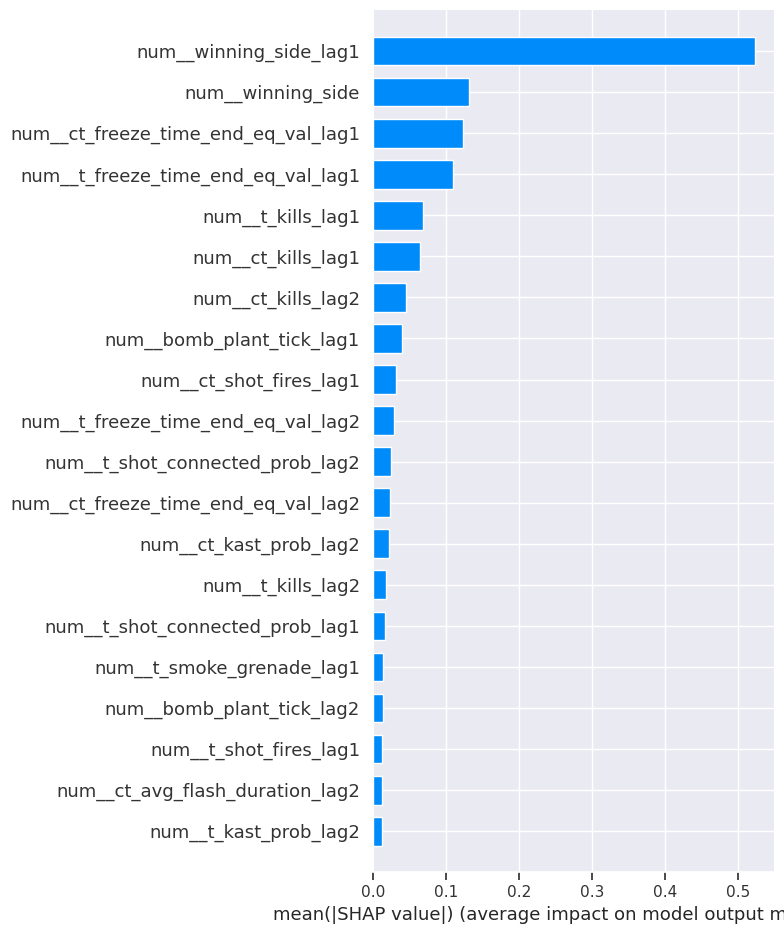

In [116]:
explainer = shap.Explainer(best_model)

# Step 2: Calculate SHAP values
shap_values = explainer(X_test)

# Step 3: Summary plot (global feature importance)
shap.summary_plot(shap_values, X_test,plot_type="bar")


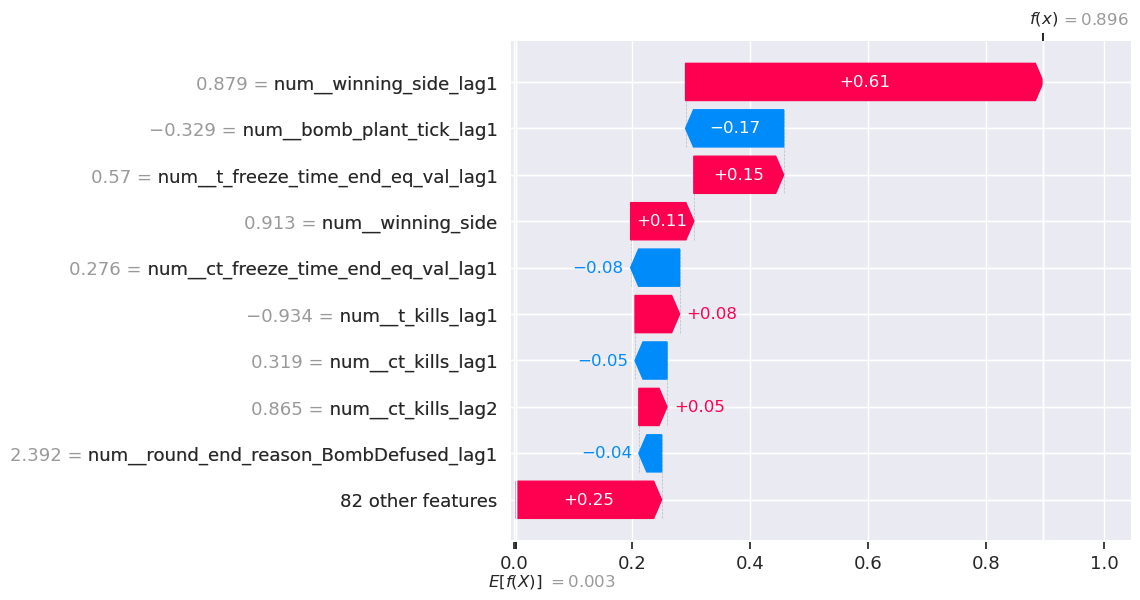

In [117]:
shap.plots.waterfall(shap_values[1])

In [118]:
y_pred_match = log_model.predict(y_pred_money.reshape(-1,1))

In [119]:
cm = confusion_matrix(y_test_match, y_pred_match)
print("\nConfusion Matrix:")
print(cm)
print("\nClassification Report:")
print(classification_report(y_test_match, y_pred_match))
accuracy = accuracy_score(y_test_match, y_pred_match)  # Calculate Accuracy
print(f"Accuracy: {accuracy:.2f}")



Confusion Matrix:
[[ 73  39]
 [ 31 120]]

Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.65      0.68       112
           1       0.75      0.79      0.77       151

    accuracy                           0.73       263
   macro avg       0.73      0.72      0.73       263
weighted avg       0.73      0.73      0.73       263

Accuracy: 0.73


# final model

In [216]:
df = reduced_rounds_sum_df.copy()
df["freeze_time_end_eq_val_diff"]=df["ct_freeze_time_end_eq_val"]-df["t_freeze_time_end_eq_val"]
df.drop(["ct_freeze_time_end_eq_val","t_freeze_time_end_eq_val"],axis=1,inplace=True)
lag_df = create_lag(df,2)
lag_df.fillna(-1,inplace=True)

lag_df = lag_df[[col for col in lag_df.columns if "_lag" in col or col == "freeze_time_end_eq_val_diff"]+["winning_side"]]
lag_df

freeze_time_end_eq_val_diff  \
match_id                             round_num                                
bfa9bbbe-bd16-4713-bd99-745378db05cb 1                                  -50   
                                     2                                -7400   
                                     3                               -16700   
                                     4                                 -100   
                                     5                                -8300   
...                                                                     ...   
816e1612-9d2e-4893-af23-bda90c479598 13                               17000   
                                     14                               25850   
                                     15                                8100   
                                     16                                 150   
                                     17                                2100   

                                                n_ticks_lag1  \
match_id                             round_num                 
bfa9bbbe-bd16-4713-bd99-745378db05cb 1                  -1.0   
                                     2               13026.0   
                                     3               29455.0   
                                     4               51519.0   
                                     5               98753.0   
...                                                      ...   
816e1612-9d2e-4893-af23-bda90c479598 13             174128.0   
                                     14             183596.0   
                                     15             197648.0   
                                     16             208908.0   
                                     17             254837.0   

                                                bomb_plant_tick_lag1  \
match_id                             round_num                         
bfa9bbbe-bd16-4713-bd99-745378db05cb 1                          -1.0   
                                     2                        9411.0   
                                     3                       24206.0   
                                     4                       46270.0   
                                     5                          -1.0   
...                                                              ...   
816e1612-9d2e-4893-af23-bda90c479598 13                         -1.0   
                                     14                         -1.0   
                                     15                         -1.0   
                                     16                         -1.0   
                                     17                     250353.0   

                                                winning_side_lag1  \
match_id                             round_num                      
bfa9bbbe-bd16-4713-bd99-745378db05cb 1                       -1.0   
                                     2                        0.0   
                                     3                        0.0   
                                     4                        0.0   
                                     5                        1.0   
...                                                           ...   
816e1612-9d2e-4893-af23-bda90c479598 13                       1.0   
                                     14                       1.0   
                                     15                       1.0   
                                     16                       1.0   
                                     17                       1.0   

                                                ct_flash_opp_lag1  \
match_id                             round_num                      
bfa9bbbe-bd16-4713-bd99-745378db05cb 1                       -1.0   
                                     2                        0.0   
                                     3                        0.0   
       

In [217]:
lag_df.to_csv("lag_df.csv")

In [218]:
X_win = lag_df[["freeze_time_end_eq_val_diff"]]
y_win = lag_df.winning_side

X_money = lag_df.drop(["freeze_time_end_eq_val_diff","winning_side"],axis=1)
y_money = lag_df.freeze_time_end_eq_val_diff

X_train_win, X_test_win, y_train_win, y_test_win = train_test_split(X_win, y_win, test_size=0.2, random_state=42)

X_train_money, X_test_money, y_train_money, y_test_money = train_test_split(X_money, y_money, test_size=0.2, random_state=42)

In [219]:
X_train_win

freeze_time_end_eq_val_diff
match_id                             round_num                             
9299c0e4-9d62-4c3a-ac5b-fca5b61431df 12                               23450
e0bf3c83-af14-4f74-aa93-827dc28d9c11 9                                20000
1625f047-b597-403d-b9c4-0660138852ca 20                                -600
d2dff070-d216-4b59-9edd-1e20e9518a8a 20                                8950
                                     10                              -11050
...                                                                     ...
489338c2-71c4-4d7b-90f2-cb124986bd4b 23                                9250
e2f49be0-bb4f-4968-b96b-a608a18bb7ba 2                                18400
564caade-5ad3-4cc4-a237-782b4dcf75a3 26                              -13350
1aa3bf00-6172-4e39-a6f1-8078b1473c0a 1                                 -100
d02d1507-5e53-4284-b69e-60a6f1255033 26                                8950

[1049 rows x 1 columns]

In [220]:
money_columns = X_train_money.columns
win_columns = X_train_win.columns

# Scale the data
money_scaler = MinMaxScaler()
win_scaler = MinMaxScaler()

X_train_money = money_scaler.fit_transform(X_train_money)
X_test_money = money_scaler.transform(X_test_money)

X_train_win = win_scaler.fit_transform(X_train_win)
X_test_win = win_scaler.transform(X_test_win)

# Convert back to DataFrames with original column names
X_train_money = pd.DataFrame(X_train_money, columns=money_columns)
X_test_money = pd.DataFrame(X_test_money, columns=money_columns)

X_train_win = pd.DataFrame(X_train_win, columns=win_columns)
X_test_win = pd.DataFrame(X_test_win, columns=win_columns)

# Display
display(X_train_money)
display(X_test_money)
display(X_train_win)
display(X_test_win)


n_ticks_lag1  bomb_plant_tick_lag1  winning_side_lag1  \
0         0.242384              0.000000                1.0   
1         0.165690              0.000000                1.0   
2         0.434486              0.000000                0.5   
3         0.501081              0.000000                1.0   
4         0.242716              0.239574                0.5   
...            ...                   ...                ...   
1044      0.469149              0.000000                1.0   
1045      0.043568              0.000000                1.0   
1046      0.520388              0.522224                0.5   
1047      0.000000              0.000000                0.0   
1048      0.582634              0.000000                1.0   

      ct_flash_opp_lag1  t_flash_opp_lag1  ct_flashed_lag1  t_flashed_lag1  \
0              0.423077          0.195122         0.225806        0.333333   
1              0.076923          0.097561         0.129032        0.055556   
2              0.038462          0.024390         0.032258        0.027778   
3              0.192308          0.097561         0.161290        0.111111   
4              0.230769          0.121951         0.322581        0.027778   
...                 ...               ...              ...             ...   
1044           0.038462          0.024390         0.032258        0.027778   
1045           0.038462          0.024390         0.032258        0.027778   
1046           0.576923          0.121951         0.322581        0.277778   
1047           0.000000          0.000000         0.000000        0.000000   
1048           0.230769          0.195122         0.096774        0.305556   

      ct_avg_flash_duration_lag1  t_avg_flash_duration_lag1  ct_kills_lag1  \
0                       0.333596                   0.628264       0.857143   
1                       0.522379                   0.204017       0.571429   
2                       0.163025                   0.162003       0.142857   
3                       0.584183                   0.851035       0.857143   
4                       0.597120                   0.162003       0.428571   
...                          ...                        ...            ...   
1044                    0.163025                   0.162003       0.857143   
1045                    0.163025                   0.162003       0.857143   
1046                    0.396106                   0.532256       0.714286   
1047                    0.000000                   0.000000       0.000000   
1048                    0.523707                   0.481172       0.857143   

      ...  ct_grenade_connected_prob_lag2  t_grenade_connected_prob_lag2  \
0     ...                        0.600000                       0.500000   
1     ...                        0.600000                       0.500000   
2     ...                        0.600000                       0.833333   
3     ...                        0.600000                       0.500000   
4     ...                        0.600000                       0.500000   
...   ...                             ...                            ...   
1044  ...                        0.600000                       0.500000   
1045  ...                        0.000000                       0.000000   
1046  ...                        0.728571                       0.666667   
1047  ...                        0.000000                       0.000000   
1048  ...                        0.600000                       0.500000   

      ct_fire_grenade_lag2  t_fire_grenade_lag2  \
0                    0.750             0.428571   
1                    0.625             0.285714   
2                    0.125             0.428571   
3                    0.500             0.571429   
4                    0.500             0.285714   
...                    ...                  ...   
1044                 0.625             0.428571   
1045                 0.000             0.000000   
104

n_ticks_lag1  bomb_plant_tick_lag1  winning_side_lag1  ct_flash_opp_lag1  \
0        0.242414              0.236138                0.5           0.038462   
1        0.084292              0.081193                1.0           0.346154   
2        0.261751              0.261904                0.5           0.269231   
3        0.560523              0.555482                0.5           0.192308   
4        0.591729              0.587469                0.5           0.307692   
..            ...                   ...                ...                ...   
258      0.050019              0.042981                0.5           0.038462   
259      0.164959              0.000000                1.0           0.461538   
260      0.063417              0.056432                0.5           0.076923   
261      0.571867              0.000000                1.0           0.500000   
262      0.208195              0.000000                1.0           0.692308   

     t_flash_opp_lag1  ct_flashed_lag1  t_flashed_lag1  \
0            0.292683         0.129032        0.250000   
1            0.097561         0.193548        0.194444   
2            0.170732         0.258065        0.166667   
3            0.390244         0.387097        0.250000   
4            0.048780         0.129032        0.166667   
..                ...              ...             ...   
258          0.219512         0.096774        0.194444   
259          0.195122         0.451613        0.166667   
260          0.292683         0.129032        0.277778   
261          0.341463         0.580645        0.250000   
262          0.317073         0.645161        0.305556   

     ct_avg_flash_duration_lag1  t_avg_flash_duration_lag1  ct_kills_lag1  \
0                      0.478761                   0.465086       0.571429   
1                      0.420627                   0.775124       0.714286   
2                      0.502454                   0.446448       0.571429   
3                      0.514571                   0.329636       0.428571   
4                      0.308511                   0.485169       0.714286   
..                          ...                        ...            ...   
258                    0.622209                   0.321318       0.428571   
259                    0.549716                   0.457376       0.857143   
260                    0.636035                   0.337967       0.428571   
261                    0.462266                   0.374031       0.857143   
262                    0.497004                   0.786041       0.857143   

     ...  ct_grenade_connected_prob_lag2  t_grenade_connected_prob_lag2  \
0    ...                        0.600000                       0.500000   
1    ...                        0.830769                       0.500000   
2    ...                        0.600000                       0.500000   
3    ...                        0.600000                       0.500000   
4    ...                        0.600000                       0.500000   
..   ...                             ...                            ...   
258  ...                        0.600000                       0.500000   
259  ...                        0.600000                       0.576923   
260  ...                        0.600000                       0.500000   
261  ...                        0.600000                       0.500000   
262  ...                        0.600000                       0.500000   

     ct_fire_grenade_lag2  t_fire_grenade_lag2  \
0                   0.500             0.714286   
1                   0.375             0.142857   
2                   0.750             0.142857   
3                   0.625             0.142857   
4                   0.625             0.142857   
..                    ...                  ...   
258                 0.125             0.142857   
259                 0.625             0.571429   
260                 0.125             0.285714   
261      

freeze_time_end_eq_val_diff
0                        0.868670
1                        0.809442
2                        0.455794
3                        0.619742
4                        0.276395
...                           ...
1044                     0.624893
1045                     0.781974
1046                     0.236910
1047                     0.464378
1048                     0.619742

[1049 rows x 1 columns]

freeze_time_end_eq_val_diff
0                       0.382833
1                       0.726180
2                       0.397425
3                       0.300429
4                       0.636052
..                           ...
258                     0.272103
259                     0.585408
260                     0.239485
261                     0.612017
262                     0.773391

[263 rows x 1 columns]

In [221]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline

# Define how many features you want to select
target_n_features = 25  # Adjust this number based on your needs

# Set a sequence of alpha values to try
alphas = np.logspace(-4, 2, 30)  # Try a range of alphas from 0.0001 to 100

# Create a dictionary of parameters to search
param_grid = {'alpha': alphas}

# Initialize the Lasso model
lasso = Lasso(random_state=42, max_iter=10000)

# Set up GridSearchCV
# Note: We're using custom scoring here to find the alpha that selects closest to target_n_features
def custom_scorer(estimator, X, y):
    # Count non-zero coefficients (selected features)
    n_selected = np.sum(np.abs(estimator.coef_) > 1e-3)
    # Return negative absolute difference from target (to maximize)
    return -np.abs(n_selected - target_n_features)

# Initialize GridSearchCV with our custom scorer
grid_search = GridSearchCV(
    lasso, 
    param_grid, 
    cv=5,  # 5-fold cross-validation
    scoring=custom_scorer,
    verbose=False,
    n_jobs=-1  # Use all available cores
)

# Fit the grid search
print("Running GridSearchCV for Lasso feature selection...")
grid_search.fit(X_train_money, y_train_money)

# Get best parameters and best model
best_alpha = grid_search.best_params_['alpha']
best_lasso = grid_search.best_estimator_  # This is the best model from GridSearchCV
print(f"\nBest alpha: {best_alpha:.6f}")

selected_mask = np.abs(final_lasso.coef_) > 1e-3
best_features = X_train_money.columns[selected_mask].tolist()
best_n_features = len(best_features)

X_train_selected = X_train_money[best_features]
X_test_selected = X_test_money[best_features]

display(X_test_selected)

Running GridSearchCV for Lasso feature selection...


/nix/store/pdaw91sv5hqsl1mabdv80c31z8jxgns1-python3-3.11.10-env/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.969e+09, tolerance: 1.191e+07
  model = cd_fast.enet_coordinate_descent(
/nix/store/pdaw91sv5hqsl1mabdv80c31z8jxgns1-python3-3.11.10-env/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.088e+09, tolerance: 1.103e+07
  model = cd_fast.enet_coordinate_descent(
/nix/store/pdaw91sv5hqsl1mabdv80c31z8jxgns1-python3-3.11.10-env/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You mi


Best alpha: 62.101694


bomb_plant_tick_lag1  winning_side_lag1  t_kills_lag1  \
0                0.236138                0.5      0.714286   
1                0.081193                1.0      0.285714   
2                0.261904                0.5      0.857143   
3                0.555482                0.5      0.714286   
4                0.587469                0.5      0.857143   
..                    ...                ...           ...   
258              0.042981                0.5      0.571429   
259              0.000000                1.0      0.285714   
260              0.056432                0.5      0.714286   
261              0.000000                1.0      0.285714   
262              0.000000                1.0      0.428571   

     ct_smoke_grenade_lag1  t_smoke_grenade_lag1  ct_fire_grenade_lag1  \
0                 0.428571              0.857143                 0.125   
1                 0.571429              0.714286                 0.500   
2                 0.571429              0.714286                 0.625   
3                 0.714286              0.857143                 0.625   
4                 0.714286              0.571429                 0.875   
..                     ...                   ...                   ...   
258               0.142857              1.000000                 0.125   
259               0.571429              0.571429                 0.750   
260               0.428571              0.714286                 0.375   
261               0.857143              0.714286                 0.625   
262               0.571429              0.571429                 0.500   

     round_end_reason_BombDefused_lag1  round_end_reason_CTWin_lag1  \
0                                  0.5                          0.5   
1                                  1.0                          0.5   
2                                  0.5                          0.5   
3                                  0.5                          0.5   
4                                  0.5                          0.5   
..                                 ...                          ...   
258                                0.5                          0.5   
259                                0.5                          1.0   
260                                0.5                          0.5   
261                                0.5                          1.0   
262                                0.5                          1.0   

     round_end_reason_TargetBombed_lag1  round_end_reason_TerroristsWin_lag1  \
0                                   1.0                                  0.5   
1                                   0.5                                  0.5   
2                                   0.5                                  1.0   
3                                   1.0                                  0.5   
4                                   0.5                                  1.0   
..                                  ...                                  ...   
258                                 1.0                                  0.5   
259                                 0.5                                  0.5   
260                                 1.0                                  0.5   
261                                 0.5                                  0.5   
262                                 0.5                                  0.5   

     freeze_time_end_eq_val_diff_lag1  winning_side_lag2  ct_kills_lag2  \
0                            0.162232                0.5       0.428571   
1                            0.485837                1.0       0.857143   
2                            0.558798                1.0       0.857143   
3                            0.563948                1.0       0.857143   
4                            0.622318                1.0       0.857143   
..                                ...                ...            ...   
258                          0.3

In [222]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from xgboost import XGBRegressor
import numpy as np
import pandas as pd

# ------------- FEATURE SELECTION -------------
# First, define a base model for feature selection
base_model = XGBRegressor(
    enable_categorical=True,
    objective='reg:squarederror',
    random_state=42
)

# Set up the sequential feature selector with forward selection

# ------------- MODEL TRAINING AND EVALUATION -------------
# Step 1: Define your parameter grid
param_dist = {
    'learning_rate': np.linspace(0.01, 0.3, 30),
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [3, 4, 5, 6, 7, 8],
    'min_child_weight': [1, 3, 5, 7],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0]
}

# Step 2: Set up your model
xgb_model = XGBRegressor(
    enable_categorical=True,
    objective='reg:squarederror',
    random_state=42
)

# Step 3: Set up RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=10,                  # Number of parameter settings sampled
    scoring='neg_mean_squared_error',
    cv=5,
    verbose=0,
    random_state=42,
    n_jobs=-1
)

# Step 5: Fit RandomizedSearchCV on selected features
print("Training model with selected features...")
random_search.fit(X_train_selected, y_train_money)

# Step 6: Best model
best_model = random_search.best_estimator_

# Step 7: Make predictions on test data with selected features
y_pred_money = best_model.predict(X_test_selected)

# Step 8: Evaluate
mse = mean_squared_error(y_test_money, y_pred_money)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_money, y_pred_money)
r2 = r2_score(y_test_money, y_pred_money)

print(f"Best Parameters: {random_search.best_params_}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R^2 Score: {r2:.4f}")

# Step 9: Cross-validation for more robust evaluation
# Construct the full dataset with selected features
cv_scores = cross_val_score(best_model, X_money, y_money, cv=5, scoring='neg_mean_squared_error')
cv_rmse_scores = np.sqrt(-cv_scores)
print(f"\nCross-validation RMSE scores: {cv_rmse_scores}")
print(f"Mean CV RMSE: {cv_rmse_scores.mean():.4f}")

# Compare with results without feature selection (optional)
print("\n--- Comparison with original model ---")
orig_model = XGBRegressor(**random_search.best_params_, random_state=42)
orig_model.fit(X_train_money, y_train_money)
orig_pred = orig_model.predict(X_test_money)
orig_rmse = np.sqrt(mean_squared_error(y_test_money, orig_pred))
print(f"Original model RMSE: {orig_rmse:.4f}")
print(f"Feature selected model RMSE: {rmse:.4f}")
print(f"Improvement: {(orig_rmse - rmse) / orig_rmse * 100:.2f}%")

Training model with selected features...
Best Parameters: {'subsample': 0.9, 'n_estimators': 300, 'min_child_weight': 5, 'max_depth': 4, 'learning_rate': 0.03, 'gamma': 0.1, 'colsample_bytree': 0.7}
RMSE: 7126.3534
MAE: 5458.2801
R^2 Score: 0.7051

Cross-validation RMSE scores: [7044.17063428 7350.31870572 6471.7260217  6862.20840808 7053.06293543]
Mean CV RMSE: 6956.2973

--- Comparison with original model ---
Original model RMSE: 7071.1756
Feature selected model RMSE: 7126.3534
Improvement: -0.78%


In [223]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Define parameter grid for GridSearchCV
# C is the inverse of regularization strength (smaller C = stronger regularization)
param_grid = {
    'C': np.logspace(-3, 3, 7),  # [0.001, 0.01, 0.1, 1, 10, 100, 1000]
    'class_weight': [None, 'balanced'],
    'max_iter': [1000]
}

# Create base LogisticRegression model
base_model = LogisticRegression(
    penalty='l1',        # Use L1 regularization like Lasso
    solver='liblinear',  # This solver supports L1 penalty
    random_state=42
)

# Set up GridSearchCV
grid_search = GridSearchCV(
    base_model,
    param_grid,
    cv=5,               # 5-fold cross-validation
    scoring='accuracy',  # Optimize for accuracy
    verbose=1,
    n_jobs=-1           # Use all available cores
)

# Train GridSearchCV
print("Running GridSearchCV for Logistic Regression...")
grid_search.fit(X_train_win, y_train_win)

# Get best model and parameters
log_model = grid_search.best_estimator_
log_params = grid_search.best_params_
print(f"\nBest parameters: {best_params}")

# Make predictions using the best model
y_pred_win = log_model.predict(X_test_win)

# Evaluate the model
cm = confusion_matrix(y_test_win, y_pred_win)
print("\nConfusion Matrix:")
print(cm)
print("\nClassification Report:")
print(classification_report(y_test_win, y_pred_win))
accuracy = accuracy_score(y_test_win, y_pred_win)
print(f"Accuracy: {accuracy:.2f}")

Running GridSearchCV for Logistic Regression...
Fitting 5 folds for each of 14 candidates, totalling 70 fits

Best parameters: {'C': 1000.0, 'class_weight': None, 'max_iter': 1000}

Confusion Matrix:
[[ 78  34]
 [ 37 114]]

Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.70      0.69       112
           1       0.77      0.75      0.76       151

    accuracy                           0.73       263
   macro avg       0.72      0.73      0.72       263
weighted avg       0.73      0.73      0.73       263

Accuracy: 0.73


In [224]:
y_pred_money = best_model.predict(X_test_selected).reshape(-1,1)
y_pred_money = win_scaler.transform(y_pred_money)

y_pred_win = log_model.predict(y_pred_money)

cm = confusion_matrix(y_test_win, y_pred_win)
print("\nConfusion Matrix:")
print(cm)
print("\nClassification Report:")
print(classification_report(y_test_win, y_pred_win))
accuracy = accuracy_score(y_test_win, y_pred_win)  # Calculate Accuracy
print(f"Accuracy: {accuracy:.2f}")

# Get feature coefficients. These are like "importance" in Logistic Regression.
coefficients = log_model.coef_[0]  # [0] because it is binary classification

# Create a DataFrame to display feature importances
feature_importances = pd.DataFrame({'Feature': X_win.columns, 'Importance': abs(coefficients)})  # absolute value
feature_importances = feature_importances.sort_values('Importance', ascending=False)  # Sort by importance

# Print the feature importances
print("\nFeature Coefficients (absolute values):")
display(feature_importances.head(15))


Confusion Matrix:
[[ 72  40]
 [ 34 117]]

Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.64      0.66       112
           1       0.75      0.77      0.76       151

    accuracy                           0.72       263
   macro avg       0.71      0.71      0.71       263
weighted avg       0.72      0.72      0.72       263

Accuracy: 0.72

Feature Coefficients (absolute values):


Feature  Importance
0  freeze_time_end_eq_val_diff    4.778546

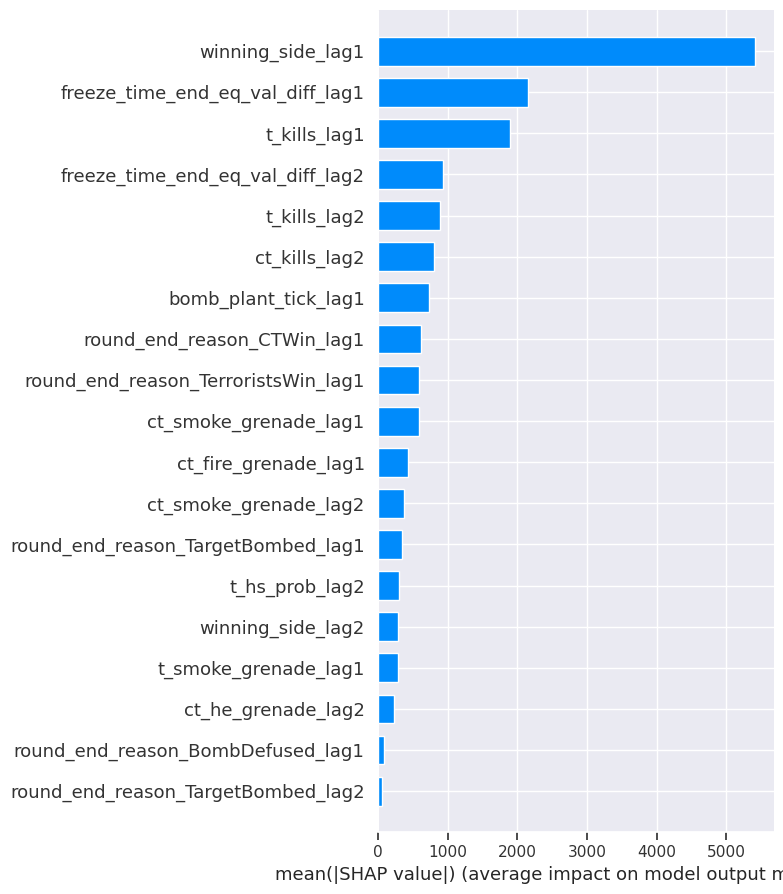

In [225]:
explainer = shap.Explainer(best_model)

# Step 2: Calculate SHAP values
shap_values = explainer(X_test_selected)

# Step 3: Summary plot (global feature importance)
shap.summary_plot(shap_values, X_test_selected,plot_type="bar")